In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import pandas
import scipy
import rir_generator as rir

from shoebox.firwin_torch import firwin_torch

## Data Loading

In [2]:
x = scipy.io.loadmat('somefile.mat')
x['ism_politis'].shape

(96000, 1)

In [3]:
filt = scipy.io.loadmat('rir_filters.mat')
filts = filt['filters']
filts.shape

(1001, 6)

In [4]:
new_data = torch.tensor(x['ism_politis']).float().T
new_data.size()

torch.Size([1, 96000])

In [5]:
# load generated data
rir_np = np.load("./rirData/ism_280_multi_low.npy", allow_pickle=False)
rir_np.shape

(280, 96009)

In [6]:
# load real rir data
rir_real = np.load("real_room_ir.npy", allow_pickle=False)
rir_real.shape

(166, 96000)

## Rir Generators

In [7]:
eps=1e-30#2.2204e-30

In [8]:
def analytic_damping_density(sigma, K, V, device='cpu'):
    ###
    # sigma is also carrying grad
    ###
    Kx, Ky, Kz = K
    # if Kx.requires_grad : Kx.register_hook(lambda x : print("Kx (in analytic): ", Kx.grad_fn,Kx.data, torch.isnan(x)))
    eps=2.2204e-20

    A = -(Kx**2 + Ky**2 + Kz**2)
    # if A.requires_grad : A.register_hook(lambda x : print("A: ",x, A.grad_fn,A.data, torch.any(torch.isnan(x))))
    B = 2 * sigma * Kz
    # if B.requires_grad : B.register_hook(lambda x : print("B: ",x[:10], B.grad_fn,B.data[:10],torch.any(torch.isnan(x))))
    C = Kx**2 + Ky**2 - sigma**2
    # if C.requires_grad : C.register_hook(lambda x : print("C: ",x[:10], C.grad_fn,C.data[:10],torch.any(torch.isnan(x))))
    tmpy = (B**2 - 4 * A * C)
    # remove negative numbers
    #delta = torch.Tensor(np.real([cmath.sqrt(it) for it in tmpy])) #torch.sqrt(B**2 - 4 * A * C)
    delta = torch.sqrt(torch.clamp(tmpy, min=torch.tensor(eps).to(device=device)) )
    # if delta.requires_grad : delta.register_hook(lambda x : print("delta: ",x[:10], delta.grad_fn,delta.data[:10],torch.any(torch.isnan(x))))

    a0 = -torch.sqrt(Kx**2 + Ky**2)
    a1 = Kx
    a2 = Ky
    b = Kz
    c = sigma
    function_p = lambda a: torch.clip((torch.Tensor([[1],[-1]]).to(device=device)*torch.acos(torch.clamp((-c / torch.sqrt(a**2 + b**2)), min=torch.tensor(-0.99999).to(device=device), max=torch.tensor(0.99999).to(device=device)))) - torch.atan(-a/b), min=0, max=torch.pi/2)

    p0 = function_p(a0) #func_p(a0, b , c)
    p1 = function_p(a1) #func_p(a1, b , c)
    p2 = function_p(a2) #func_p(a2, b , c)
    
    function_F = lambda phi: -(1/torch.sqrt(-A)) * torch.asin(torch.clamp(((2 * A * torch.cos(phi) + B)/ (delta + eps)), min=torch.tensor(-0.99999).to(device=device), max=torch.tensor(0.99999).to(device=device)))
    Fint = lambda p_up, p_low:(function_F(p_up) - function_F(p_low))
 
    H0 = Fint(p0[1, :], p0[0, :])
    H1 = Fint(p1[1, :], p1[0, :])
    H2 = Fint(p2[1, :], p2[0, :])
    # if H1.requires_grad : H1.register_hook(lambda x : print("H1: ",x[:10], H1.grad_fn, H1.data[:10], torch.any(torch.isnan(x))))

    #H = (8 / (4 * torch.pi * V)) * (2 * H0 - H1 - H2)
    H = (8 / (V+eps)) * (2 * H0 - H1 - H2)

    # only as return values
    p = torch.transpose(torch.vstack([p0, p1, p2]), 0,1)
    return H, p

In [9]:
def generate_stochastic_rir(Kx, Ky, Kz, V=torch.prod(torch.tensor([3,4,5])), fs=48000, c=343, max_time=2.0, use_pressure_source=False, device='cpu', dual_output=False):
    # Predefine L 
    c = 343
    # if Ky.requires_grad : Ky.register_hook(lambda x : print("Ky: ", Ky.grad_fn,Ky.data, torch.isnan(x)))
    Kyxz = torch.concatenate((Kx.view(-1,1), Ky.view(-1,1), Kz.view(-1,1)))
    Kxyz = torch.minimum(Kyxz, torch.tensor(-0.0001))  # limit Kxyz to avoid division by 0
    # if Kxyz.requires_grad : Kxyz.register_hook(lambda x : print("Kxyz: ", x,Kxyz.grad_fn, Kxyz.data ,torch.any(torch.isnan(x))))

    max_sigma = torch.max(Kxyz)
    min_sigma = -torch.norm(Kxyz)
    sigma = torch.linspace(min_sigma.item() - 0.01, max_sigma.item() + 0.01, 1000).view(1,-1).to(device=device)
    
    h, p = analytic_damping_density(sigma, Kxyz, V, device=device)
    H = h# / (4 * torch.pi)  

    time = torch.transpose(torch.arange(1, max_time * fs + 1).view(1,-1), 0,1).to(device=device) / fs
    envelope = torch.sqrt(torch.clamp( torch.exp(c * time * sigma) @ torch.transpose(torch.conj(H.view(1,-1)), 0, 1) * torch.mean(torch.diff(sigma)), min=torch.tensor(eps).to(device=device)) )
    #torch.exp(noise_level)
    
    #return envelope
    h1 = envelope * torch.randn(time.size()).to(device=device)
    if dual_output:
        return envelope, h1.squeeze()
    else:
        return h1.squeeze()

In [10]:
def generate_stochastic_rir_del(del_Kx, del_Ky, del_Kz,  V=torch.prod(torch.tensor([3,4,5])), max_time=2.0, fs=48000, c=343, use_pressure_source=False, device='cpu'):
    # noise_level, 
    ###
    #
    # This function uses the difference of K's to predict in the correct order
    ####
    # 
    # if noise_level.requires_grad : noise_level.register_hook(lambda x : print("noise_level", noise_level, noise_level.grad_fn,torch.any(torch.isnan(x))))
    #noise_level = 0.0001
    # Predefine L 
    #L = torch.tensor([3,4,5])
    #V = torch.prod(L)
    # 
    #eps = 2.2204e-20
    #max_time = 2.0
    fs = 48000
    c = 343
    # derive K's
    Kx = del_Kx
    Ky = del_Ky + del_Kx
    Kz = del_Kz + del_Ky + del_Kx
    # if Ky.requires_grad : Ky.register_hook(lambda x : print("Ky: ", Ky.grad_fn,torch.isnan(x)))
    Kyxz = torch.concatenate((Kx.view(-1), Ky.view(-1), Kz.view(-1)))
    Kxyz = torch.minimum(Kyxz, torch.tensor(-0.0001))  # limit Kxyz to avoid division by 0
    # if Kxyz.requires_grad : Kxyz.register_hook(lambda x : print("Kxyz: ", Kxyz.grad_fn,torch.any(torch.isnan(x))))

    max_sigma = torch.max(Kxyz)
    min_sigma = -torch.norm(Kxyz)
    sigma = torch.linspace(min_sigma.item() - 0.01, max_sigma.item() + 0.01, 1000).to(device=device)
    
    H, p = analytic_damping_density(sigma, Kxyz, V, device=device)
    H = H / (4 * torch.pi)  # this is an unexplained tuning factor
    # if H.requires_grad : H.register_hook(lambda x : print("H", H.grad_fn,torch.any(torch.isnan(x))))
    # uniform sampling of damping density for the decay envelope
    time = torch.transpose(torch.arange(1, max_time * fs + 1).view(1,-1), 0,1).to(device=device) / fs
    envelope = torch.sqrt(torch.clamp( torch.exp(c * time * sigma) @ torch.transpose(torch.conj(H.view(1,-1)), 0, 1) * torch.mean(torch.diff(sigma)), min=torch.tensor(eps).to(device=device)) )
    #nn = torch.exp(noise_level)
    # if nn.requires_grad : nn.register_hook(lambda x : print("--NN: ", x, nn))
    # h = envelope * torch.randn(len(time)).to(device=device)
    # return h
    return envelope

In [11]:
# device='cuda'
# rir_data = torch.tensor(rir_np[:5, :], dtype=torch.float)
# lengths, betas, rir_ = rir_data[0, :3], rir_data[0, 3:9], rir_data[0, 9:]
# target_K_values, t_vol = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))).to(device=device), torch.prod(lengths)
# print(f"Target Kvalues: {target_K_values}, targel Volume: {lengths, t_vol} ")

# env, h = generate_stochastic_rir(Kx=target_K_values[0], Ky=target_K_values[1], Kz=target_K_values[2],  V=t_vol, device=device, dual_output=True)

## Models

In [22]:
class RIR_model_vol(torch.nn.Module):
    def __init__(self, Kx=None, Ky=None, Kz=None, volume=None, max_time=2.0, device='cpu') :
        super().__init__()
        if not [x for x in [Kx, Ky, Kz] if x is None]:
            self.Kx = torch.nn.Parameter(torch.tensor(Kx))
            self.Ky = torch.nn.Parameter(torch.tensor(Ky))
            self.Kz = torch.nn.Parameter(torch.tensor(Kz))            
        else:
            # Random Initializationtorch.randint(-4000, -100, (1,)).float()*0.0001
            self.Kx = torch.nn.Parameter(torch.tensor(-0.01))
            self.Ky = torch.nn.Parameter(torch.tensor(-0.01))
            self.Kz = torch.nn.Parameter(torch.tensor(-0.01))
        # if volume is not None:
        #     self.V = torch.nn.Parameter(volume if torch.is_tensor(volume) else torch.tensor(volume))
        # else:
        #     self.V = torch.nn.Parameter(torch.randint(100, 800, (1, )).float())
        self.device = device
        self.maxTime = max_time

    def forward(self):
        def vol_hook(grad):
            clip_value = 1e+5
            clip_neg = -0.5
            gradd = grad.clone()
            #print("INSIDE_GRAD", gradd, torch.clamp(gradd*10000, min=-clip_value , max=clip_value),  self.V)
            #print("INSIDE_GRAD", gradd, gradd*10000 ,  self.V)
            return torch.clamp(gradd*1000, min=clip_neg ,max=clip_value)
        #self.V.register_hook(vol_hook)
        return generate_stochastic_rir(Kx=self.Kx, Ky=self.Ky, Kz=self.Kz, max_time=self.maxTime, device=self.device)

In [25]:
class RIR_model(torch.nn.Module):
    def __init__(self, Kx=None, Ky=None, Kz=None, volume=None, max_time=2.0, device='cpu') :
        super().__init__()
        if not [x for x in [Kx, Ky, Kz] if x is None]:
            self.Kx = torch.nn.Parameter(torch.tensor(Kx))
            self.Ky = torch.nn.Parameter(torch.tensor(Ky))
            self.Kz = torch.nn.Parameter(torch.tensor(Kz))            
        else:
            # Random Initialization
            self.Kx = torch.nn.Parameter(torch.tensor(-0.01))
            self.Ky = torch.nn.Parameter(torch.tensor(-0.01))
            self.Kz = torch.nn.Parameter(torch.tensor(-0.01))
        if volume is not None:
            self.V = torch.nn.Parameter(volume if torch.is_tensor(volume) else torch.tensor(volume))
        else:
            self.V = torch.nn.Parameter(torch.randint(100, 800, (1, )).float())
        self.device = device
        self.maxTime = max_time

    def forward(self):
        def vol_hook(grad):
            clip_value = 1e+5
            clip_neg = -0.5
            gradd = grad.clone()
            #print("INSIDE_GRAD", gradd, torch.clamp(gradd*10000, min=-clip_value , max=clip_value),  self.V)
            #print("INSIDE_GRAD", gradd, gradd*10000 ,  self.V)
            return torch.clamp(gradd*1000, min=clip_neg ,max=clip_value)
        self.V.register_hook(vol_hook)
        return generate_stochastic_rir(Kx=self.Kx, Ky=self.Ky, Kz=self.Kz,V=self.V, max_time=self.maxTime, device=self.device)

In [14]:
class RIR_model_del(torch.nn.Module):
    def __init__(self, del_Kx=None, del_Ky=None, del_Kz=None,  volume=None, max_time=2.0, device='cpu') : 
        #noise_level=None,
        super().__init__()
        if not [x for x in [del_Kx, del_Ky, del_Kz, volume] if x is None]:
            self.del_Kx = torch.nn.Parameter(del_Kx if torch.is_tensor(del_Kx) else torch.tensor(del_Kx))
            self.del_Ky = torch.nn.Parameter(del_Ky if torch.is_tensor(del_Ky) else torch.tensor(del_Ky))
            self.del_Kz = torch.nn.Parameter(del_Kz if torch.is_tensor(del_Kz) else torch.tensor(del_Kz)) 
            #self.noise_level = torch.nn.Parameter(noise_level if torch.is_tensor(noise_level) else torch.tensor(noise_level))
        else:
            self.kx = torch.randint(-2000, -100, (1,)).float()*0.0001
            self.ky = torch.randint(-2000, -100, (1,)).float()*0.0001
            self.kz = torch.randint(-2000, -100, (1,)).float()*0.0001
            self.kes = torch.sort(torch.cat([self.kx.view(-1), self.ky.view(-1), self.kz.view(-1)]))[0]
            self.del_Kx = torch.nn.Parameter(self.kes[0])
            self.del_Ky = torch.nn.Parameter(self.kes[1] - self.kes[0])
            self.del_Kz = torch.nn.Parameter(self.kes[2] - self.kes[1]) 
        if volume is not None:
            self.V = torch.nn.Parameter(volume if torch.is_tensor(volume) else torch.tensor(volume))
        else:
            self.V = torch.nn.Parameter(torch.randint(100, 8000, (1, )).float()*0.1)
        self.device = device
        self.maxTime = max_time
    def forward(self):
        def vol_hook(grad):
            clip_value = 1e+35
            clip_neg = -100
            gradd = grad.clone()
            #print("INSIDE_GRAD", gradd, torch.clamp(gradd*10000, min=-clip_value , max=clip_value),  self.V)
            #print("INSIDE_GRAD", gradd, gradd*10000 ,  self.V)
            return torch.clamp(gradd*10000, min=clip_neg, max=clip_value)
            #return gradd*10000
        def my_hook(grad):
            clip_value = 1e+6
            gradd = grad.clone()
            # print("INSIDE_GRAD", gradd, self.noise_level)
            return torch.clamp(gradd*100, -clip_value)#, clip_value)
        #self.noise_level.register_hook(my_hook)
        self.V.register_hook(vol_hook)
        #self.noise_level.register_hook(lambda x : print('inside_grad', x, self.noise_level))
        # noise_level=self.noise_level,
            
        return generate_stochastic_rir_del(del_Kx=self.del_Kx, del_Ky=self.del_Ky, del_Kz=self.del_Kz,  V=self.V, max_time=self.maxTime, device=self.device)

## Helper Funcitons

In [15]:
def mag2db(xcv):
    return 20 * xcv.log10_()

In [16]:
def rir_smoothing(inp, filter_len=2047,device='cpu', clip_=None, useDefaults=False, display_plot = False, title_sup='Inside Envelope Funciton'):
    ## Main Evelope Block
    filter_= torch.ones(filter_len).to(device=device)
    #filter_avg = filter_#/torch.sum(filter_) # Avg filter
    if useDefaults:
        #print(title_sup)
        # for generated RIR
        filter_avg = filter_/torch.sum(filter_) # Avg filter
    else:
        #for Habets
        filter_avg = filter_#/torch.sum(filter_) # Non-Avg filter
    sqq = inp**2    # Squaring for Power
    #sqq = torch.flipud(inp**2)
    # Smoothing 
    smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    # if smoothed.requires_grad : smoothed.register_hook(lambda x : print("smoothed: ",x[-10:], smoothed.grad_fn,smoothed.data[200:210], torch.any(torch.isnan(x))))
    #return smoothed
    rooted = torch.sqrt(smoothed + eps)
    #rooted = smoothed
    in_db = mag2db(rooted + eps)
    #clip
    if clip_ is not None:
        clipped_db = torch.clip(in_db, min=clip_)
    else:
        clipped_db = in_db
    
    # Plot   
    if display_plot:
        # if title_str == '':
        #     title_str = str(filter_len)
        title_switch = {
        1: "RIR",
        2: "Squared RIR",
        #2: "Amplified",
        3: "Smoothed", 
        4: "No Sqrt" ,
        5: "db"
        }
        if device == 'cuda':
            #normalised_c = normalised.clone()
            llist = [inp.detach().cpu(), sqq.detach().cpu(),smoothed.detach().cpu(),rooted.detach().cpu(), in_db.detach().cpu()]
        else:
            llist = [inp, arr, clipped_db, normalised]
        #
        plt.figure(figsize=(25,4))
        for i, it in enumerate(llist):
            plt.subplot(1,5, i+1)
            plt.plot(it)
            plt.title(title_switch[i+1]) #Filter: "+title_str)
            if title_sup != '':
                plt.suptitle(title_sup)
        plt.show()
    return clipped_db

In [17]:
def env_makerF(inp,  gain=None, clip_=None, normalise=False, title_str = '', title_sup = '', display_plots=False, device='cpu'):
    #eps=2.2204e-20
    # Amplify
    # if inp.requires_grad : inp.register_hook(lambda x : print("env_inp: ", x[200:210],inp.grad_fn,inp.data[200:210], torch.any(torch.isnan(x))))
    if gain is not None:
        arr = inp * (10**(gain/20))
    else:
        arr = inp
    # if arr.requires_grad : arr.register_hook(lambda x : print("arr: ",x[200:210], arr.grad_fn,arr.data[200:210],torch.any(torch.isnan(x))))
    # ## Main Evelope Block
    # filter_= torch.ones(filter_len).to(device=device)
    # filter_avg = filter_/torch.sum(filter_) # Avg filter
    # sqq = arr**2    # Squaring for Power
    # # Smoothing 
    # smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    # if smoothed.requires_grad : smoothed.register_hook(lambda x : print("smoothed: ",x[-10:], smoothed.grad_fn,smoothed.data[200:210], torch.any(torch.isnan(x))))
    sm2 = arr.clone() + eps
    # if sm2.requires_grad : sm2.register_hook(lambda x : print("sm2: ", x[-10:], sm2.grad_fn,sm2.data, torch.any(torch.isnan(x))))
    # if torch.any(sm2<=0) : print("negative in sm2",[it for it in sm2 if it<=0])
    in_db = mag2db(sm2)    # Convert to dB scale
    #if in_db.requires_grad : in_db.register_hook(lambda x : print("in_db: ", x,in_db.grad_fn,in_db.data, torch.any(torch.isnan(x))))

    # Clipping below -150/-100dB
    # if clip_ is not None:
    #     in_db2 = torch.clip(in_db, min=clip_)
    # else:
    #     in_db2 = in_db

    # normalise around zero
    if normalise:
        normalised = in_db - torch.mean(in_db)
    else:
        normalised = in_db
    #if normalised.requires_grad : normalised.register_hook(lambda x : print("normalised: ", x[:10], normalised.grad_fn,normalised.data[:10], torch.any(torch.isnan(x))))
    # Clipping below -150/-100dB
    if clip_ is not None:
        clipped_db = torch.clip(normalised, min=clip_)
    else:
        clipped_db = normalised
    # Plot   
    if display_plots:
        # if title_str == '':
        #     title_str = str(filter_len)
        title_switch = {
        1: "RIR",
        # 2: "Squared RIR",
        2: "Amplified",
        3: "in dB", 
        4: "normalised" ,
        5: "clipped"}
        if device == 'cuda':
            normalised_c = normalised.clone()
            llist = [inp.detach().cpu(), arr.detach().cpu(),in_db.detach().cpu(),normalised_c.detach().cpu(),clipped_db.detach().cpu()]
        else:
            llist = [inp, arr, clipped_db, normalised]
        #
        plt.figure(figsize=(25,4))
        for i, it in enumerate(llist):
            plt.subplot(1,5, i+1)
            plt.plot(it)
            plt.title(title_switch[i+1]) #Filter: "+title_str)
            if title_sup != '':
                plt.suptitle(title_sup)
        plt.show()
    
    return normalised

In [18]:
def rir_bands(rir, f_center=None, fs=48000, device='cpu', disp=False):
# separate RIR into Frequenc bands
    if not f_center:
        nBands = 6
        f_center = torch.zeros(nBands).to(device=device)
        f_center[0] = 125.0     # lowest octave band
        for it in range(1, nBands):
            f_center[it] =  2.0 * f_center[it-1]
    else:
        nBands = f_center.size(0)

    if nBands == 1:
        return rir
    else:
        # order of filters
        order = 1000
        filters = torch.zeros(order + 1, nBands).to(device=device)

        for i in range(nBands):
            if i == 0:
                fl = 30
                fh = (f_center[i] * f_center[i + 1]).sqrt()
                w = torch.tensor([fl / (fs / 2), fh / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='bandpass',  idx = i, device=device)
            elif i == nBands - 1:
                fl = (f_center[i] * f_center[i - 1]).sqrt()
                w = torch.tensor([fl / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='highpass',idx = i, device=device)
            else:
                fl = (f_center[i] * f_center[i - 1]).sqrt()
                fh = (f_center[i] * f_center[i + 1]).sqrt()
                w = torch.tensor([fl / (fs / 2), fh / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='bandpass',  idx = i, device=device)
        # padding
        temp_rir = torch.cat([rir, torch.zeros(order).to(device=device)])

        #plot filters
        if disp:
            plt.figure(4, figsize=(15,8))
            for it in range(filters.size(1)):
                plt.subplot(2,3,it+1)
                plt.plot(filters[:,it].cpu())

        rir_filt = torch.zeros(rir.size(0)).to(device=device)
        for j in range(nBands):
            xy = torch.nn.functional.conv1d(temp_rir.reshape(1, -1), filters[:, j].reshape(1,1,-1), stride=1, padding='valid', bias=None).squeeze()
            rir_filt = torch.vstack((rir_filt, xy))

        rir_filt = rir_filt[1:,:].T
        if disp:
            plt.figure(40, figsize=(15,8))
            for it in range(rir_filt.size(1)):
                plt.subplot(2,3,it+1)
                plt.plot(rir_filt[:,it].cpu())
            
        return rir_filt

In [19]:
# calculate Damping Coefficients, K Values, and Del_K values
def calculate_K(betas_a, lengths_a):
    ''' 
    betas: a 6x1 array of all reflection coefficients
    lengths: 3x1 array of all wall measurements
    '''
    betas = torch.sort(betas_a)[0]
    lengths = torch.sort(lengths_a)[0]
    #print(betas,lengths)
    Kx = torch.log(torch.prod(betas[0:2])) / lengths[0]
    Ky = torch.log(torch.prod(betas[2:4])) / lengths[1]
    Kz = torch.log(torch.prod(betas[4:6])) / lengths[2]
    return Kx, Ky, Kz

# Calculate del K values
def calculate_del_K(Kx, Ky, Kz):
    kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
    return kes[0], kes[1] - kes[0], kes[2] - kes[1]

def calculate_K_from_del(del_Kx, del_Ky, del_Kz):
    return [del_Kx, del_Kx + del_Ky, del_Kz + del_Ky + del_Kx]

In [20]:
def edc_matlab(x, t, clip_=None, display_plot = False, title_sup='Inside EDC Funciton'):
    #print("X: ", x.size())
    squared = torch.square(x.squeeze())
    sq_flipped = torch.flipud(squared)
    sq_cumsum = torch.cumsum(sq_flipped, 0)
    num = torch.flipud(sq_cumsum)

    #dem = torch.sum(squared[t:], 0)
    dem = torch.sum(torch.square(x.squeeze()[t:]), 0)
    temp = num#/dem
    #temp = torch.flipud(torch.cumsum(torch.flipud(torch.square(x.squeeze())), 0)) / torch.sum(torch.square(x.squeeze()[t:]), 0)

    # convert to dB
    in_db = mag2db(temp + eps)
    
    if clip_ is not None:
        clipped_db = torch.clip(in_db, min=clip_)
    else:
        clipped_db = in_db
    
    if display_plot:
        plt.figure(99, figsize=(25,4))
        if title_sup != '':
            plt.suptitle(title_sup)
        #plt.suptitle("Inside EDC Funciton")
        plt.subplot(1,5,1)
        plt.plot(x.cpu())
        plt.title("RIR")
        # plt.subplot(1,5,2)
        # plt.plot(squared.cpu())
        # plt.title("Squared")
        plt.subplot(1,5,2)
        plt.plot(sq_flipped.cpu())
        plt.title("Square Flipped")
        plt.subplot(1,5,3)
        plt.plot(sq_cumsum.cpu())
        plt.title("CumSum..")
        plt.subplot(1,5,4)
        plt.plot(temp.cpu())
        plt.title("EDC")
        plt.subplot(1,5,5)
        plt.plot(clipped_db.cpu())
        plt.title("dB")
        plt.show()
    
    return clipped_db
    #return temp
    

In [21]:
s=htt

NameError: name 'htt' is not defined

## Training

In [ ]:
plt.figure(4, figsize=(18,12))
for it in range(filts.shape[1]):
    plt.subplot(2,3,it+1)
    plt.plot(filts[:,it])

In [ ]:
x = rir_bands(torch.tensor(rir_np[:1, :], dtype=torch.float).squeeze(), disp=True)

In [ ]:
device = 'cuda'
env_filter_len = int(4096/1 +1)
fs = 48000
limitsTime = 2.0
disp = False
cuton = torch.round(torch.tensor(0.10 * limitsTime * fs)).int()
cutoff = 000
# data 
rir_data = torch.tensor(rir_np[:5, :], dtype=torch.float)
print(f"---------------- Datapoint number: {0+1} out of {rir_data.size(0)} ----------------")

# Habets ISM data
lengths, betas, rir_ = rir_data[0, :3], rir_data[0, 3:9], rir_data[0, 9:][cutoff:]
filtered = rir_bands(rir_.to(device=device), device=device)
target_K_values, t_vol = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))).to(device=device), torch.prod(lengths)
print(f"Target Kvalues: {target_K_values}, targel Volume: {lengths, t_vol} ")
# rir_ = torch.from_numpy(rir.generate(
#             c=343,                                      # Sound velocity (m/s)
#             fs=fs,                                    # Sample frequency (samples/s)
#             r=np.sort(torch.rand(3)*lengths),               # Receiver position(s) [x y z] (m)
#             s=np.sort(torch.rand(3)*lengths),                 # Source position [x y z] (m)
#             L=np.sort(lengths),                        # Room dimensions [x y z] (m)
#             nsample=int(fs*limitsTime),                               # Number of output samples
#             beta=np.sort(betas)                    # Room reflection coefficients [x1 x2 y1 y2 z1 z2]
#         )).float()
l_smoothee = rir_smoothing(rir_.to(device=device), filter_len=env_filter_len, useDefaults=False, device=device, display_plot = disp, title_sup = 'Habets')
edc1 = edc_matlab(rir_.to(device=device), cuton, display_plot=disp)
print(l_smoothee.size())
# politis Data
rir_2 = new_data[cutoff:]
l_smoothee2 = rir_smoothing(rir_2.to(device=device), filter_len=env_filter_len, useDefaults=True , device=device, title_sup = 'Politis')
edc2 = edc_matlab(rir_2.to(device=device).squeeze(), cuton)#,  display_plot=disp)

# generation
#    target_K_values2 = torch.tensor([-0.3275, -0.1038, -0.0313]).to(device=device)
#    lengts2= torch.tensor([4.7000, 6.4000, 7.1000]).to(device=device)
env, h = generate_stochastic_rir(Kx=target_K_values[0], Ky=target_K_values[1], Kz=target_K_values[2],  V=t_vol, device=device, dual_output=True)
print("gene", env.size(), h.size())
edc0 = edc_matlab(h[cutoff:], cuton)
env_smoothee = rir_smoothing(h[cutoff:], filter_len=env_filter_len ,useDefaults=True, device=device, title_sup = 'generatedRIR')
db_env = mag2db(env + eps)

fig = plt.figure(1, figsize=(18,10))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=4)
ax5 = plt.subplot2grid((2,6), (1,4), colspan=2)
fig.suptitle("Overview of RIRs")
#plt.subplot(1,5,1)
ax1.plot(h.cpu()[:15000], label='generated_RIR')#, alpha=0.7)
#plt.plot(rir_2.T.cpu()[:15000], label = 'Politis_ISM_simulated')#, linestyle='', marker='.', alpha=0.5)
ax1.plot(rir_.cpu()[:15000], label = 'Habets_ISM_simulated')
ax1.set_title('RIR - early part')
ax1.legend()
# plt.subplot(1,3,2)
# plt.plot(h.cpu(), label='generated_RIR')
# #plt.yscale('log')
# plt.legend()
#plt.subplot(1,5,2)
ax2.plot(env_smoothee.cpu(), label ='smoothed_generated_RIR')
#pt.plot(l_smoothee2.cpu(), label ='smoothed_Politis ISM_RIR')
ax2.plot(l_smoothee.cpu(), label ='smoothed_Habets ISM_RIR')
ax2.plot(db_env.cpu(), label='Generated stochastic Envelope in DB')
ax2.set_title('EnvMaker function in dB')
#plt.yscale('log')
ax2.legend()
#plt.subplot(1,5,3)
ax3.plot(edc0.cpu(), label ='smoothed_generated_RIR')
#plt.plot(edc2.cpu(), label ='smoothed_Politis ISM_RIR')
ax3.plot(edc1.cpu(), label ='smoothed_Habets ISM_RIR')
#plt.plot(db_env.cpu(), label='Generated stochastic Envelope in DB')
ax3.set_title('EDC function in dB')
ax3.legend()
#plt.subplot(1,5,4)
#plt.plot(edc0.cpu(), label ='EDC func')
#plt.plot(edc2.cpu(), label ='smoothed_Politis ISM_RIR')
ax4.plot(env_smoothee.cpu(), label ='Enveloper')
ax4.plot(db_env.cpu(), label='Generated stochastic Envelope in DB')
ax4.set_title('generated RIR')
ax4.legend()
#plt.subplot(1,5,5)
#plt.plot(edc1.cpu(), label ='EDC func')
#plt.plot(edc2.cpu(), label ='smoothed_Politis ISM_RIR')
ax5.plot(l_smoothee.cpu(), label ='Enveloper')
ax5.plot(db_env.cpu(), label='Generated stochastic Envelope in DB')
ax5.set_title('ISM RIR')
#ax5.yscale('log')
ax5.legend()
fig.tight_layout()
plt.show()

In [ ]:
# 3 plots simul
device = 'cuda'
env_filter_len = 4095
fs = 48000
limitsTime = 2.0
disp = False
cuton = torch.round(torch.tensor(0.10 * limitsTime * fs)).int()
# data 
rir_data = torch.tensor(rir_np[0:2, :], dtype=torch.float)
for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")
    
    # Habets ISM data
    lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
    target_K_values, t_vol = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))).to(device=device), torch.prod(lengths)
    print(f"Target Kvalues: {target_K_values}, targel Volume: {lengths, t_vol} ")
    l_smoothee = rir_smoothing(rir_.to(device=device), filter_len=env_filter_len , device=device)
    edc1 = edc_matlab(rir_.to(device=device), cuton, display_plot=disp)
    
    # politis Data
    #rir_2 = new_data
    #l_smoothee2 = rir_smoothing(rir_2.to(device=device), filter_len=env_filter_len , device=device)
    #edc2 = edc_matlab(rir_2.to(device=device).squeeze(), cuton,  display_plot=disp)
    
    # generation
    #    target_K_values2 = torch.tensor([-0.3275, -0.1038, -0.0313]).to(device=device)
    #    lengts2= torch.tensor([4.7000, 6.4000, 7.1000]).to(device=device)
    env, h = generate_stochastic_rir(Kx=target_K_values[0], Ky=target_K_values[1], Kz=target_K_values[2],  V=t_vol, device=device, dual_output=True)
    edc0 = edc_matlab(h, cuton)
    env_smoothee = rir_smoothing(h.to(device=device), filter_len=env_filter_len , useDefaults=True,device=device)
    db_env = mag2db(env + eps)
    
    plt.figure(1, figsize=(12,8))
    plt.suptitle("Overview of RIRs")
    # plt.subplot(1,3,1)
    # plt.plot(h.cpu()[:15000], label='generated_RIR')#, alpha=0.7)
    # #plt.plot(rir_2.T.cpu()[:15000], label = 'Politis_ISM_simulated')#, linestyle='', marker='.', alpha=0.5)
    # plt.plot(rir_.cpu()[:15000], label = 'Habets_ISM_simulated')
    # plt.title('RIR - early part')
    # plt.legend()
    # plt.subplot(1,3,2)
    # plt.plot(h.cpu(), label='generated_RIR')
    # #plt.yscale('log')
    # plt.legend()
    # plt.subplot(1,3,2)
    plt.plot(env_smoothee.cpu(), label ='smoothed_generated_RIR')
    #plt.plot(l_smoothee2.cpu(), label ='smoothed_Politis ISM_RIR')
    plt.plot(l_smoothee.cpu(), label ='smoothed_Habets ISM_RIR')
    #plt.plot(db_env.cpu(), label='Generated Envelope in DB')
    plt.title('EnvMaker function in dB')
    #plt.yscale('log')
    plt.legend()
    # plt.subplot(1,3,3)
    # plt.plot(edc0.cpu(), label ='smoothed_generated_RIR')
    # #plt.plot(edc2.cpu(), label ='smoothed_Politis ISM_RIR')
    # plt.plot(edc1.cpu(), label ='smoothed_Habets ISM_RIR')
    # plt.plot(db_env.cpu(), label='Generated Envelope in DB')
    # plt.title('EDC function in dB')
    # plt.legend()
    # plt.subplot(1,5,4)
    # plt.plot(edc0.cpu(), label ='EDC func')
    # #plt.plot(edc2.cpu(), label ='smoothed_Politis ISM_RIR')
    # plt.plot(env_smoothee.cpu(), label ='Enveloper')
    # plt.plot(db_env.cpu(), label='Generated Envelope in DB')
    # plt.title('generated RIR')
    # plt.legend()
    # plt.subplot(1,5,5)
    # plt.plot(edc1.cpu(), label ='EDC func')
    # #plt.plot(edc2.cpu(), label ='smoothed_Politis ISM_RIR')
    # plt.plot(l_smoothee.cpu(), label ='Enveloper')
    # plt.plot(db_env.cpu(), label='Generated Envelope in DB')
    # plt.title('ISM RIR')
    # #plt.yscale('log')
    # plt.legend()
    plt.show()

In [ ]:
device = 'cuda'
env_st = 0    # 
fs = 48000
maxTime = (96000-env_st)/fs
limitsTime = 2.0
cuton = torch.round(torch.tensor(0.10 * limitsTime * fs).to(device=device)).int()
env_filter_len = 4095
clip = -150   # db

rir_data = torch.tensor(rir_np[:6, :], dtype=torch.float)#.to(device=device)
for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")
    # handle known rir 
    lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
    target_K_values, t_vol = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))).to(device=device), torch.prod(lengths)
    print(f"Target Kvalues: {target_K_values}, Target Volume: {t_vol}")
    l_env = edc_matlab(rir_.to(device=device), cuton, clip_ = clip)

    
    # generate rir from k and V values
    env, h = generate_stochastic_rir(Kx=target_K_values[0], Ky=target_K_values[1], Kz=target_K_values[2], V=t_vol, device=device, dual_output=True)
    x_env = edc_matlab(h, cuton, clip_ = clip)
    
    
    plt.figure(1, figsize=(18,5))
    plt.suptitle("Overview of RIRs")
    plt.subplot(1,2,1)
    #,linestyle='--', marker='o',)
    plt.plot(h.cpu()[:15000], label='generated_RIR')#, alpha=0.7)
    #plt.plot(rir_2.T.cpu()[:15000], label = 'Politis_ISM_simulated')#, linestyle='', marker='.', alpha=0.5)
    plt.plot(rir_.cpu()[:15000], label = 'ISM_simulated')
    plt.title('RIR - early part')
    plt.legend()    
    plt.subplot(1,2,2)
    plt.plot(l_env.cpu(), label ='smoothed_ISM_RIR')
    plt.plot(x_env.cpu(), label ='smoothed_generated_RIR')
    #plt.plot(edc1.cpu(), label ='smoothed_Habets ISM_RIR')
    plt.title('EDC function in dB')
    #plt.yscale('log')
    plt.legend()
    plt.show()





In [23]:
## Without volume
## Real RIR training - add noise2/8-level - Del model- Frequency Dependent case
# hyper params
iter_ = 600
lr = 0.000006
env_filter_len = 4095
signal_gain = None    # dB
dB_clip = -180
normalize = False
model_used = RIR_model_vol
# params
device = 'cuda'
logging_frequency = 100     # epochs  
stopping_criterion = 600   # epochs \ must be < 0.5* iter
accepted_loss = 5#20 #3    # good enough loss to stop searching     # dB
good_loss = 1 #10 #2    # minimum loss required - loss lower than this is arbitrary
converging_loss = 10#50    # maximum accepted loss
convergence_trials = 1
lossUpdate_thresh = 0.05
env_st = 0#48000   # 
fs = 48000
maxTime = (96000-env_st)/fs
cuton = torch.round(torch.tensor(0.10 * maxTime * fs)).int()
randW_eps = 1e-1
# For real RIR
dName = 'ism'
rir_data = torch.tensor(rir_np[:6, :], dtype=torch.float)#.to(device=device)
known_data = True
# rir_data = torch.tensor(rir_real[15:18, :], dtype=torch.float).to(device=device)
# rir_data = new_data.to(device=device)
label_names = ['Kx', 'Ky', 'Kz', 'Convergence', 'Min_loss']
#
rir_convergence_Counter = 0
rir_notConverged_memory = []
for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")
    if known_data:
        # for generated data
        lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:][env_st: ]
        labels = rir_bands(rir_.to(device=device), device=device)
        target_K_values, t_vol = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))), torch.prod(lengths)
        print(f"Target Kvalues: {lengths}, {target_K_values}, {t_vol}")
    else:
        # for real world data 
        labels = rir_bands(rir_data[i, :].to(device=device), device=device)
        #labels = rir_data.T
    # define counters and storage arrays
    #print(labels.size())
    #print("labels", rir_data.size())
    nBands = labels.size(1)
    k_array = torch.zeros((nBands, len(label_names)))#.to(device=device)    # store K values for all bands
    band_convergence_counter = 0
    band_convergence_counter2 = 0
    band_giveUp_counter = 0
    #
    for j in range(nBands):
        # for each frequency band
        print(f"-------- Frequency Band: {j+1} --------")
        # create label envelope
        l_env = rir_smoothing(labels[:, j], clip_ = dB_clip, filter_len=env_filter_len, useDefaults=False, device=device, )
        #l_env = edc_matlab(labels[:, j], cuton, clip_ = dB_clip)
        #l_env = env_makerF(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device, display_plots=False)
        #l_env = edc_matlab(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device), cuton)
        #
        l_smoothee = rir_smoothing(rir_.to(device=device),clip_ = dB_clip, filter_len=env_filter_len, useDefaults=False, device=device)
        #
        not_converged  = True
        convergence_flag = False
        giveUp_flag = False
        converge_counter = 0
        best_param_dict = {}
        global_loss = torch.inf
        param_plot_dict = { }
        while not_converged:
            bbest_param_dict = {}
            converge_counter += 1
            param_plot_dict = { }
            print(f"\n---- Trial number: {converge_counter} ---- ")
            # Initialization
            #volume = targetVol, 
            mod = model_used(max_time=maxTime, device=device).to(device=device)
            crit = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0).to(device=device)
            # crit = torch.nn.HuberLoss(reduction='mean', delta=3.0).to(device=device)
            #crit = torch.nn.L1Loss(reduction='mean').to(device=device)
            optim = torch.optim.SGD(mod.parameters(),lr=lr)#, momentum=0.9)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=30)
            init_param_dict = {}
            print("\nInitial model Params:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
                    init_param_dict.update({name:param.data.clone()})
                    param_plot_dict.update({ name : [param.data.clone().cpu().numpy()]})
            # plt.figure(989+i*j, figsize=(5,4))
            # plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict['del_Kx'], del_Ky=init_param_dict['del_Ky'], del_Kz=init_param_dict['del_Kz'], noise_level=init_param_dict['noise_level'],  device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            # plt.title('Initial')
            # plt.show()
            # Gradient descent
            t_l = []
            early_stopping = 0
            min_loss = torch.inf
            print("\nOptimization process starts:")
            for it in range(iter_):
                optim.zero_grad()
                y_hat = mod.forward()
                y_hat_ = rir_bands(y_hat, device=device)[:,j]
                #x_env = mag2db(y_hat + eps)
                x_env = rir_smoothing(y_hat_, filter_len=env_filter_len, useDefaults=True, device=device, clip_=dB_clip)
                #x_env = env_makerF(y_hat, filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
                #x_env = env_makerF(y_hat, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
                #x_env = edc_matlab(y_hat, cuton, clip_ = dB_clip)
                #if x_env.requires_grad : x_env.register_hook(lambda x : print("x_env: ", x,x_env.grad_fn,x_env.data, torch.any(torch.isnan(x))))
                # random weighting
                random_W = torch.FloatTensor(96000 - env_st).uniform_(1-randW_eps, 1+randW_eps).to(device=device)
                #l = crit(x_env*random_W, l_env*random_W)
                l = crit(x_env, l_env)
                #l = torch.mean(torch.abs(x_env - l_env)*random_W)
                #l = torch.sqrt(torch.clamp(torch.mean(torch.square(x_env - l_env)*torch.square(random_W)), min=0.0000001))
                #if torch.isnan(l): break
                l.backward()
                optim.step()
                scheduler.step(l)
                log_l = l.clone().detach().cpu()
                t_l.append(log_l)
                # plot k values
                for name, param in mod.named_parameters():
                    if param.requires_grad:
                        param_plot_dict[name].append(param.data.clone().cpu().numpy())
                # early stopping
                # early stopping for convergent cases
                #if log_l < min_loss:
                if min_loss - log_l > lossUpdate_thresh:
                    early_stopping = 0
                    min_loss = log_l
                    # save params
                    bbest_param_dict.update({'min_loss': min_loss})
                    bbest_param_dict.update({'min_loss_epoch': torch.tensor(it)})
                    for name, param in mod.named_parameters():
                        if param.requires_grad:
                            bbest_param_dict.update({name: param.data.clone()})
                else:
                    early_stopping += 1    
                
                
                if it%logging_frequency == 0 : 
                    print(f'Loss in epoch:{it} is : {np.round(np.float64(l.detach()), decimals=4)}')
                    #print(x_env.size(), l_env.size())
                    if False:
                        plt.figure((it+1)*547, figsize=(10,4))
                        plt.subplot(1,2,1)
                        plt.plot(y_hat[:25000].clone().detach().cpu(), label='model')
                        plt.plot(labels[:25000, j].cpu() * 100, label="target", alpha=0.8)
                        #plt.yscale("log")
                        plt.legend()
                        plt.subplot(1,2,2)
                        plt.plot(x_env.clone().detach().cpu(), label='model')
                        plt.plot(l_env.clone().detach().cpu(), label='target')
                        plt.legend()
                        plt.show()
                
                if early_stopping > stopping_criterion: 
                    print('Break: Early Stopping')
                    break
                if min_loss < good_loss:
                    print('Break: Good enough loss')
                    break
            # converge case
            if min_loss < accepted_loss: 
                print("Converged!")
                not_converged=False   
                band_convergence_counter += 1
                convergence_flag = True  
            elif converge_counter >= convergence_trials: 
                # tried but not converged
                print("Give Up!")
                not_converged=False
                band_giveUp_counter += 1
                giveUp_flag = True
            
            # check global convergence among trials
            if min_loss < global_loss:
                global_loss = min_loss
                best_param_dict = bbest_param_dict
            
            print("\nUpdated Param after Trial:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
            

        #print(f"\nFinal Updated model Params:")
        final_param_collector = {} #torch.zeros((1)).to(device=device)
        #print("best", best_param_dict)
        
        if giveUp_flag:
            if global_loss < converging_loss:
                print("\nconverged2: by accepted loss !")
                band_convergence_counter += 1
                band_convergence_counter2 += 1
                convergence_flag = True
            # take the best 
            print("best params:", best_param_dict)
            for key in best_param_dict:
                    if key == 'min_loss' or key=='min_loss_epoch':
                        continue
                    else:
                        final_param_collector.update({key: best_param_dict[key].detach().cpu()})
            #final_param_collector = torch.concat((final_param_collector, best_param_dict['del_Kx'].view(-1), best_param_dict['del_Ky'].view(-1), best_param_dict['del_Kz'].view(-1)))
        else:
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    #print( name,': ', param.data)
                    #final_param_collector = torch.concat((final_param_collector, param.data.view(-1)))
                    final_param_collector.update({name: param.data.detach().cpu()})
        
        
        ####################-----PLOTTING-----###################### 
        print(f"Final model params for band-{j+1}: {final_param_collector}")
        final_param_tensor = list(final_param_collector.values())
        print("final param:", final_param_tensor)
        print('Best params:', best_param_dict)
        # final_param_tensor.append(convergence_flag)
        # final_param_tensor.append(best_param_dict['min_loss'])
        # k_array[j, :] = torch.tensor(final_param_tensor)
        # final_K_values = calculate_K_from_del(final_param_tensor[0], final_param_tensor[1], final_param_tensor[1])
        # print(f"Final K values: Kx: {final_K_values[0]}, Ky: {final_K_values[1]}, Kz: {final_K_values[2]}")
        ###
        if model_used == RIR_model_del:
            final_K_values = calculate_K_from_del(final_param_tensor[0], final_param_tensor[1], final_param_tensor[2])
            print(f"\nFinal K values: Kx: {np.round(np.float64(final_K_values[0]), 4)}, Ky: {np.round(np.float64(final_K_values[1]), 4)}, Kz: {np.round(np.float64(final_K_values[2]), 4)}")
            final_K_values.append(final_param_tensor[3])
            # plot K value part
            kValue_plot_dict = {'Kx':[],'Ky':[], 'Kz':[], 'V':[]}
            dKeys = list(param_plot_dict.keys())
            print("dkeyss", dKeys)
            for ik in range(len(param_plot_dict[dKeys[0]])):
                Kx, Ky, Kz = calculate_K_from_del(param_plot_dict[dKeys[0]][ik], param_plot_dict[dKeys[1]][ik], param_plot_dict[dKeys[2]][ik])
                kValue_plot_dict['Kx'].append(Kx)
                kValue_plot_dict['Ky'].append(Ky)
                kValue_plot_dict['Kz'].append(Kz)
            kValue_plot_dict['V'] = param_plot_dict['V']
        else:
            final_K_values = final_param_tensor
            kValue_plot_dict = param_plot_dict
        final_K_values.append(convergence_flag)
        final_K_values.append(best_param_dict['min_loss'])
        print('Final__K:', final_K_values, final_param_tensor)
        k_array[j, :] = torch.tensor(final_K_values)
        ###
        # print(param_dict)
        #print("best: ", best_param_dict)
        param_keys = list(kValue_plot_dict.keys())
        model_param_keys = list(init_param_dict.keys())
        print('keys', model_param_keys, param_keys, len(kValue_plot_dict[param_keys[0]]))
        ### Temp
        if known_data:
            kkk = target_K_values.to(device=device)#torch.tensor([-0.3275, -0.1038, -0.0313])
            vv = t_vol.to(device=device)# torch.tensor(213.56)
            env_mod, stoch_RIR = generate_stochastic_rir(Kx=kkk[0], Ky=kkk[1], Kz=kkk[2], V=vv, max_time=maxTime, device=device, dual_output=True)
            stoch_bands = rir_bands(stoch_RIR, device=device)
        fig = plt.figure(i+j+1, figsize=(15,10))
        ax1 = plt.subplot2grid(shape=(2,6), loc=(1,0), colspan=2)
        ax2 = plt.subplot2grid((2,6), (0,1), colspan=4)
        ax3 = plt.subplot2grid((2,6), (1,2), colspan=2)
        ax4 = plt.subplot2grid((2,6), (1,4), colspan=2)
        #ax5 = plt.subplot2grid((2,6), (1,4), colspan=2)
        fig.suptitle(f"dSet:{dName}, IR:{i+1}, fBand:{j+1}, minLoss:{best_param_dict['min_loss']}dB")
        #plt.subplot(2,3,1)
        ax1.plot(t_l,)# linestyle='', marker='.')
        ax1.set_ylabel('loss value in dB')
        ax1.set_xlabel('Epochs')
        ax1.set_title("Train Loss")
        #plt.subplot(2,3,2)
        ax2.plot(l_env.detach().cpu(), color='r',linestyle='-',label='target') #,label=f'HabetsTarget_fBand:{j+1}')
        if known_data:
            #temp###
            ax2.plot(l_smoothee.cpu(),linestyle='-', label ='GT_Habets')
            #####
            ax2.plot(rir_smoothing(stoch_RIR.cpu(), filter_len=env_filter_len, useDefaults=True, clip_=dB_clip), label='GT_Stoch',linestyle='--' )
            ax2.plot(rir_smoothing(stoch_bands[:,j].cpu(), filter_len=env_filter_len, useDefaults=True, clip_=dB_clip), label=f'StochGen_fBand:{j+1}',linestyle='--',color='k' )
            #plt.plot(mag2db(env_mod).cpu(),linestyle='--', label='Model generated envelope')
        if model_used == RIR_model_del:
            plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict[model_param_keys[0]], del_Ky=init_param_dict[model_param_keys[1]], del_Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=best_param_dict[model_param_keys[0]], del_Ky=best_param_dict[model_param_keys[1]], del_Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='best')
            # plt.plot(edc_matlab(, cuton))
            # plt.plot(edc_matlab(, cuton))
        else:
            # plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            # plt.plot(env_makerF(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='best')
            # plt.plot(edc_matlab(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), cuton, clip_ = dB_clip).cpu(), label='initial')
            # plt.plot(edc_matlab(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), cuton, clip_ = dB_clip).cpu(), label='best')
            # plt.plot(mag2db(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device) + eps).cpu(), label='initial', alpha = 0.8) # linestyle='dotted', alpha = 0.8)
            # plt.plot(mag2db(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device) + eps).cpu(), label='best',linestyle='--',color='m' )
            # plt.plot(rir_smoothing(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='initial', alpha = 0.8) # linestyle='dotted', alpha = 0.8)
            # plt.plot(rir_smoothing(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='best',linestyle='--',color='m' )
            ax2.plot(rir_smoothing(rir_bands(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]], max_time=maxTime, device=device), device=device)[:,j], filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='initial',linestyle='-.', alpha = 0.8) # linestyle='dotted', alpha = 0.8)
            ax2.plot(rir_smoothing(rir_bands(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], max_time=maxTime, device=device), device=device)[:,j], filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='best',linestyle='-.',color='m' )
        #plt.plot(env_makerF(mod.forward().detach(), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='final')
        #plt.plot(edc_matlab(mod.forward().detach(), cuton, clip_ = dB_clip).cpu(), label='final')
        #plt.plot(mag2db(mod.forward().detach() + eps).cpu(), label='final', color='g', alpha=0.8)#,linestyle='-.')
        #plt.plot(rir_smoothing(mod.forward().detach() , filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='final', color='g', alpha=0.8)#,linestyle='-.')
        ax2.set_ylabel('Amplitude in dB')
        ax2.set_xlabel('samples')
        ax2.set_title("RIR curves")
        ax2.legend()
        #plt.subplot(2,3,4)
        ax3.plot(kValue_plot_dict[param_keys[0]], label=param_keys[0])
        ax3.plot(kValue_plot_dict[param_keys[1]], label=param_keys[1])
        ax3.plot(kValue_plot_dict[param_keys[2]], label=param_keys[2])
        ax3.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[0]].cpu(), label=f'best_{param_keys[0]}')
        ax3.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[1]].cpu(), label=f'best_{param_keys[1]}')
        ax3.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[2]].cpu(), label=f'best_{param_keys[2]}')
        if known_data:
            ax3.hlines(target_K_values[0], xmin=0, xmax=len(t_l), label='target_Kx', color='r', linestyle='--')
            ax3.hlines(target_K_values[1], xmin=0, xmax=len(t_l), label='target_Ky', color='k', linestyle='--')
            ax3.hlines(target_K_values[2], xmin=0, xmax=len(t_l), label='target_Kz', color='m', linestyle='--')
        #plt.plot(param_plot_dict[param_keys[3]], label=param_keys[3])    # Noise Level
        ax3.set_ylabel('value')
        ax3.set_xlabel('epochs')
        ax3.set_title("k Values")
        ax3.legend(loc='lower left')
        #plt.subplot(2,3,5)
        # ax4.plot(kValue_plot_dict[param_keys[3]], label='volume')
        # ax4.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[3]].cpu(), color='m',label='best')
        # ax4.set_title('Volume in cubic m')
        # ax3.set_ylabel('Volume')
        # ax3.set_xlabel('epochs')
        # if known_data:
        #     ax4.hlines(t_vol, xmin=0, xmax=len(t_l), label='target_volume', color='r', linestyle='--' )
        # ax4.legend()
        # plt.subplot(2,3,5)
        # plt.plot(param_plot_dict['noise_level'])
        rootDir = f"./imgs/{dName}_{str(crit)[:-2]}"
        os.makedirs(rootDir, exist_ok=True)
        fig_fName = f"rir_{i+1}_band_{j+1}.jpg"
        # plt.savefig(os.path.join(rootDir, fig_fName), )
        print('fname:',os.path.join(rootDir, fig_fName))
        fig.tight_layout()
        plt.show()
    print(f"################################### \n K values for all Bands: \n {label_names} \n{k_array}\n Converged for {band_convergence_counter} bands \n ################################### ")
    if band_convergence_counter == 6 : rir_convergence_Counter += 1 
    else : rir_notConverged_memory.append((i, band_convergence_counter, band_convergence_counter2))    # save rir not converged index
print(f"--------------\nTotal Rir converged: {rir_convergence_Counter} out of {rir_data.size(0)} \n Rir not converged: {rir_notConverged_memory}\n--------------")


---------------- Datapoint number: 1 out of 6 ----------------
Target Kvalues: tensor([7.1000, 6.4000, 4.7000]), tensor([-0.3275, -0.1038, -0.0313]), 213.56797790527344
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 62.8479


KeyboardInterrupt: 

---------------- Datapoint number: 1 out of 6 ----------------
Target Kvalues: tensor([7.1000, 6.4000, 4.7000]), tensor([-0.3275, -0.1038, -0.0313]), 213.56797790527344
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([453.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 53.8313
Loss in epoch:100 is : 4.9916
Loss in epoch:200 is : 5.0757
Loss in epoch:300 is : 5.0485
Loss in epoch:400 is : 4.8865
Loss in epoch:500 is : 4.6643
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0338, device='cuda:0')
Ky :  tensor(-0.0338, device='cuda:0')
Kz :  tensor(-0.0855, device='cuda:0')
V :  tensor([450.6000], device='cuda:0')
Final model params for band-1: {'Kx': tensor(-0.0338), 'Ky': tensor(-0.0338), 'Kz': tensor(-0.0855), 'V': tensor([450.6000])}
final param: [tensor(-0.0338), tensor(-0.0338), tensor(-0.

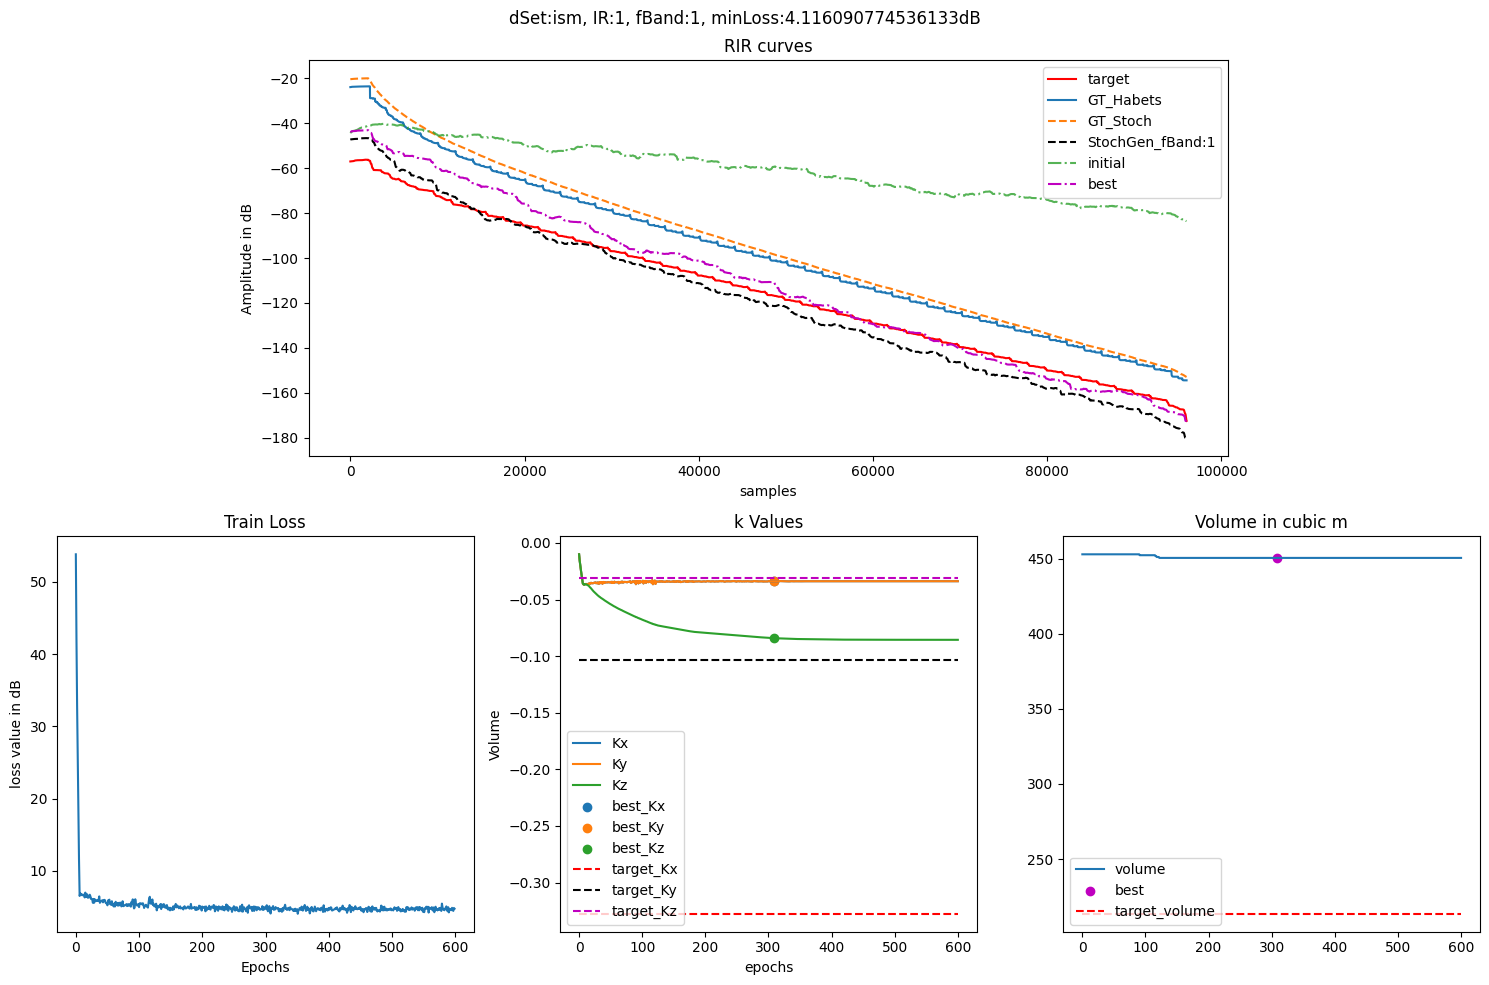

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([698.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 51.0816
Loss in epoch:100 is : 4.3968
Loss in epoch:200 is : 3.8141
Loss in epoch:300 is : 3.8656
Loss in epoch:400 is : 4.5333
Loss in epoch:500 is : 4.1627
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0327, device='cuda:0')
Ky :  tensor(-0.0327, device='cuda:0')
Kz :  tensor(-0.0778, device='cuda:0')
V :  tensor([696.2001], device='cuda:0')
Final model params for band-2: {'Kx': tensor(-0.0327), 'Ky': tensor(-0.0327), 'Kz': tensor(-0.0778), 'V': tensor([696.2001])}
final param: [tensor(-0.0327), tensor(-0.0327), tensor(-0.0778), tensor([696.2001])]
Best params: {'min_loss': tensor(3.4574), 'min_loss_epoch': tensor(525), 'Kx': tensor(-0.0327, device='cuda:0'), 'Ky': tensor(-0.0327, device=

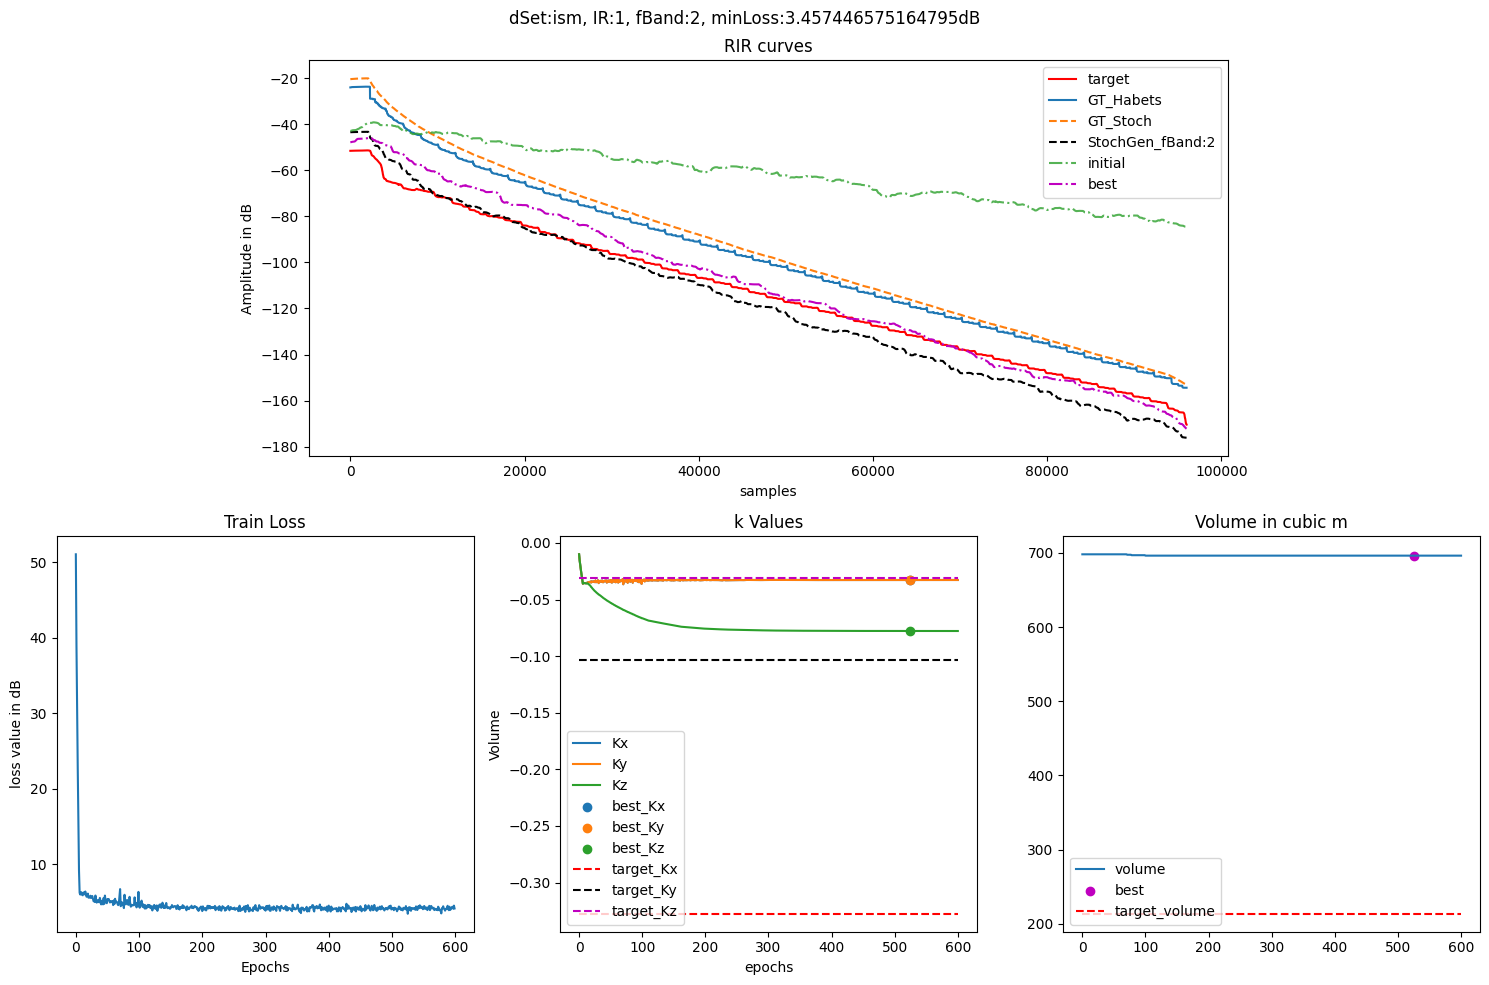

-------- Frequency Band: 3 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([465.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 56.0483
Loss in epoch:100 is : 6.1565
Loss in epoch:200 is : 5.9196
Loss in epoch:300 is : 5.7906
Loss in epoch:400 is : 5.9951
Loss in epoch:500 is : 5.5196
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0349, device='cuda:0')
Ky :  tensor(-0.0349, device='cuda:0')
Kz :  tensor(-0.0805, device='cuda:0')
V :  tensor([465.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.4616), 'min_loss_epoch': tensor(290), 'Kx': tensor(-0.0350, device='cuda:0'), 'Ky': tensor(-0.0350, device='cuda:0'), 'Kz': tensor(-0.0789, device='cuda:0'), 'V': tensor([465.], device='cuda:0')}
Final model params for band-3: {'Kx': tensor(-0.0350), 'Ky': tensor(-0.0350), 'Kz': tensor(-0.07

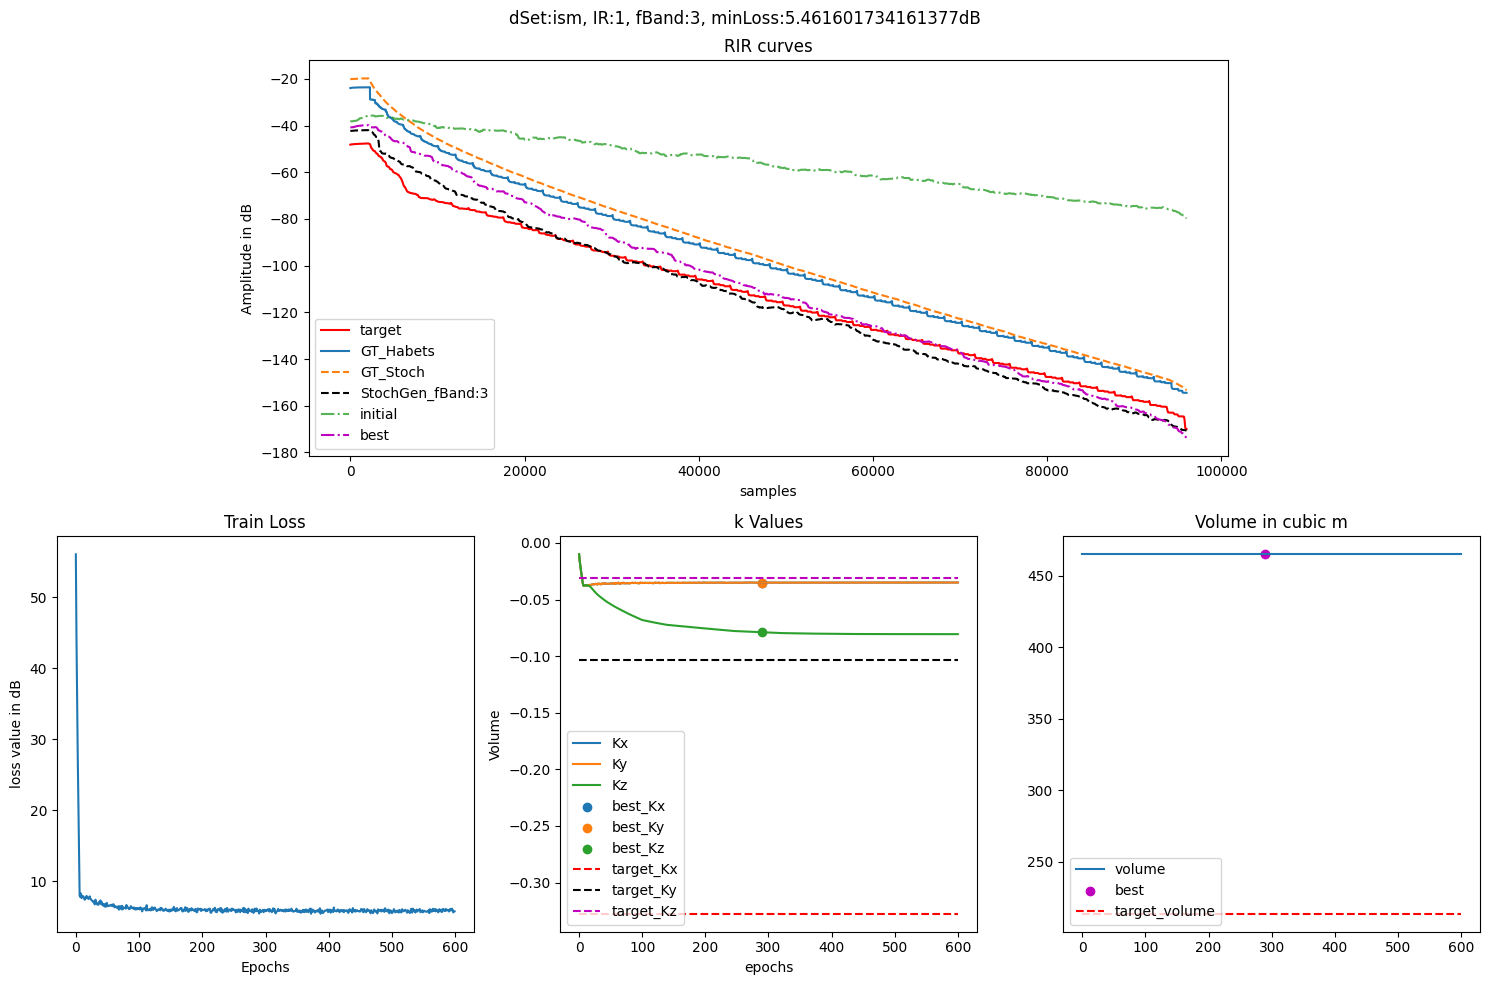

-------- Frequency Band: 4 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([669.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 57.5429
Loss in epoch:100 is : 6.5719
Loss in epoch:200 is : 5.9486
Loss in epoch:300 is : 5.885
Loss in epoch:400 is : 5.9
Loss in epoch:500 is : 5.7868
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0354, device='cuda:0')
Ky :  tensor(-0.0354, device='cuda:0')
Kz :  tensor(-0.0993, device='cuda:0')
V :  tensor([669.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.5864), 'min_loss_epoch': tensor(354), 'Kx': tensor(-0.0352, device='cuda:0'), 'Ky': tensor(-0.0352, device='cuda:0'), 'Kz': tensor(-0.0987, device='cuda:0'), 'V': tensor([669.], device='cuda:0')}
Final model params for band-4: {'Kx': tensor(-0.0352), 'Ky': tensor(-0.0352), 'Kz': tensor(-0.0987),

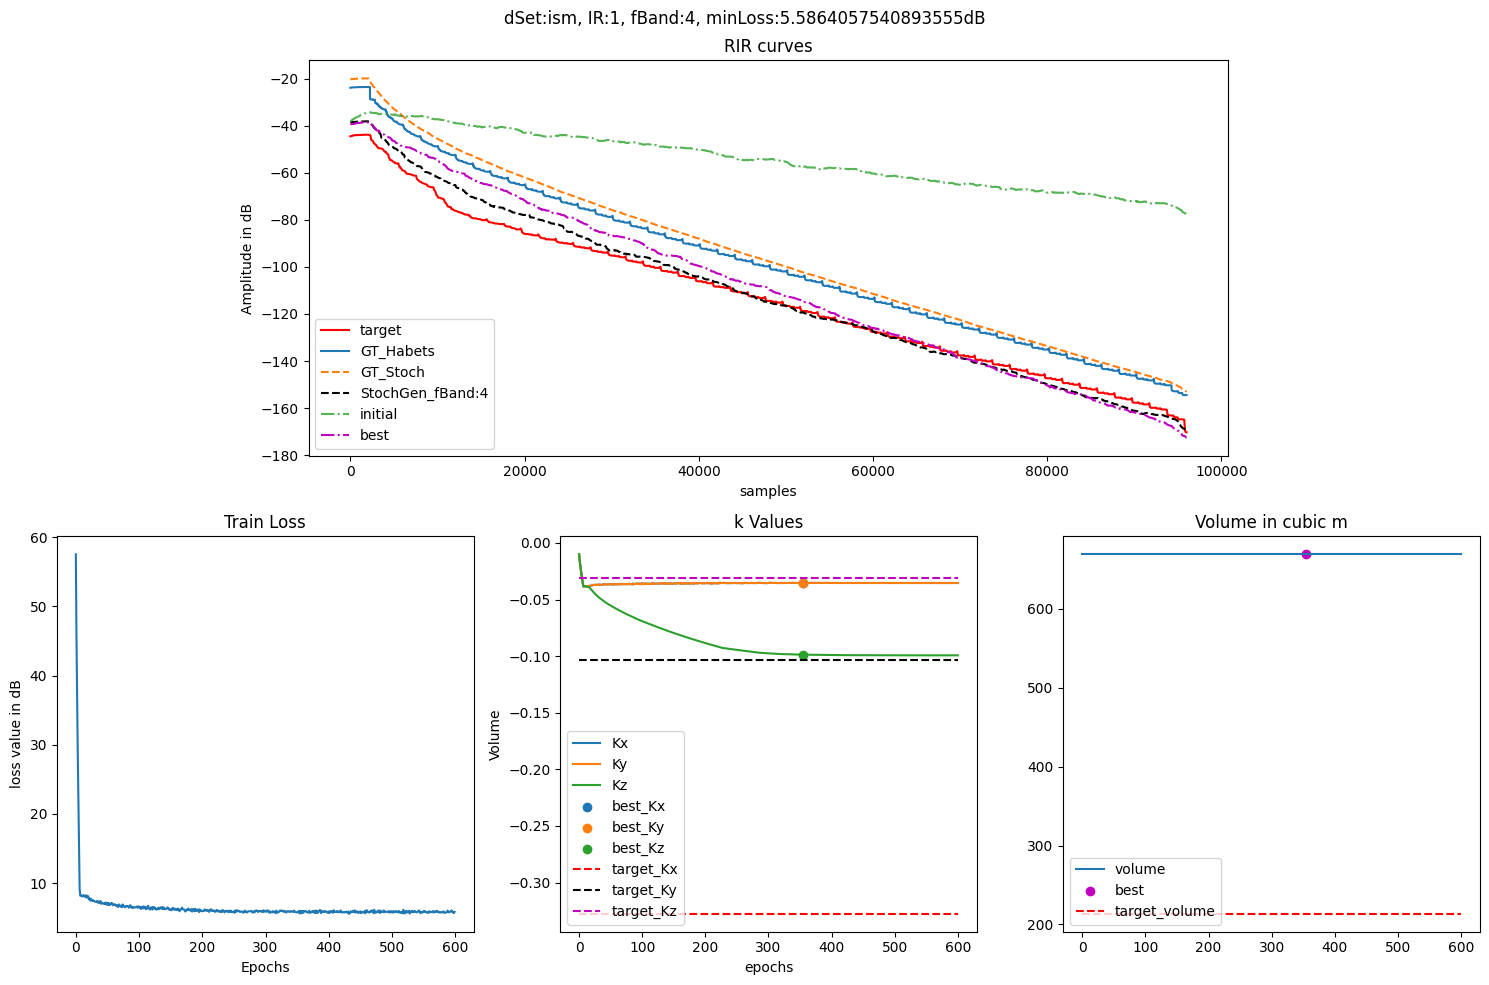

-------- Frequency Band: 5 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([740.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 59.5491
Loss in epoch:100 is : 5.8509
Loss in epoch:200 is : 4.2707
Loss in epoch:300 is : 3.7803
Loss in epoch:400 is : 3.6953
Loss in epoch:500 is : 3.6989
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0941, device='cuda:0')
Ky :  tensor(-0.0941, device='cuda:0')
Kz :  tensor(-0.0323, device='cuda:0')
V :  tensor([725.3006], device='cuda:0')
Final model params for band-5: {'Kx': tensor(-0.0941), 'Ky': tensor(-0.0941), 'Kz': tensor(-0.0323), 'V': tensor([725.3006])}
final param: [tensor(-0.0941), tensor(-0.0941), tensor(-0.0323), tensor([725.3006])]
Best params: {'min_loss': tensor(3.3876), 'min_loss_epoch': tensor(582), 'Kx': tensor(-0.0940, device='cuda:0'), 'Ky': tensor(-0.0940, device=

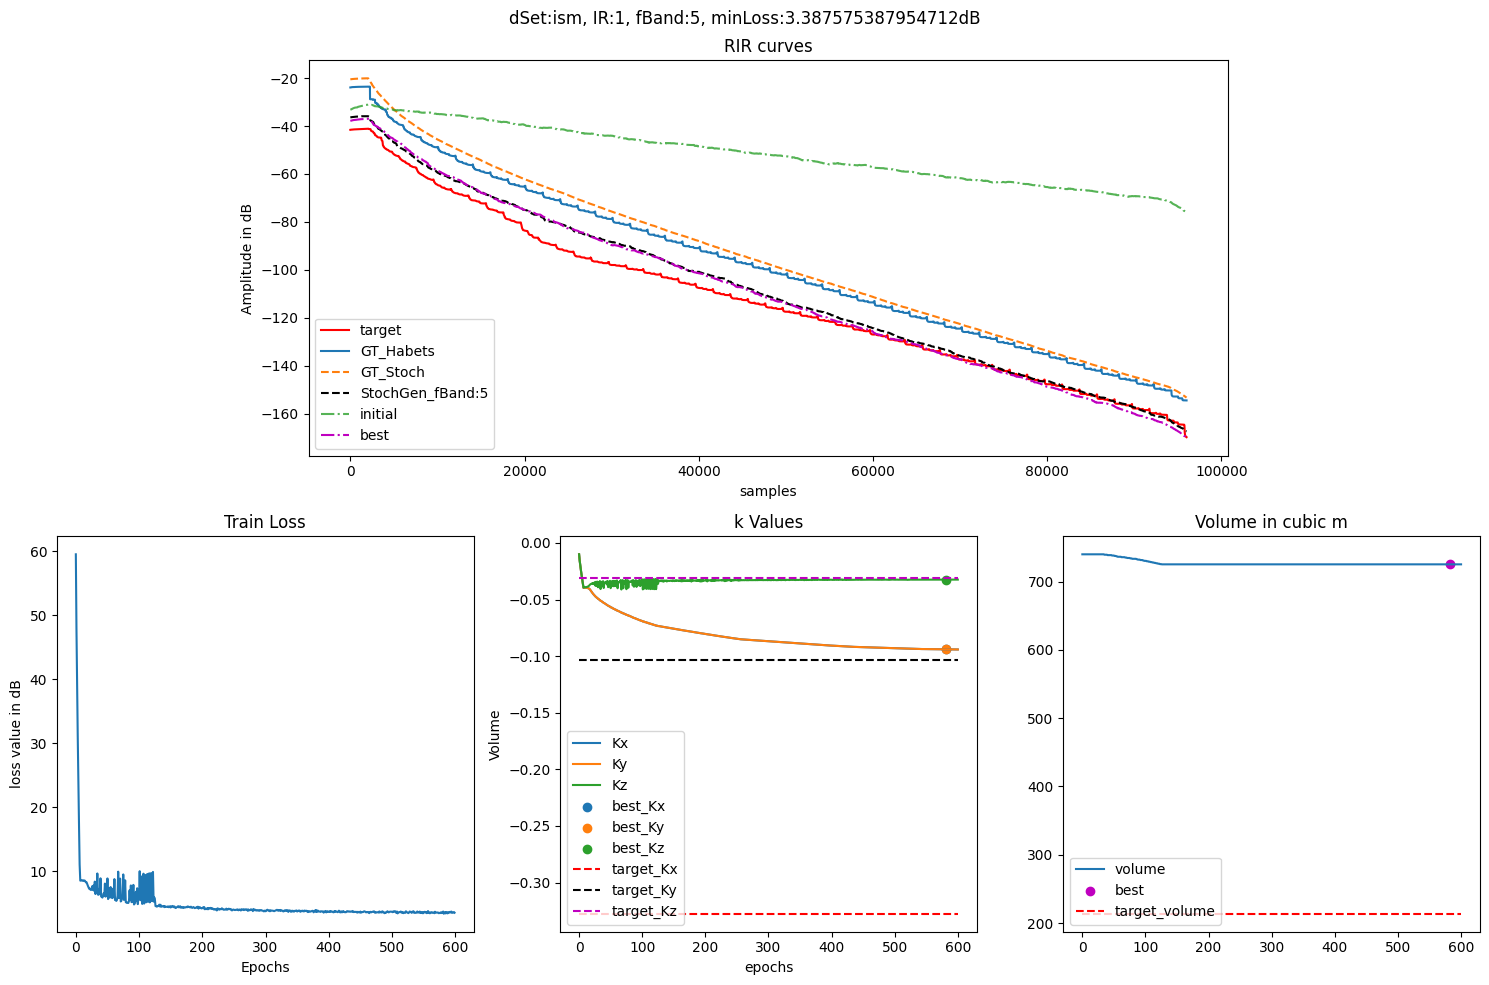

-------- Frequency Band: 6 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([165.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 65.9757
Loss in epoch:100 is : 7.3941
Loss in epoch:200 is : 6.8907
Loss in epoch:300 is : 6.6015
Loss in epoch:400 is : 6.3941
Loss in epoch:500 is : 6.2759
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0396, device='cuda:0')
Ky :  tensor(-0.0396, device='cuda:0')
Kz :  tensor(-0.1370, device='cuda:0')
V :  tensor([165.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(6.1113), 'min_loss_epoch': tensor(560), 'Kx': tensor(-0.0396, device='cuda:0'), 'Ky': tensor(-0.0396, device='cuda:0'), 'Kz': tensor(-0.1333, device='cuda:0'), 'V': tensor([165.], device='cuda:0')}
Final model params for band-6: {'Kx': tensor(-0.0396), 'Ky': tensor(-0.0396), 'Kz': tensor(-0.13

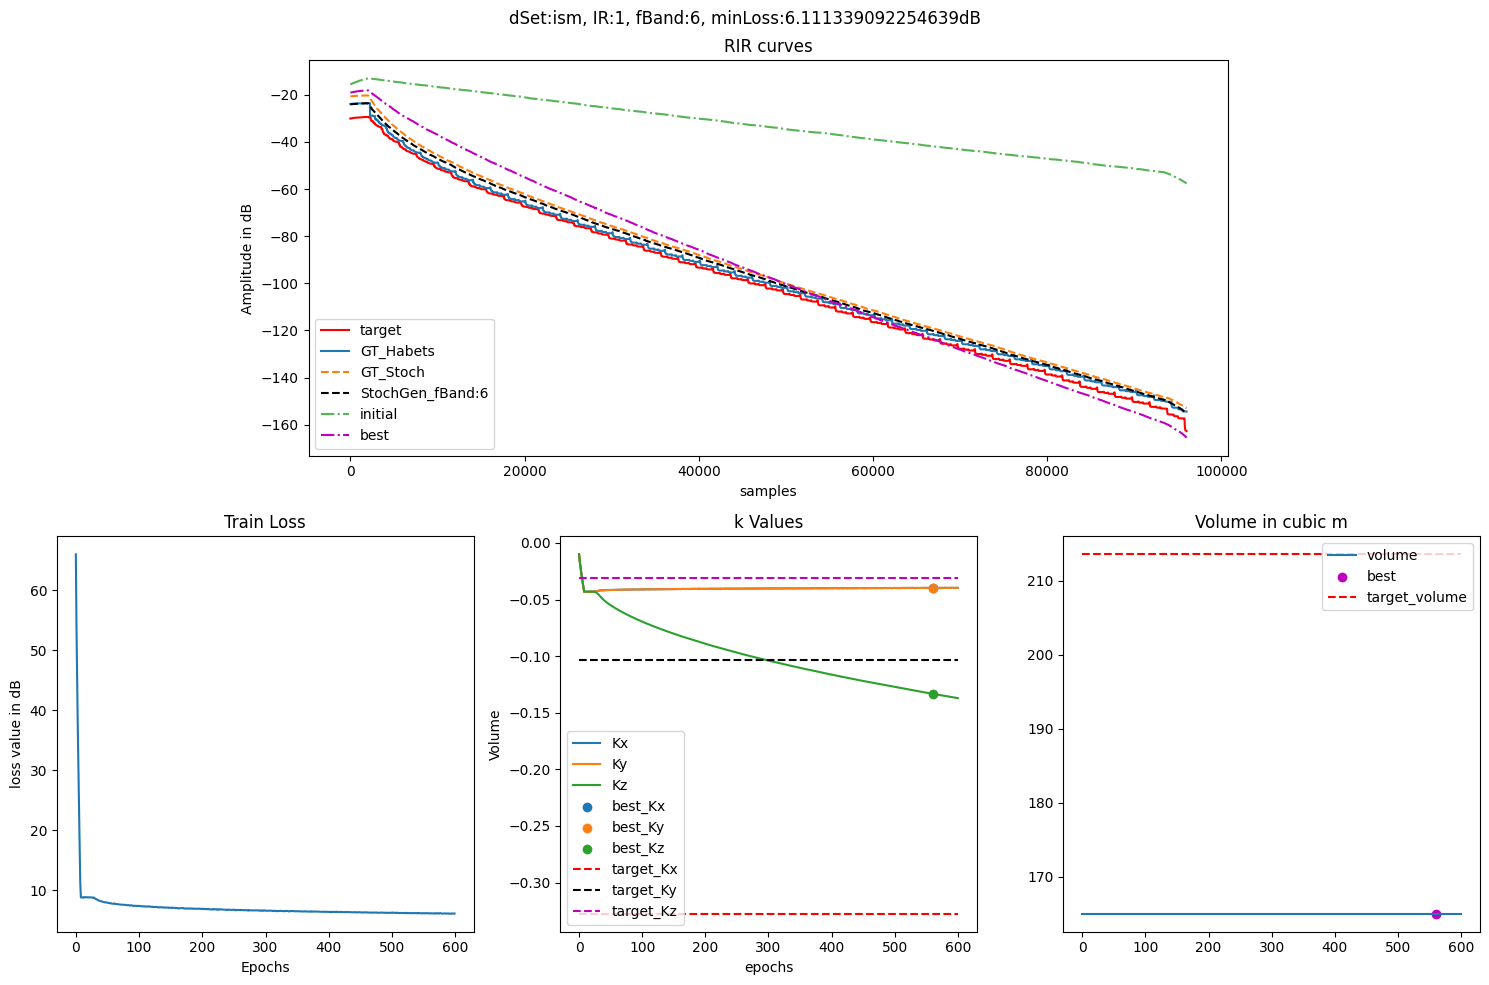

################################### 
 K values for all Bands: 
 ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss'] 
tensor([[-3.3763e-02, -3.3763e-02, -8.5549e-02,  4.5060e+02,  1.0000e+00,
          4.1161e+00],
        [-3.2695e-02, -3.2695e-02, -7.7762e-02,  6.9620e+02,  1.0000e+00,
          3.4574e+00],
        [-3.5024e-02, -3.5024e-02, -7.8861e-02,  4.6500e+02,  1.0000e+00,
          5.4616e+00],
        [-3.5233e-02, -3.5233e-02, -9.8658e-02,  6.6900e+02,  1.0000e+00,
          5.5864e+00],
        [-9.4069e-02, -9.4069e-02, -3.2346e-02,  7.2530e+02,  1.0000e+00,
          3.3876e+00],
        [-3.9587e-02, -3.9587e-02, -1.3334e-01,  1.6500e+02,  1.0000e+00,
          6.1113e+00]])
 Converged for 6 bands 
 ################################### 
---------------- Datapoint number: 2 out of 6 ----------------
Target Kvalues: tensor([7.7000, 6.0000, 4.9000]), tensor([-0.6621, -0.2727, -0.0460]), 226.37998962402344
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Ini

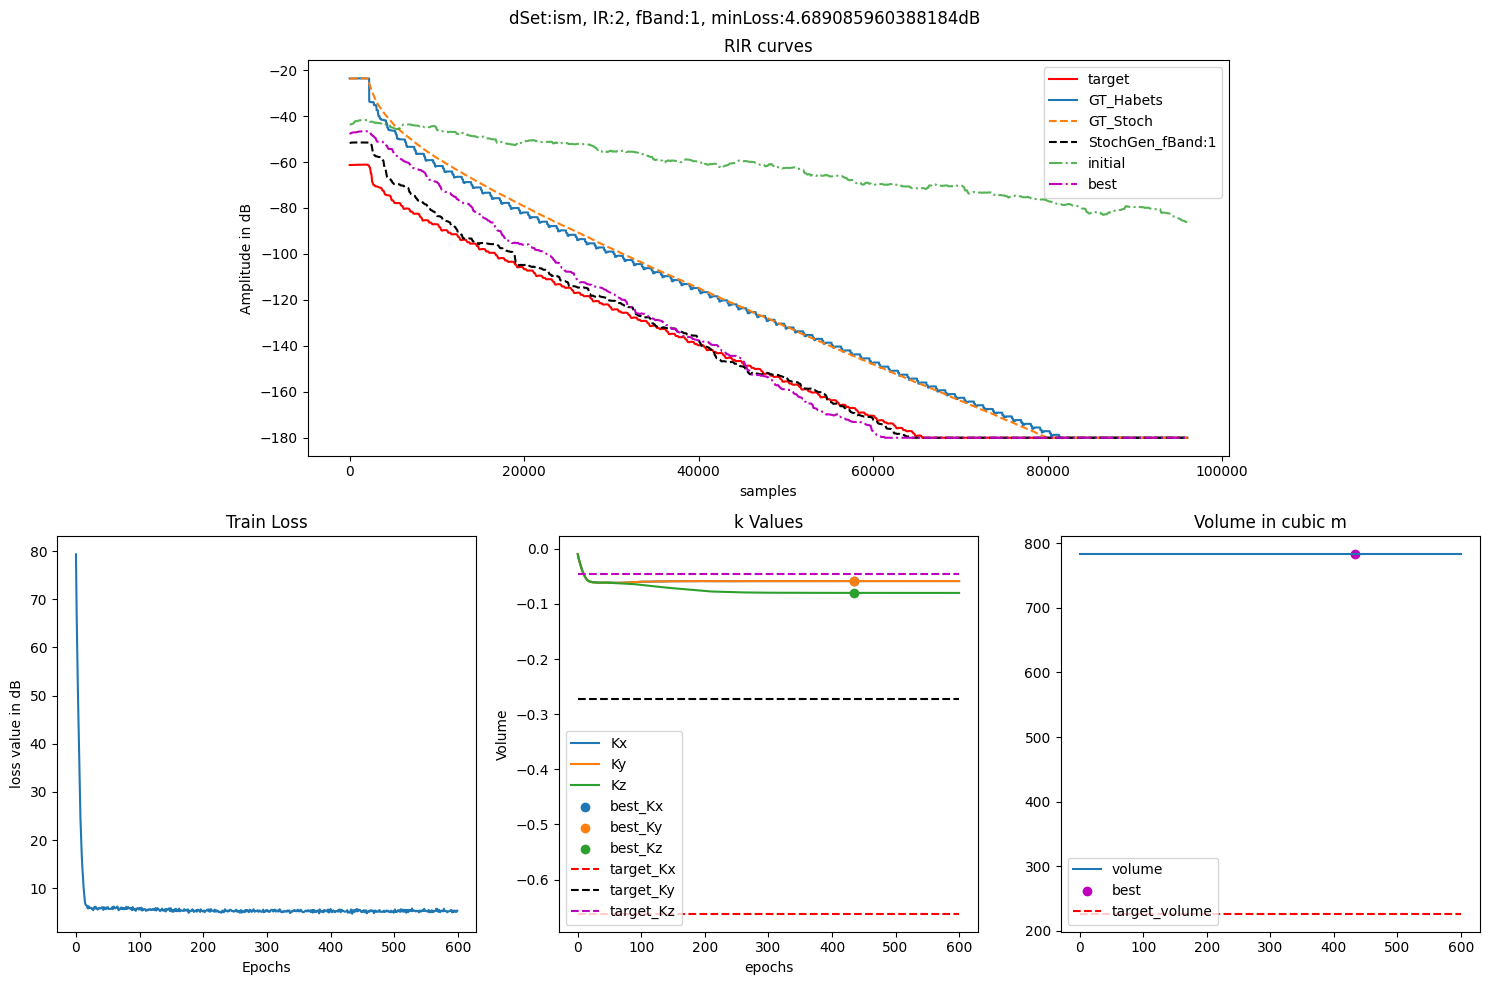

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([474.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 76.7293
Loss in epoch:100 is : 4.8509
Loss in epoch:200 is : 4.9307
Loss in epoch:300 is : 4.9936
Loss in epoch:400 is : 4.9043
Loss in epoch:500 is : 4.5559
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0537, device='cuda:0')
Ky :  tensor(-0.0537, device='cuda:0')
Kz :  tensor(-0.0721, device='cuda:0')
V :  tensor([474.], device='cuda:0')
Final model params for band-2: {'Kx': tensor(-0.0537), 'Ky': tensor(-0.0537), 'Kz': tensor(-0.0721), 'V': tensor([474.])}
final param: [tensor(-0.0537), tensor(-0.0537), tensor(-0.0721), tensor([474.])]
Best params: {'min_loss': tensor(4.3399), 'min_loss_epoch': tensor(573), 'Kx': tensor(-0.0537, device='cuda:0'), 'Ky': tensor(-0.0537, device='cuda:0'), '

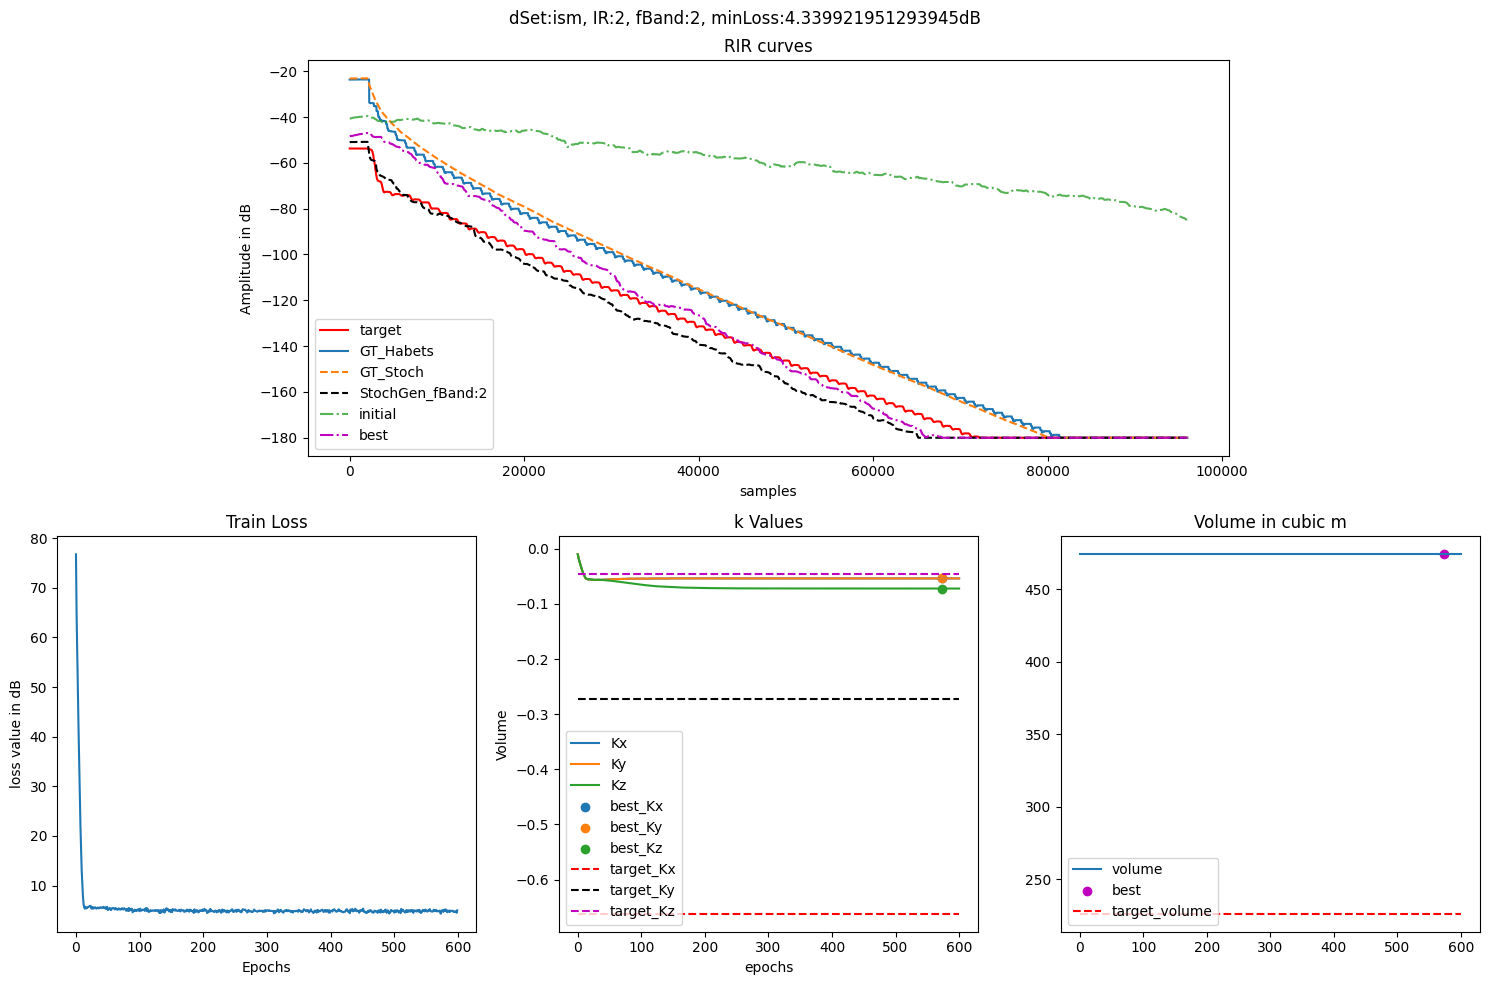

-------- Frequency Band: 3 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([507.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 80.1954
Loss in epoch:100 is : 6.1006
Loss in epoch:200 is : 5.6471
Loss in epoch:300 is : 5.5146
Loss in epoch:400 is : 5.7044
Loss in epoch:500 is : 5.3968
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0550, device='cuda:0')
Ky :  tensor(-0.0550, device='cuda:0')
Kz :  tensor(-0.0952, device='cuda:0')
V :  tensor([507.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.1551), 'min_loss_epoch': tensor(369), 'Kx': tensor(-0.0551, device='cuda:0'), 'Ky': tensor(-0.0551, device='cuda:0'), 'Kz': tensor(-0.0950, device='cuda:0'), 'V': tensor([507.], device='cuda:0')}
Final model params for band-3: {'Kx': tensor(-0.0551), 'Ky': tensor(-0.0551), 'Kz': tensor(-0.09

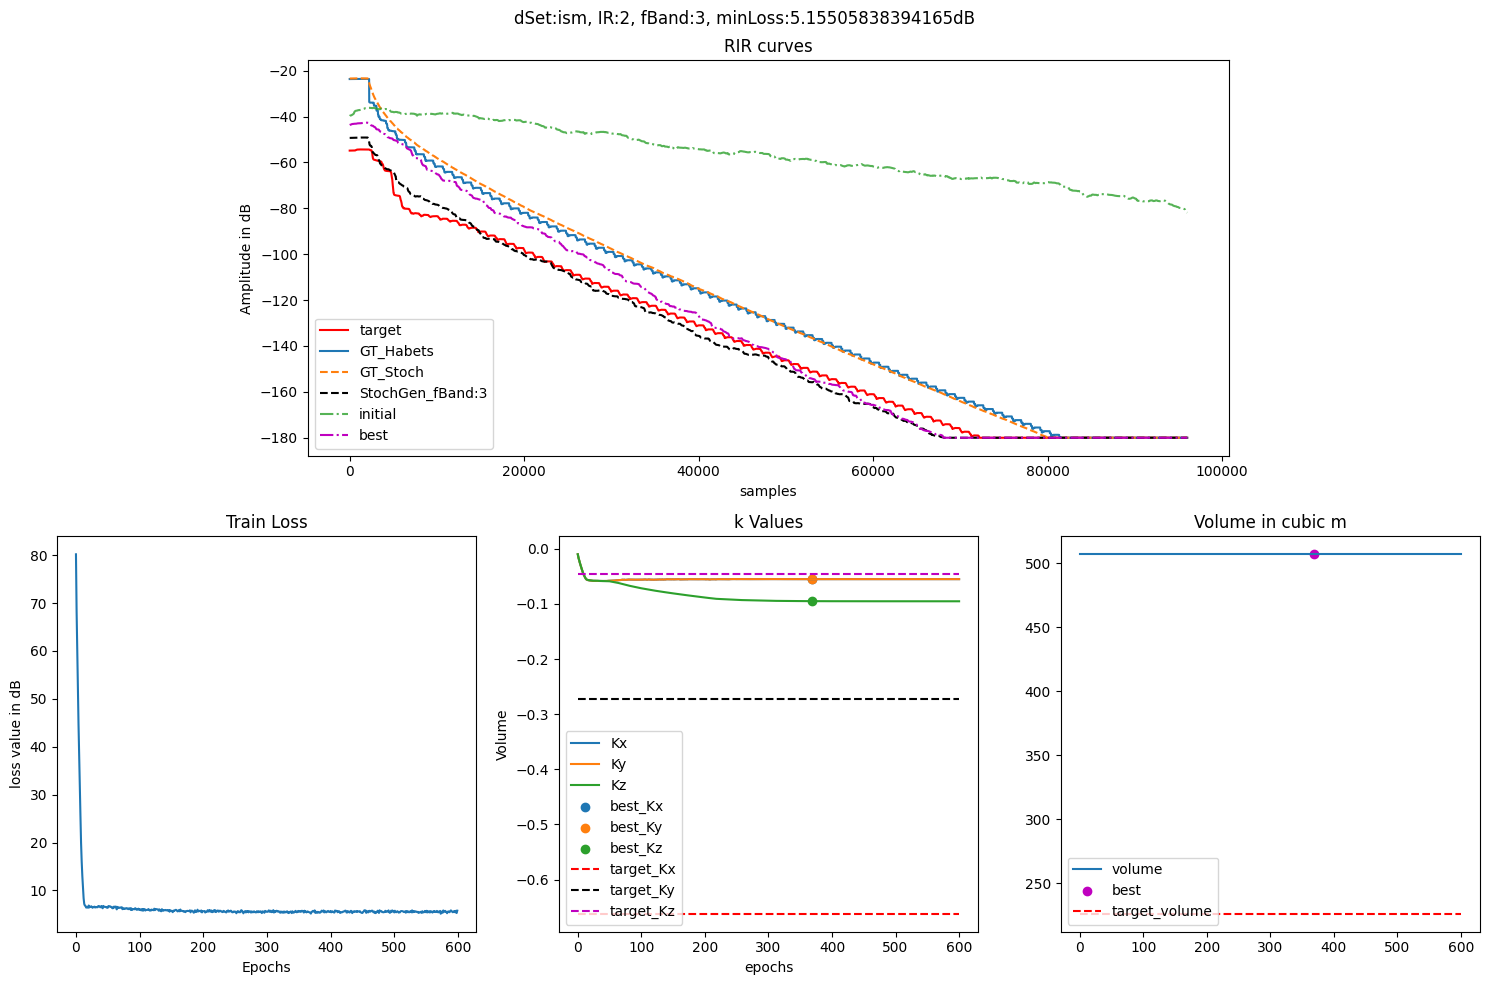

-------- Frequency Band: 4 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([714.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 80.8711
Loss in epoch:100 is : 6.158
Loss in epoch:200 is : 6.143
Loss in epoch:300 is : 6.1519
Loss in epoch:400 is : 6.2068
Loss in epoch:500 is : 6.0897
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0558, device='cuda:0')
Ky :  tensor(-0.0558, device='cuda:0')
Kz :  tensor(-0.0788, device='cuda:0')
V :  tensor([714.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.8748), 'min_loss_epoch': tensor(349), 'Kx': tensor(-0.0557, device='cuda:0'), 'Ky': tensor(-0.0557, device='cuda:0'), 'Kz': tensor(-0.0785, device='cuda:0'), 'V': tensor([714.], device='cuda:0')}
Final model params for band-4: {'Kx': tensor(-0.0557), 'Ky': tensor(-0.0557), 'Kz': tensor(-0.0785

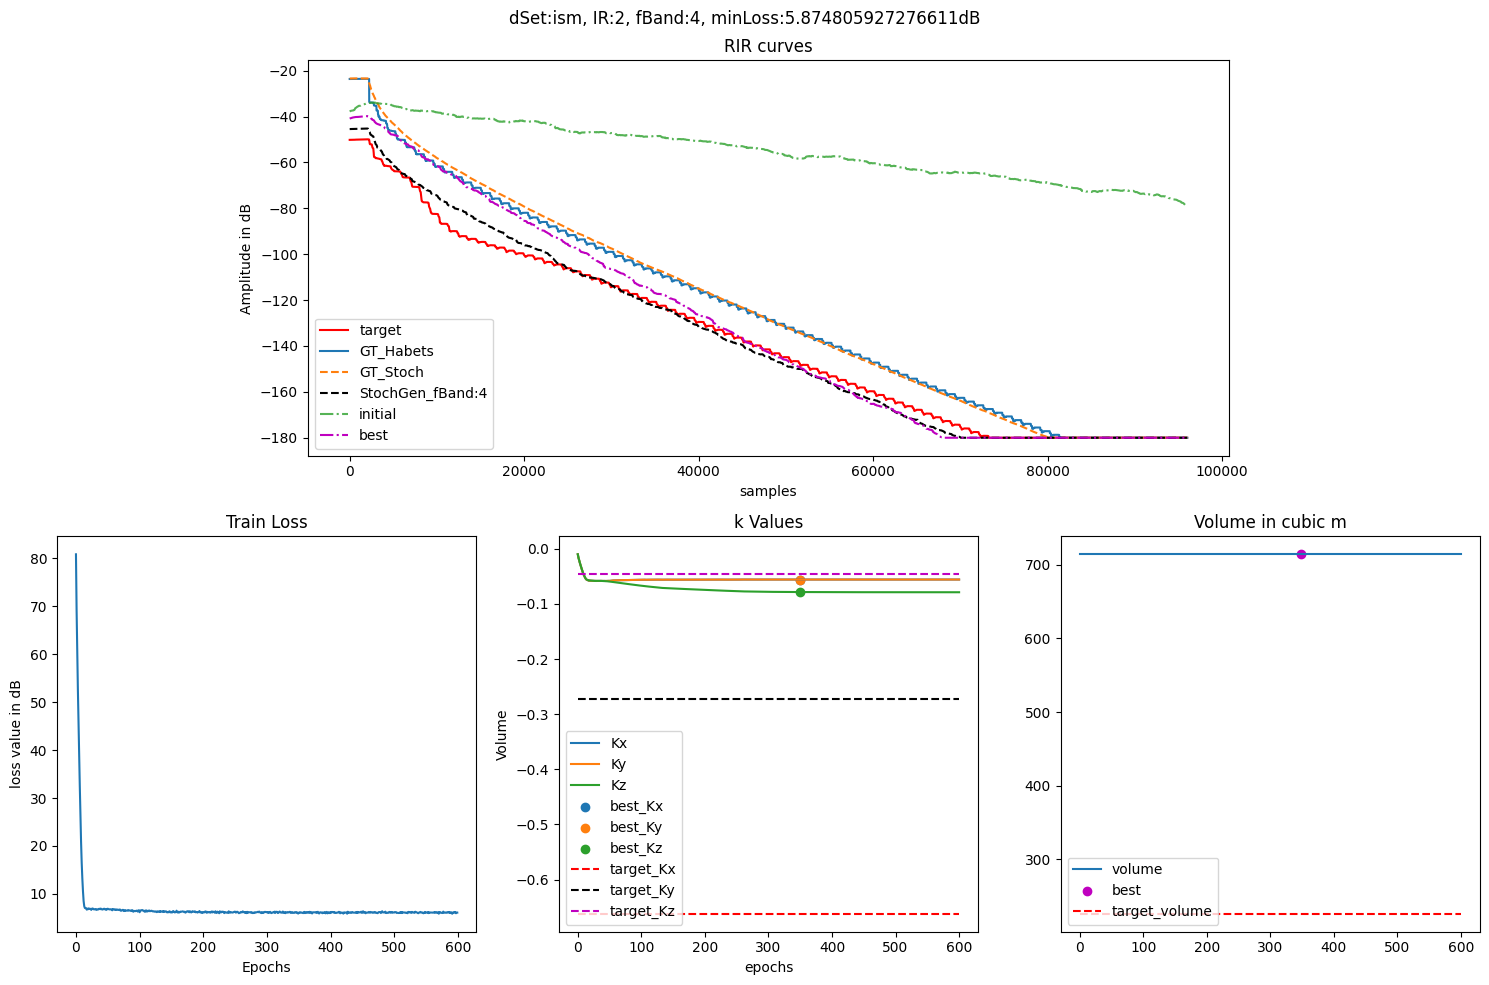

-------- Frequency Band: 5 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([554.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 84.8254
Loss in epoch:100 is : 7.5422
Loss in epoch:200 is : 7.2679
Loss in epoch:300 is : 7.145
Loss in epoch:400 is : 7.0578
Loss in epoch:500 is : 7.0906
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0579, device='cuda:0')
Ky :  tensor(-0.0579, device='cuda:0')
Kz :  tensor(-0.1008, device='cuda:0')
V :  tensor([554.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(6.8115), 'min_loss_epoch': tensor(290), 'Kx': tensor(-0.0579, device='cuda:0'), 'Ky': tensor(-0.0579, device='cuda:0'), 'Kz': tensor(-0.0990, device='cuda:0'), 'V': tensor([554.], device='cuda:0')}
Final model params for band-5: {'Kx': tensor(-0.0579), 'Ky': tensor(-0.0579), 'Kz': tensor(-0.099

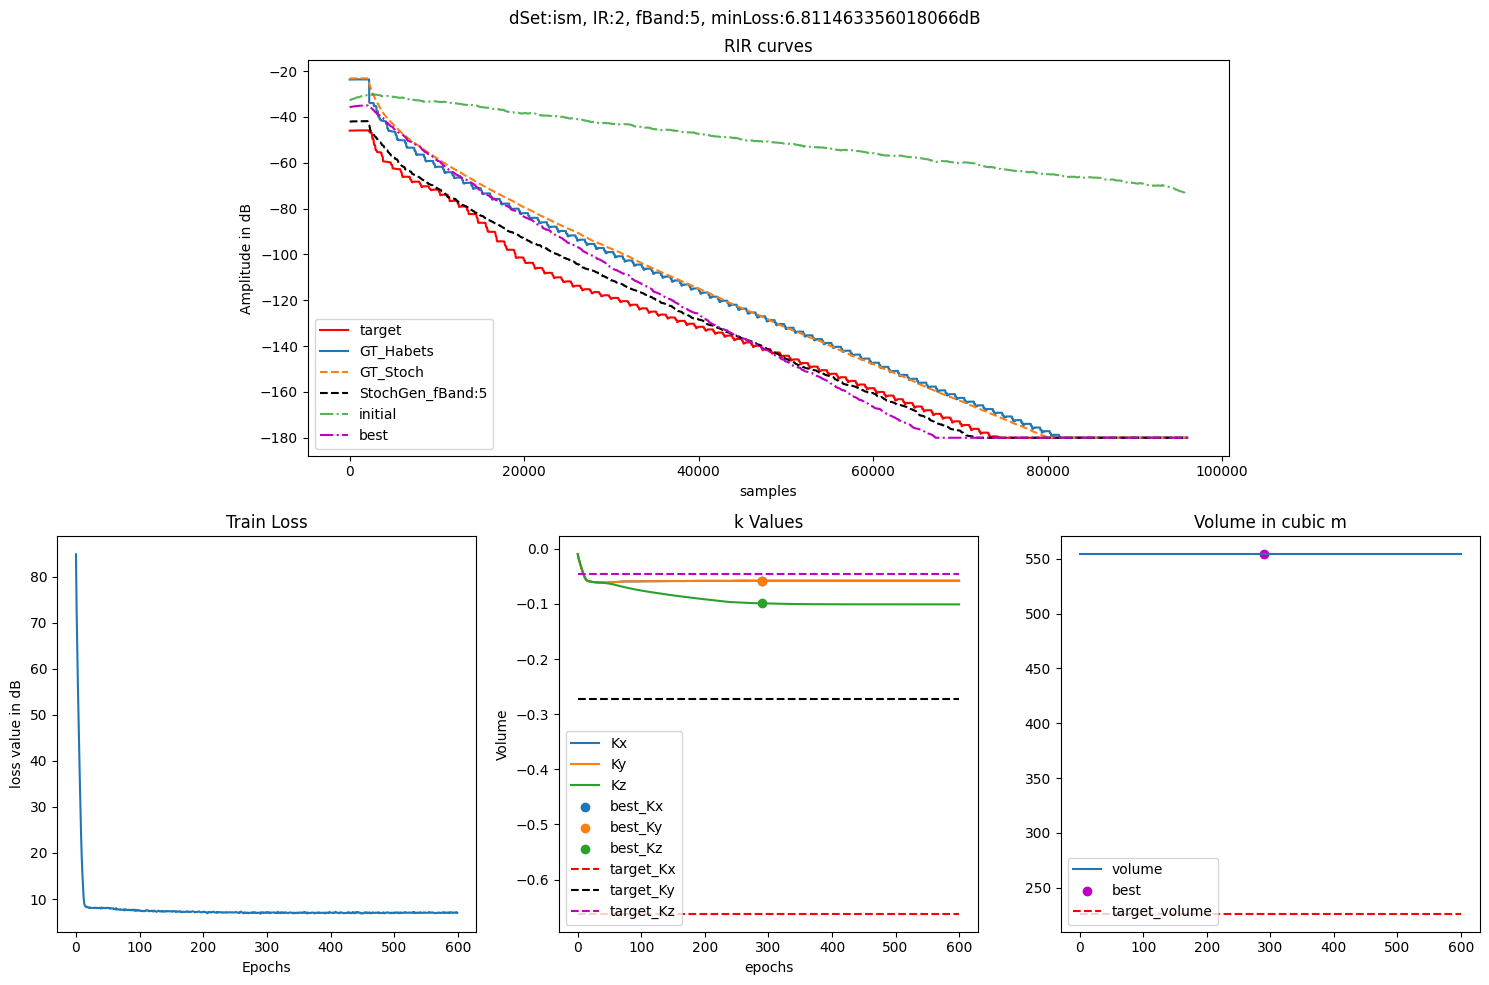

-------- Frequency Band: 6 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([438.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 87.5459
Loss in epoch:100 is : 5.4963
Loss in epoch:200 is : 4.6693
Loss in epoch:300 is : 4.2851
Loss in epoch:400 is : 3.9506
Loss in epoch:500 is : 3.7093
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1343, device='cuda:0')
Ky :  tensor(-0.1343, device='cuda:0')
Kz :  tensor(-0.0509, device='cuda:0')
V :  tensor([438.], device='cuda:0')
Final model params for band-6: {'Kx': tensor(-0.1343), 'Ky': tensor(-0.1343), 'Kz': tensor(-0.0509), 'V': tensor([438.])}
final param: [tensor(-0.1343), tensor(-0.1343), tensor(-0.0509), tensor([438.])]
Best params: {'min_loss': tensor(3.5159), 'min_loss_epoch': tensor(578), 'Kx': tensor(-0.1326, device='cuda:0'), 'Ky': tensor(-0.1326, device='cuda:0'), '

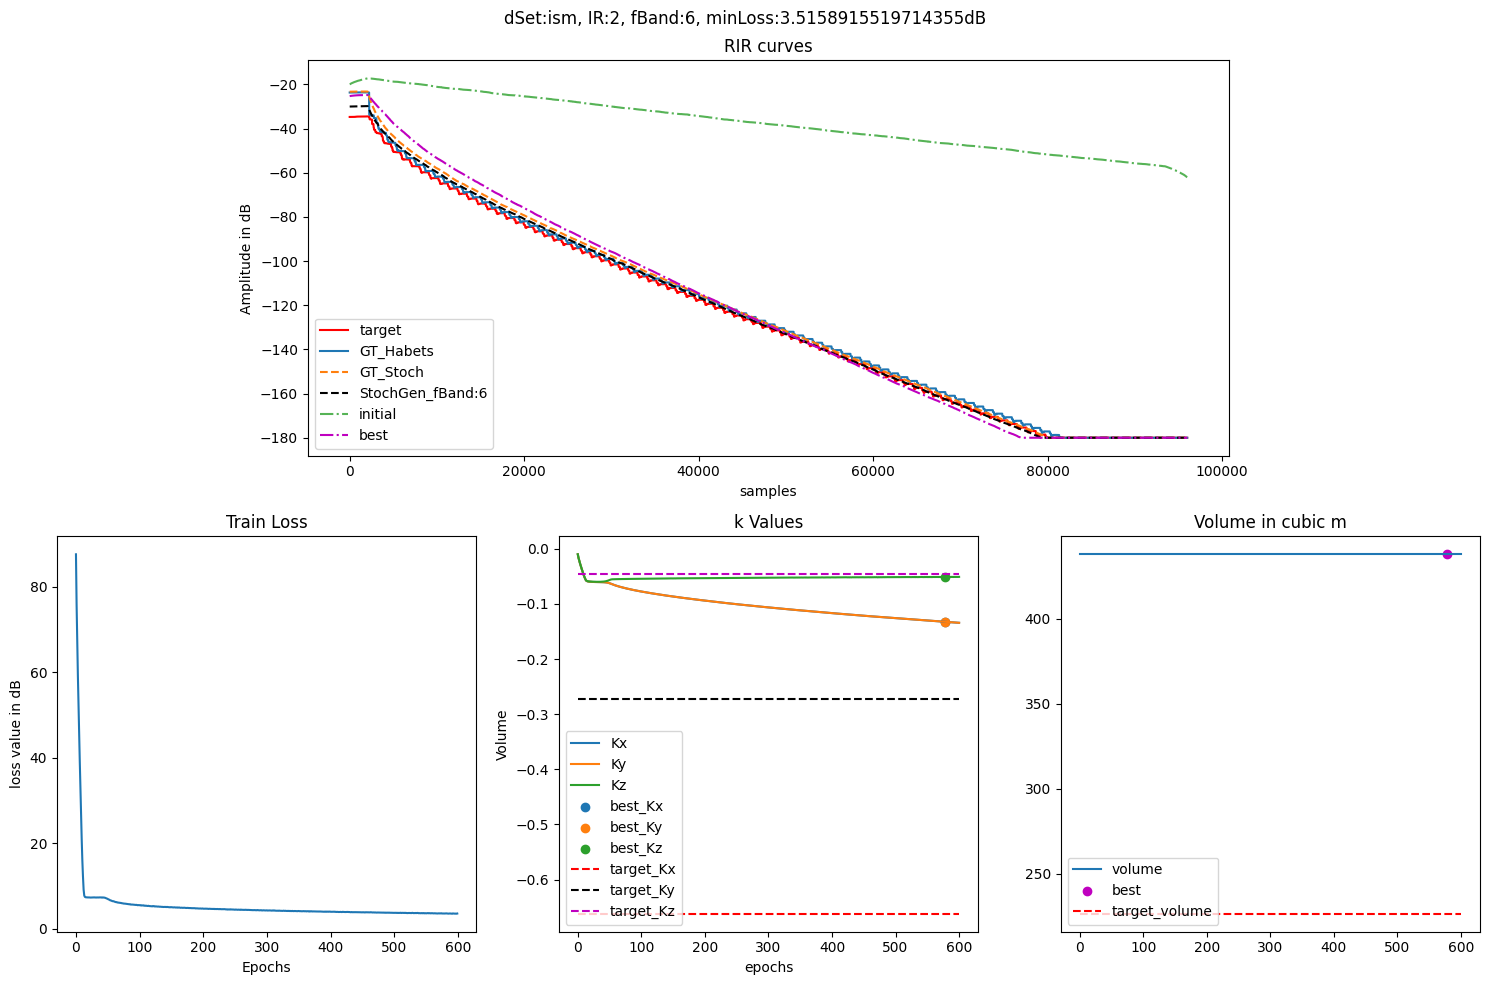

################################### 
 K values for all Bands: 
 ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss'] 
tensor([[-5.8575e-02, -5.8575e-02, -8.0065e-02,  7.8300e+02,  1.0000e+00,
          4.6891e+00],
        [-5.3742e-02, -5.3742e-02, -7.2098e-02,  4.7400e+02,  1.0000e+00,
          4.3399e+00],
        [-5.5063e-02, -5.5063e-02, -9.4979e-02,  5.0700e+02,  1.0000e+00,
          5.1551e+00],
        [-5.5743e-02, -5.5743e-02, -7.8460e-02,  7.1400e+02,  1.0000e+00,
          5.8748e+00],
        [-5.7937e-02, -5.7937e-02, -9.9009e-02,  5.5400e+02,  1.0000e+00,
          6.8115e+00],
        [-1.3425e-01, -1.3425e-01, -5.0940e-02,  4.3800e+02,  1.0000e+00,
          3.5159e+00]])
 Converged for 6 bands 
 ################################### 
---------------- Datapoint number: 3 out of 6 ----------------
Target Kvalues: tensor([7.8000, 7.9000, 5.7000]), tensor([-0.3041, -0.0574, -0.0412]), 351.2340087890625
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Init

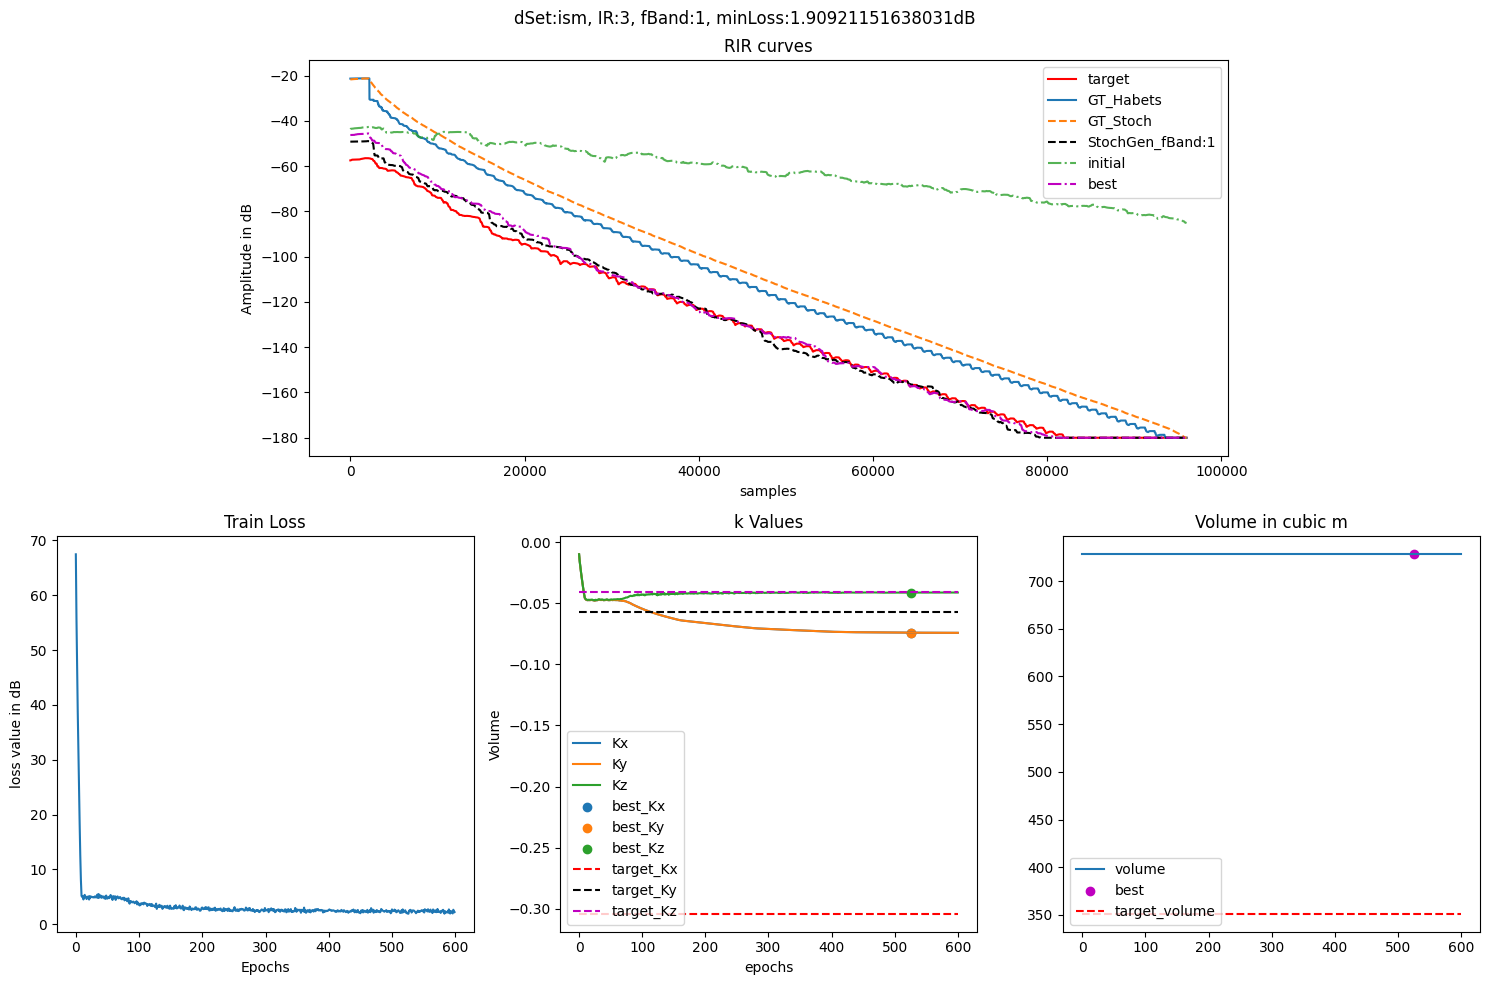

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([130.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 78.5061
Loss in epoch:100 is : 6.6219
Loss in epoch:200 is : 6.5368
Loss in epoch:300 is : 6.3486
Loss in epoch:400 is : 6.4714
Loss in epoch:500 is : 6.4015
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0524, device='cuda:0')
Ky :  tensor(-0.0524, device='cuda:0')
Kz :  tensor(-0.0857, device='cuda:0')
V :  tensor([130.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.8955), 'min_loss_epoch': tensor(349), 'Kx': tensor(-0.0524, device='cuda:0'), 'Ky': tensor(-0.0524, device='cuda:0'), 'Kz': tensor(-0.0855, device='cuda:0'), 'V': tensor([130.], device='cuda:0')}
Final model params for band-2: {'Kx': tensor(-0.0524), 'Ky': tensor(-0.0524), 'Kz': tensor(-0.08

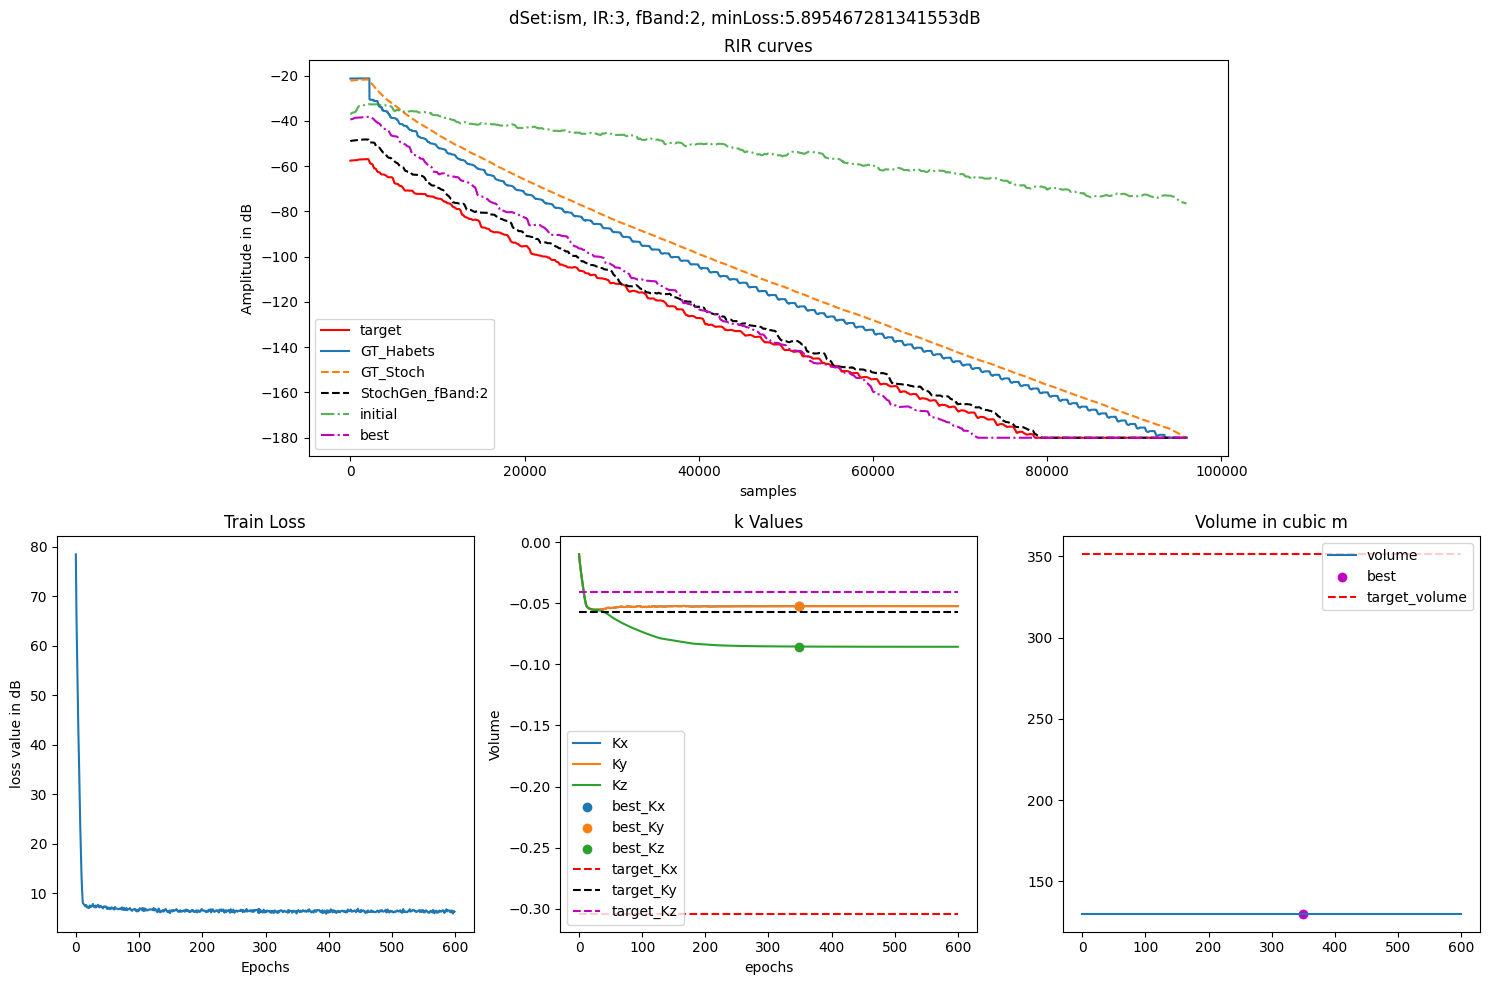

-------- Frequency Band: 3 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([508.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 70.1426
Loss in epoch:100 is : 4.3738
Loss in epoch:200 is : 4.2037
Loss in epoch:300 is : 4.1022
Loss in epoch:400 is : 3.8285
Loss in epoch:500 is : 3.6966
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0449, device='cuda:0')
Ky :  tensor(-0.0449, device='cuda:0')
Kz :  tensor(-0.0994, device='cuda:0')
V :  tensor([508.], device='cuda:0')
Final model params for band-3: {'Kx': tensor(-0.0449), 'Ky': tensor(-0.0449), 'Kz': tensor(-0.0994), 'V': tensor([508.])}
final param: [tensor(-0.0449), tensor(-0.0449), tensor(-0.0994), tensor([508.])]
Best params: {'min_loss': tensor(3.6113), 'min_loss_epoch': tensor(355), 'Kx': tensor(-0.0449, device='cuda:0'), 'Ky': tensor(-0.0449, device='cuda:0'), '

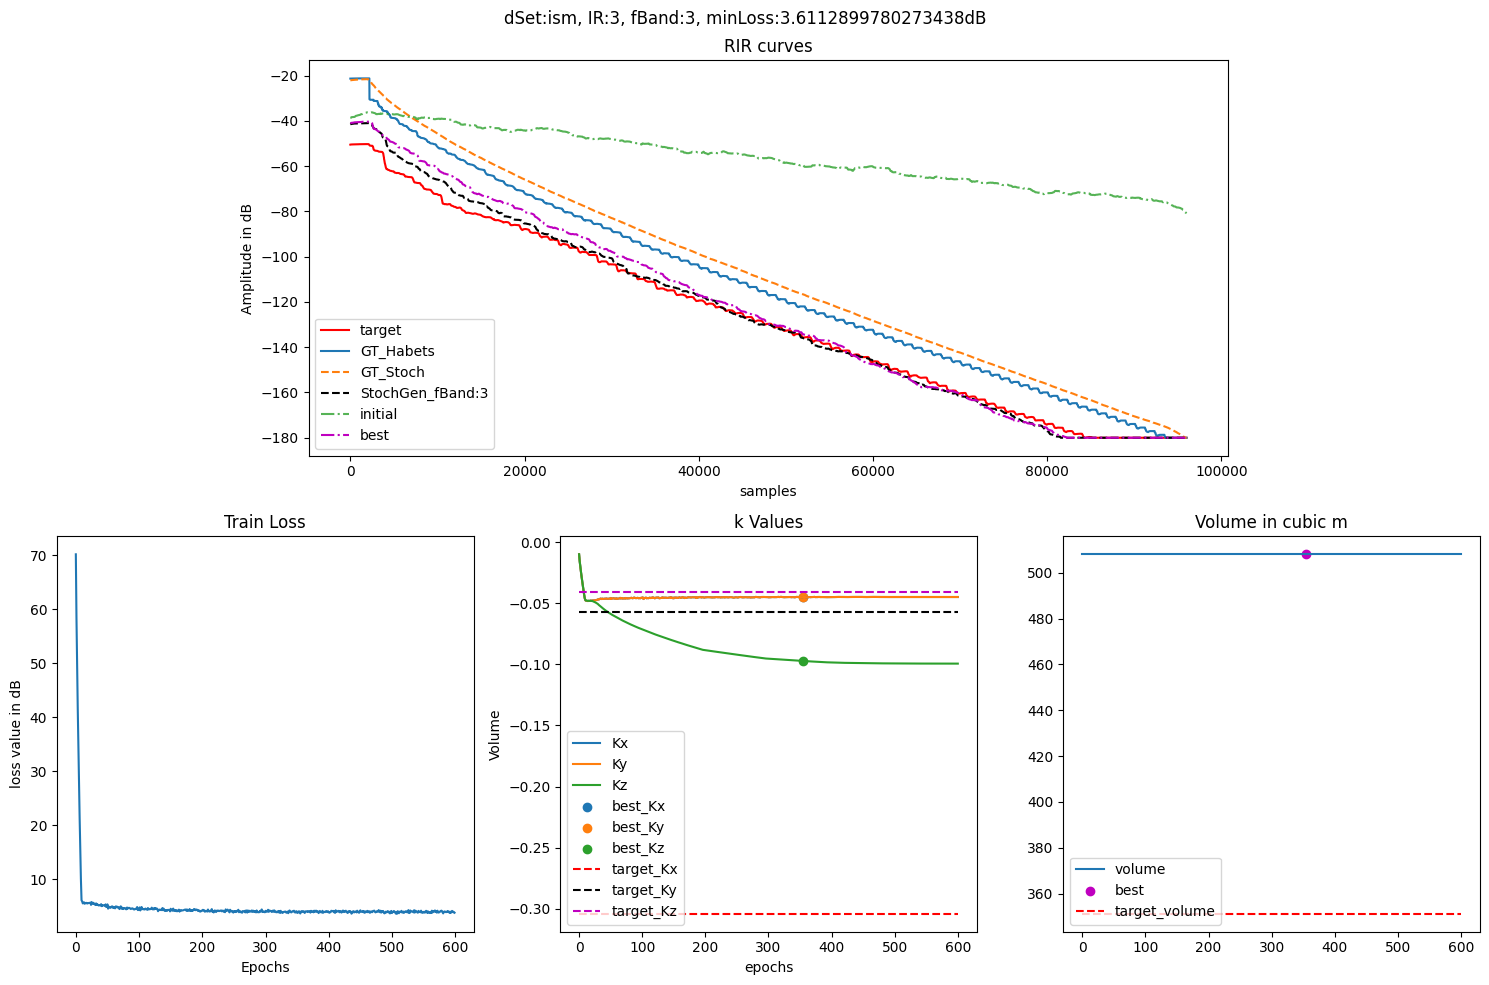

-------- Frequency Band: 4 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([605.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 71.9413
Loss in epoch:100 is : 4.5038
Loss in epoch:200 is : 3.5424
Loss in epoch:300 is : 3.2859
Loss in epoch:400 is : 2.8209
Loss in epoch:500 is : 2.5451
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0937, device='cuda:0')
Ky :  tensor(-0.0937, device='cuda:0')
Kz :  tensor(-0.0419, device='cuda:0')
V :  tensor([602.9001], device='cuda:0')
Final model params for band-4: {'Kx': tensor(-0.0937), 'Ky': tensor(-0.0937), 'Kz': tensor(-0.0419), 'V': tensor([602.9001])}
final param: [tensor(-0.0937), tensor(-0.0937), tensor(-0.0419), tensor([602.9001])]
Best params: {'min_loss': tensor(2.3952), 'min_loss_epoch': tensor(462), 'Kx': tensor(-0.0918, device='cuda:0'), 'Ky': tensor(-0.0918, device=

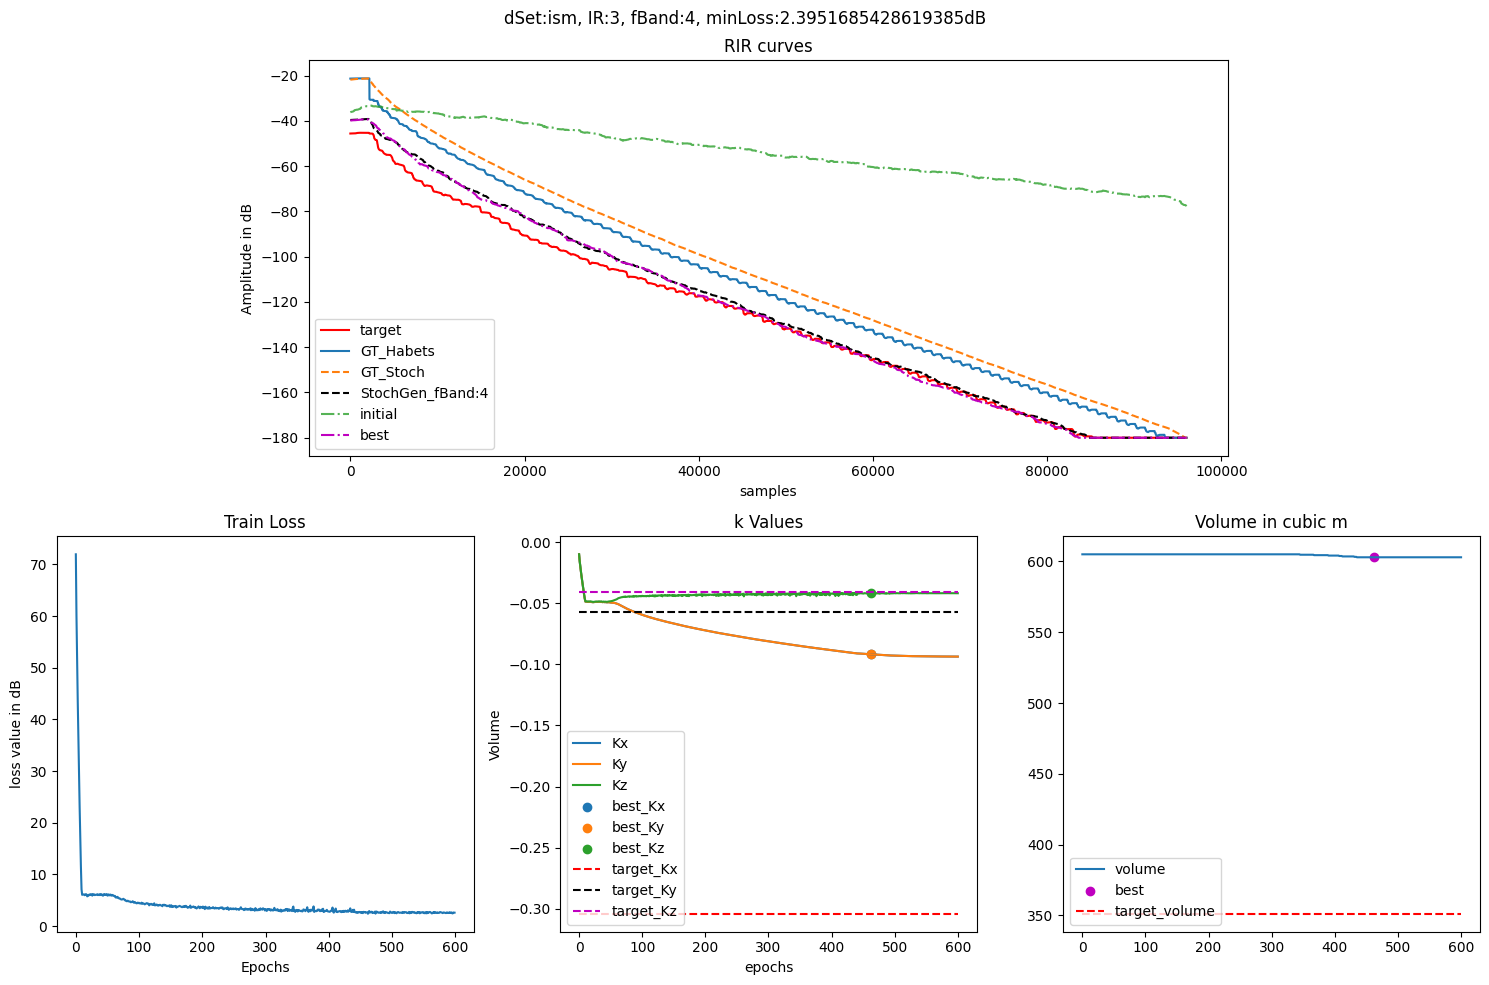

-------- Frequency Band: 5 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([483.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 75.3309
Loss in epoch:100 is : 5.8177
Loss in epoch:200 is : 5.4497
Loss in epoch:300 is : 5.5054
Loss in epoch:400 is : 5.4413
Loss in epoch:500 is : 5.4255
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0492, device='cuda:0')
Ky :  tensor(-0.0492, device='cuda:0')
Kz :  tensor(-0.0923, device='cuda:0')
V :  tensor([483.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.1997), 'min_loss_epoch': tensor(356), 'Kx': tensor(-0.0492, device='cuda:0'), 'Ky': tensor(-0.0492, device='cuda:0'), 'Kz': tensor(-0.0912, device='cuda:0'), 'V': tensor([483.], device='cuda:0')}
Final model params for band-5: {'Kx': tensor(-0.0492), 'Ky': tensor(-0.0492), 'Kz': tensor(-0.09

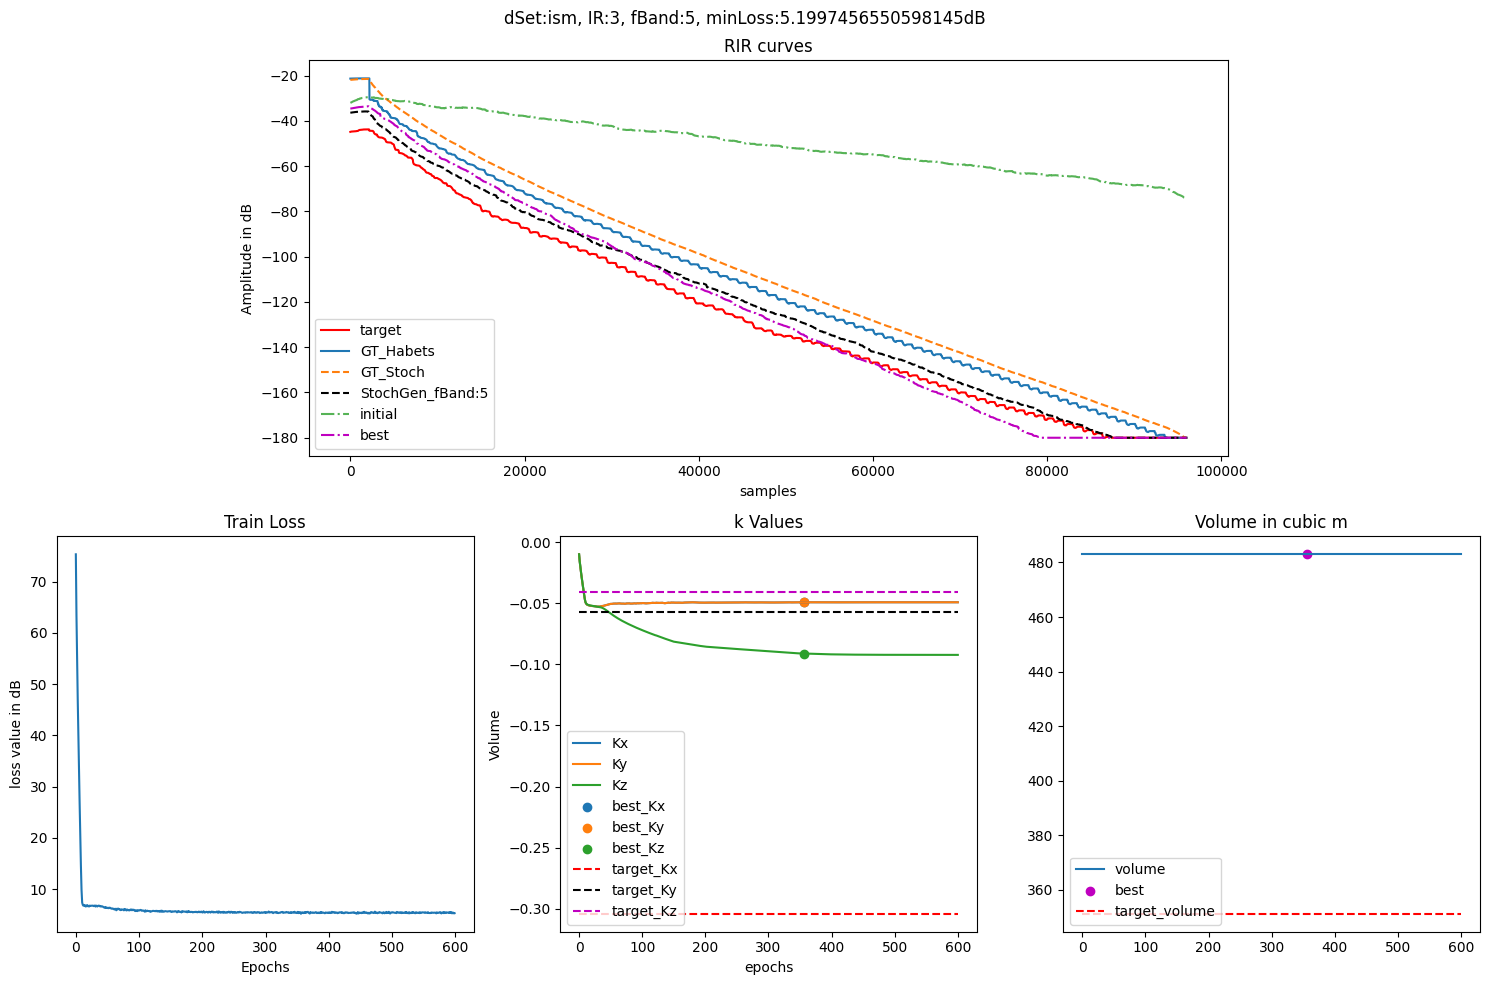

-------- Frequency Band: 6 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([646.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 74.7125
Loss in epoch:100 is : 5.7335
Loss in epoch:200 is : 5.7178
Loss in epoch:300 is : 5.7009
Loss in epoch:400 is : 5.7209
Loss in epoch:500 is : 5.7413
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0505, device='cuda:0')
Ky :  tensor(-0.0505, device='cuda:0')
Kz :  tensor(-0.0502, device='cuda:0')
V :  tensor([646.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(5.6959), 'min_loss_epoch': tensor(12), 'Kx': tensor(-0.0504, device='cuda:0'), 'Ky': tensor(-0.0504, device='cuda:0'), 'Kz': tensor(-0.0502, device='cuda:0'), 'V': tensor([646.], device='cuda:0')}
Final model params for band-6: {'Kx': tensor(-0.0504), 'Ky': tensor(-0.0504), 'Kz': tensor(-0.050

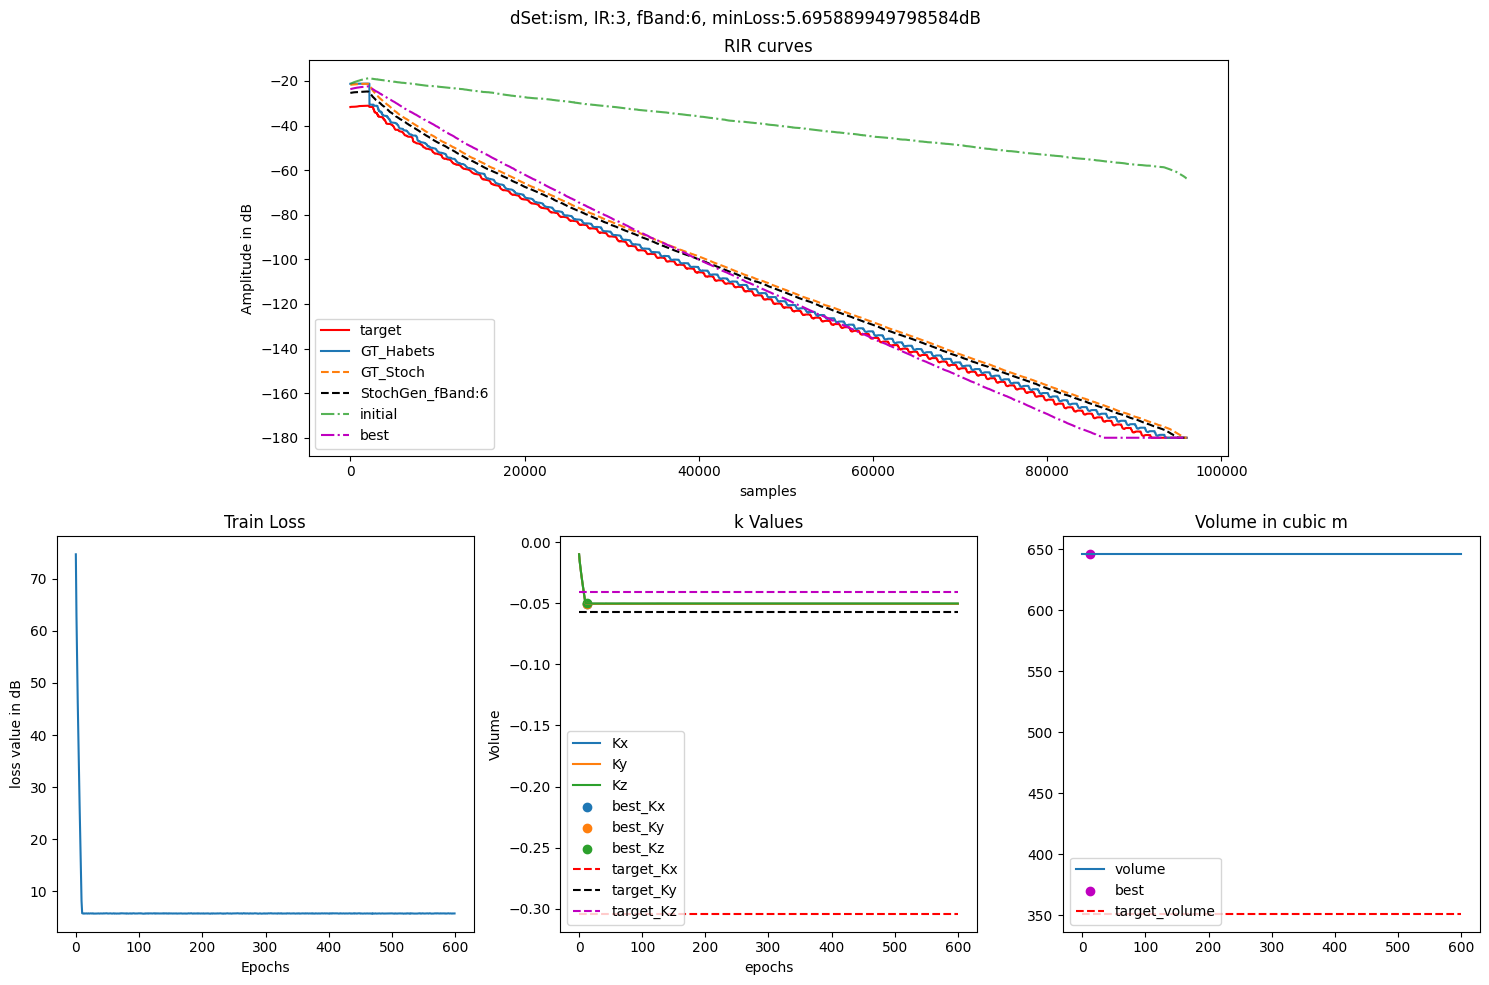

################################### 
 K values for all Bands: 
 ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss'] 
tensor([[-7.4252e-02, -7.4252e-02, -4.1279e-02,  7.2800e+02,  1.0000e+00,
          1.9092e+00],
        [-5.2426e-02, -5.2426e-02, -8.5473e-02,  1.3000e+02,  1.0000e+00,
          5.8955e+00],
        [-4.4938e-02, -4.4938e-02, -9.9436e-02,  5.0800e+02,  1.0000e+00,
          3.6113e+00],
        [-9.3693e-02, -9.3693e-02, -4.1852e-02,  6.0290e+02,  1.0000e+00,
          2.3952e+00],
        [-4.9237e-02, -4.9237e-02, -9.1195e-02,  4.8300e+02,  1.0000e+00,
          5.1997e+00],
        [-5.0438e-02, -5.0438e-02, -5.0212e-02,  6.4600e+02,  1.0000e+00,
          5.6959e+00]])
 Converged for 6 bands 
 ################################### 
---------------- Datapoint number: 4 out of 6 ----------------
Target Kvalues: tensor([8.5000, 7.5000, 4.8000]), tensor([-0.7951, -0.3092, -0.0870]), 306.0
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Initial model Pa

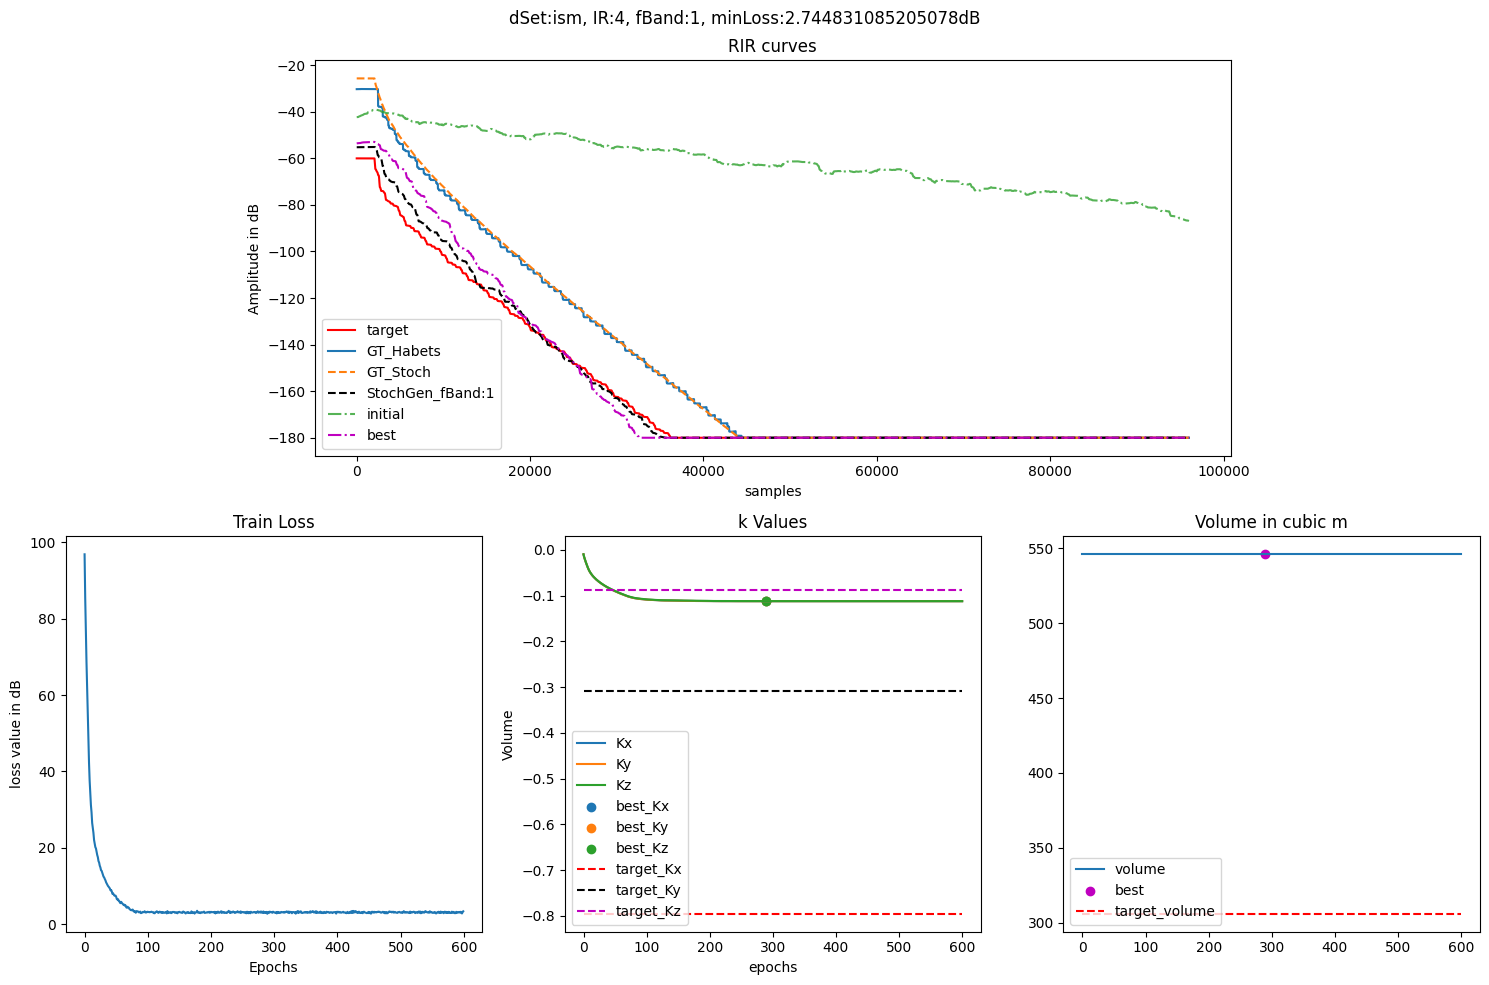

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([248.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 99.9224
Loss in epoch:100 is : 3.4053
Loss in epoch:200 is : 3.1999
Loss in epoch:300 is : 3.3698
Loss in epoch:400 is : 2.956
Loss in epoch:500 is : 3.4222
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1106, device='cuda:0')
Ky :  tensor(-0.1106, device='cuda:0')
Kz :  tensor(-0.1103, device='cuda:0')
V :  tensor([248.], device='cuda:0')
Final model params for band-2: {'Kx': tensor(-0.1106), 'Ky': tensor(-0.1106), 'Kz': tensor(-0.1103), 'V': tensor([248.])}
final param: [tensor(-0.1106), tensor(-0.1106), tensor(-0.1103), tensor([248.])]
Best params: {'min_loss': tensor(2.9168), 'min_loss_epoch': tensor(188), 'Kx': tensor(-0.1103, device='cuda:0'), 'Ky': tensor(-0.1103, device='cuda:0'), 'K

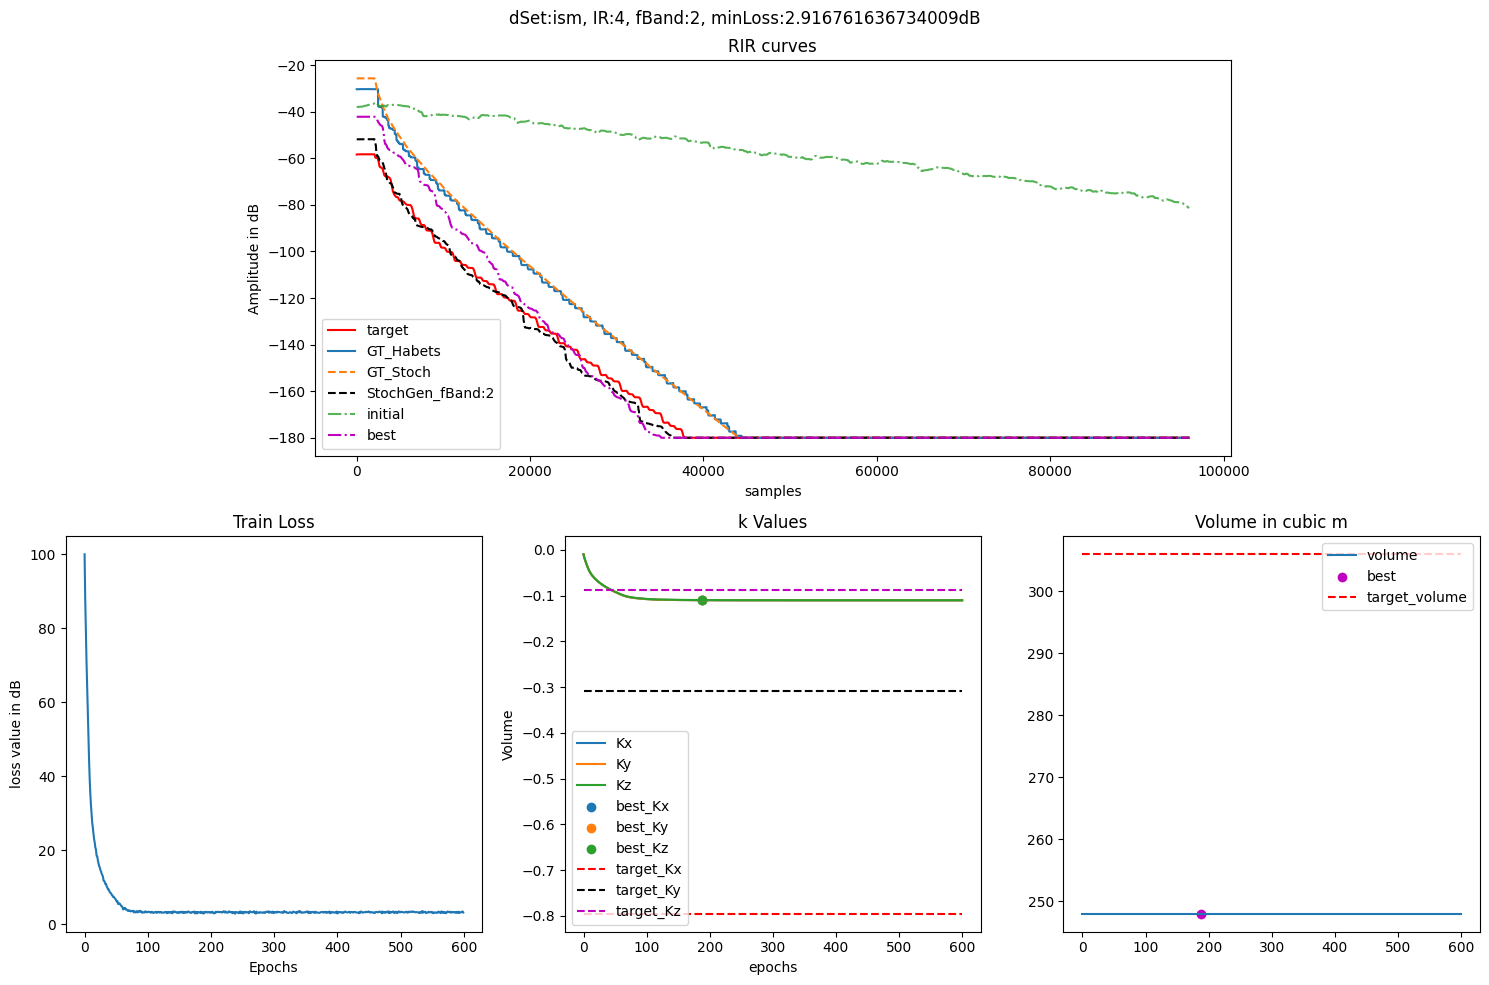

-------- Frequency Band: 3 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([692.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 98.2999
Loss in epoch:100 is : 2.923
Loss in epoch:200 is : 2.7891
Loss in epoch:300 is : 2.7697
Loss in epoch:400 is : 2.8738
Loss in epoch:500 is : 2.801
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1098, device='cuda:0')
Ky :  tensor(-0.1098, device='cuda:0')
Kz :  tensor(-0.1094, device='cuda:0')
V :  tensor([692.], device='cuda:0')
Final model params for band-3: {'Kx': tensor(-0.1098), 'Ky': tensor(-0.1098), 'Kz': tensor(-0.1094), 'V': tensor([692.])}
final param: [tensor(-0.1098), tensor(-0.1098), tensor(-0.1094), tensor([692.])]
Best params: {'min_loss': tensor(2.5042), 'min_loss_epoch': tensor(130), 'Kx': tensor(-0.1087, device='cuda:0'), 'Ky': tensor(-0.1087, device='cuda:0'), 'Kz

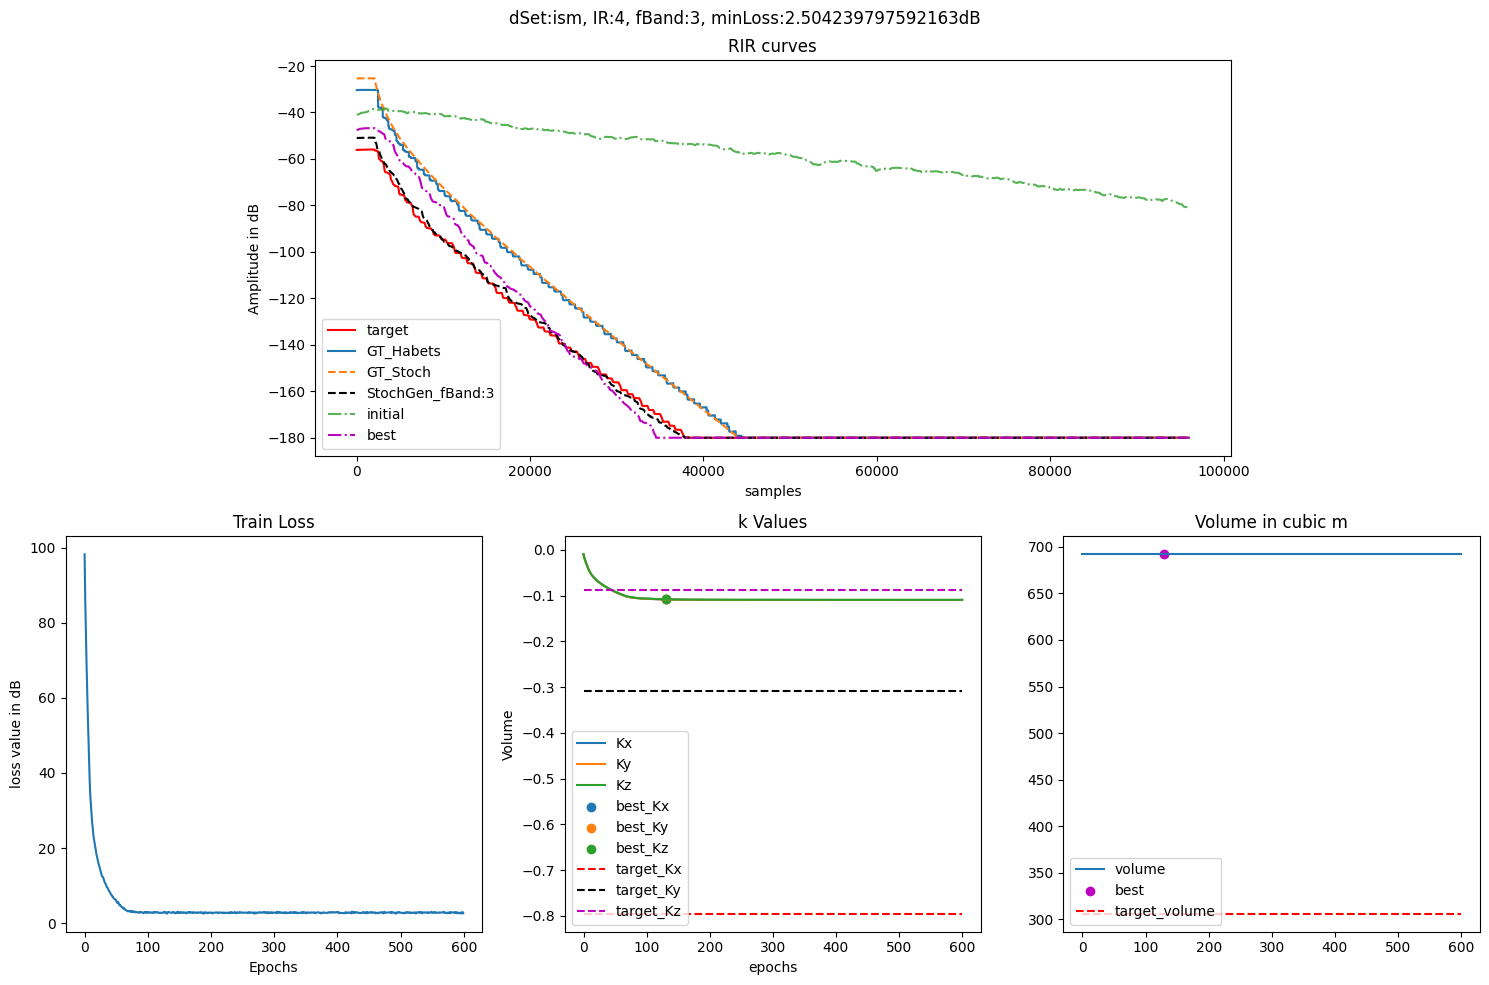

-------- Frequency Band: 4 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([649.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 100.9911
Loss in epoch:100 is : 2.5115
Loss in epoch:200 is : 2.5435
Loss in epoch:300 is : 2.6978
Loss in epoch:400 is : 2.6434
Loss in epoch:500 is : 2.8261
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1095, device='cuda:0')
Ky :  tensor(-0.1095, device='cuda:0')
Kz :  tensor(-0.1091, device='cuda:0')
V :  tensor([649.], device='cuda:0')
Final model params for band-4: {'Kx': tensor(-0.1095), 'Ky': tensor(-0.1095), 'Kz': tensor(-0.1091), 'V': tensor([649.])}
final param: [tensor(-0.1095), tensor(-0.1095), tensor(-0.1091), tensor([649.])]
Best params: {'min_loss': tensor(2.4373), 'min_loss_epoch': tensor(243), 'Kx': tensor(-0.1094, device='cuda:0'), 'Ky': tensor(-0.1094, device='cuda:0'), 

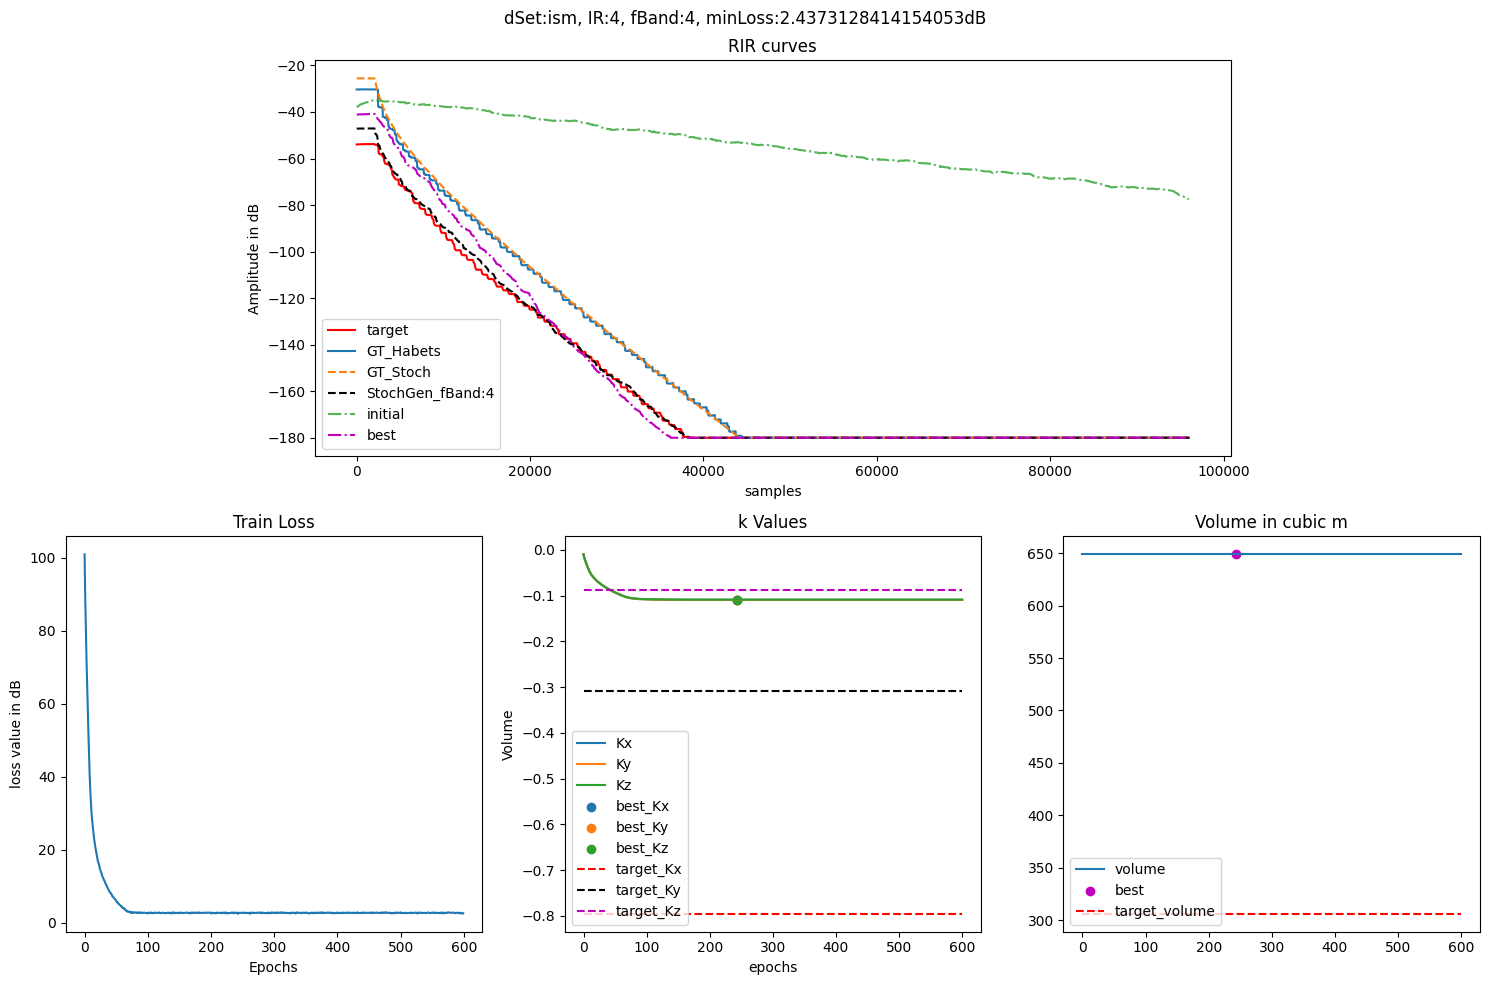

-------- Frequency Band: 5 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([551.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 103.5801
Loss in epoch:100 is : 2.7756
Loss in epoch:200 is : 2.6756
Loss in epoch:300 is : 2.6698
Loss in epoch:400 is : 2.6829
Loss in epoch:500 is : 2.7434
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1123, device='cuda:0')
Ky :  tensor(-0.1123, device='cuda:0')
Kz :  tensor(-0.1120, device='cuda:0')
V :  tensor([551.], device='cuda:0')
Final model params for band-5: {'Kx': tensor(-0.1123), 'Ky': tensor(-0.1123), 'Kz': tensor(-0.1120), 'V': tensor([551.])}
final param: [tensor(-0.1123), tensor(-0.1123), tensor(-0.1120), tensor([551.])]
Best params: {'min_loss': tensor(2.5998), 'min_loss_epoch': tensor(420), 'Kx': tensor(-0.1123, device='cuda:0'), 'Ky': tensor(-0.1123, device='cuda:0'), 

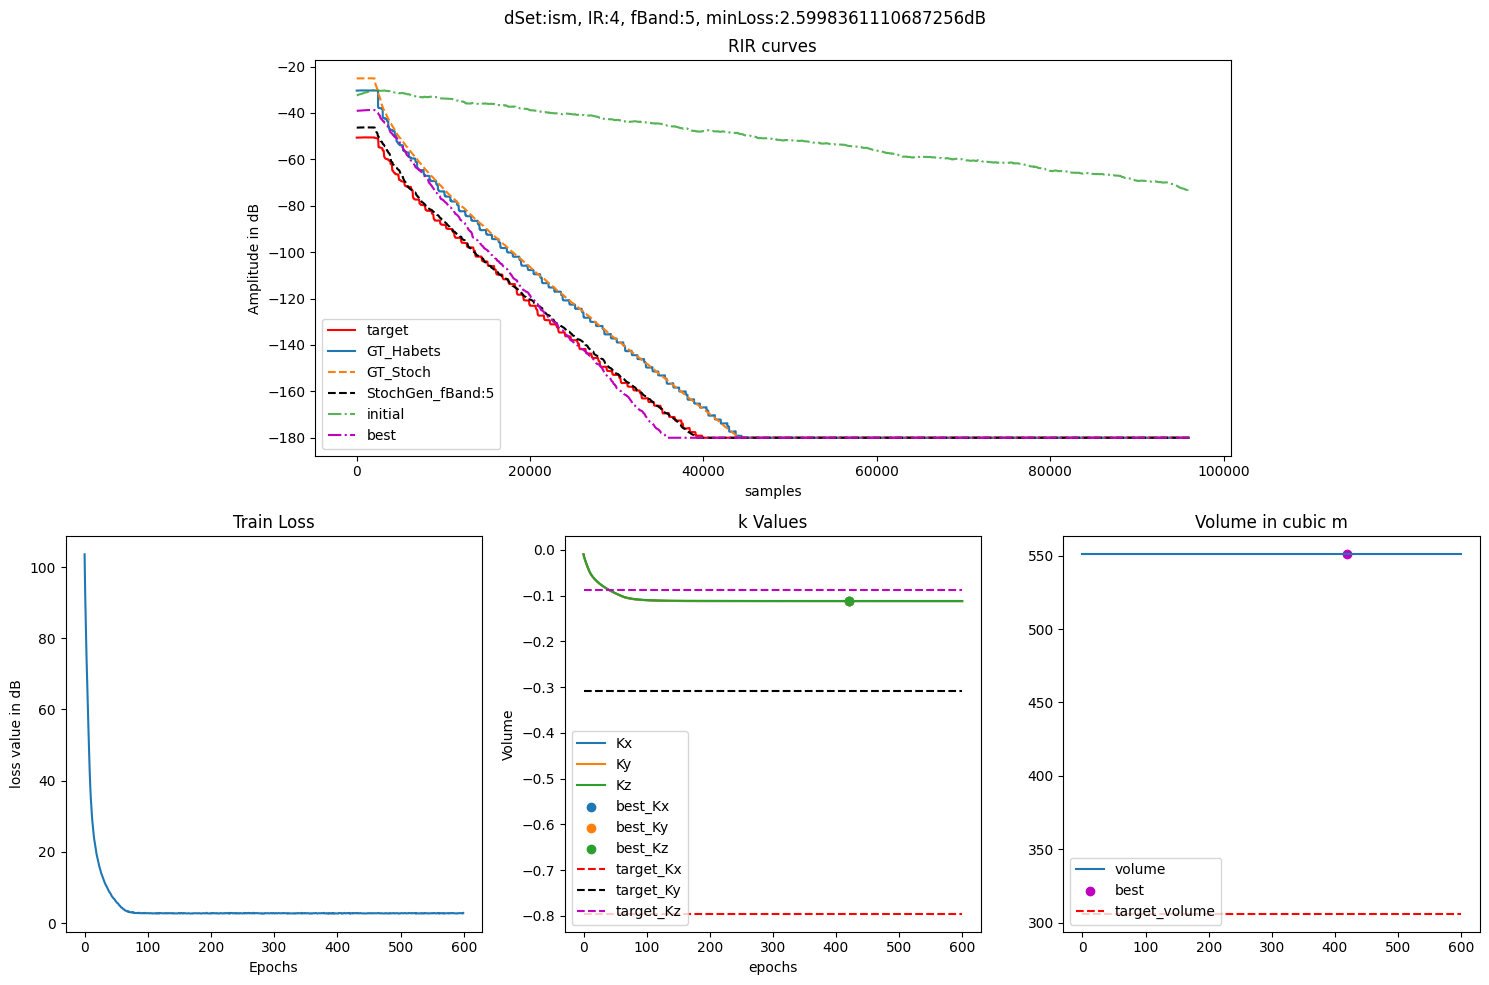

-------- Frequency Band: 6 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([693.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 109.2539
Loss in epoch:100 is : 3.0216
Loss in epoch:200 is : 3.0017
Loss in epoch:300 is : 3.0074
Loss in epoch:400 is : 3.0066
Loss in epoch:500 is : 2.9896
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1068, device='cuda:0')
Ky :  tensor(-0.1068, device='cuda:0')
Kz :  tensor(-0.1080, device='cuda:0')
V :  tensor([693.], device='cuda:0')
Final model params for band-6: {'Kx': tensor(-0.1068), 'Ky': tensor(-0.1068), 'Kz': tensor(-0.1080), 'V': tensor([693.])}
final param: [tensor(-0.1068), tensor(-0.1068), tensor(-0.1080), tensor([693.])]
Best params: {'min_loss': tensor(2.9495), 'min_loss_epoch': tensor(99), 'Kx': tensor(-0.1069, device='cuda:0'), 'Ky': tensor(-0.1069, device='cuda:0'), '

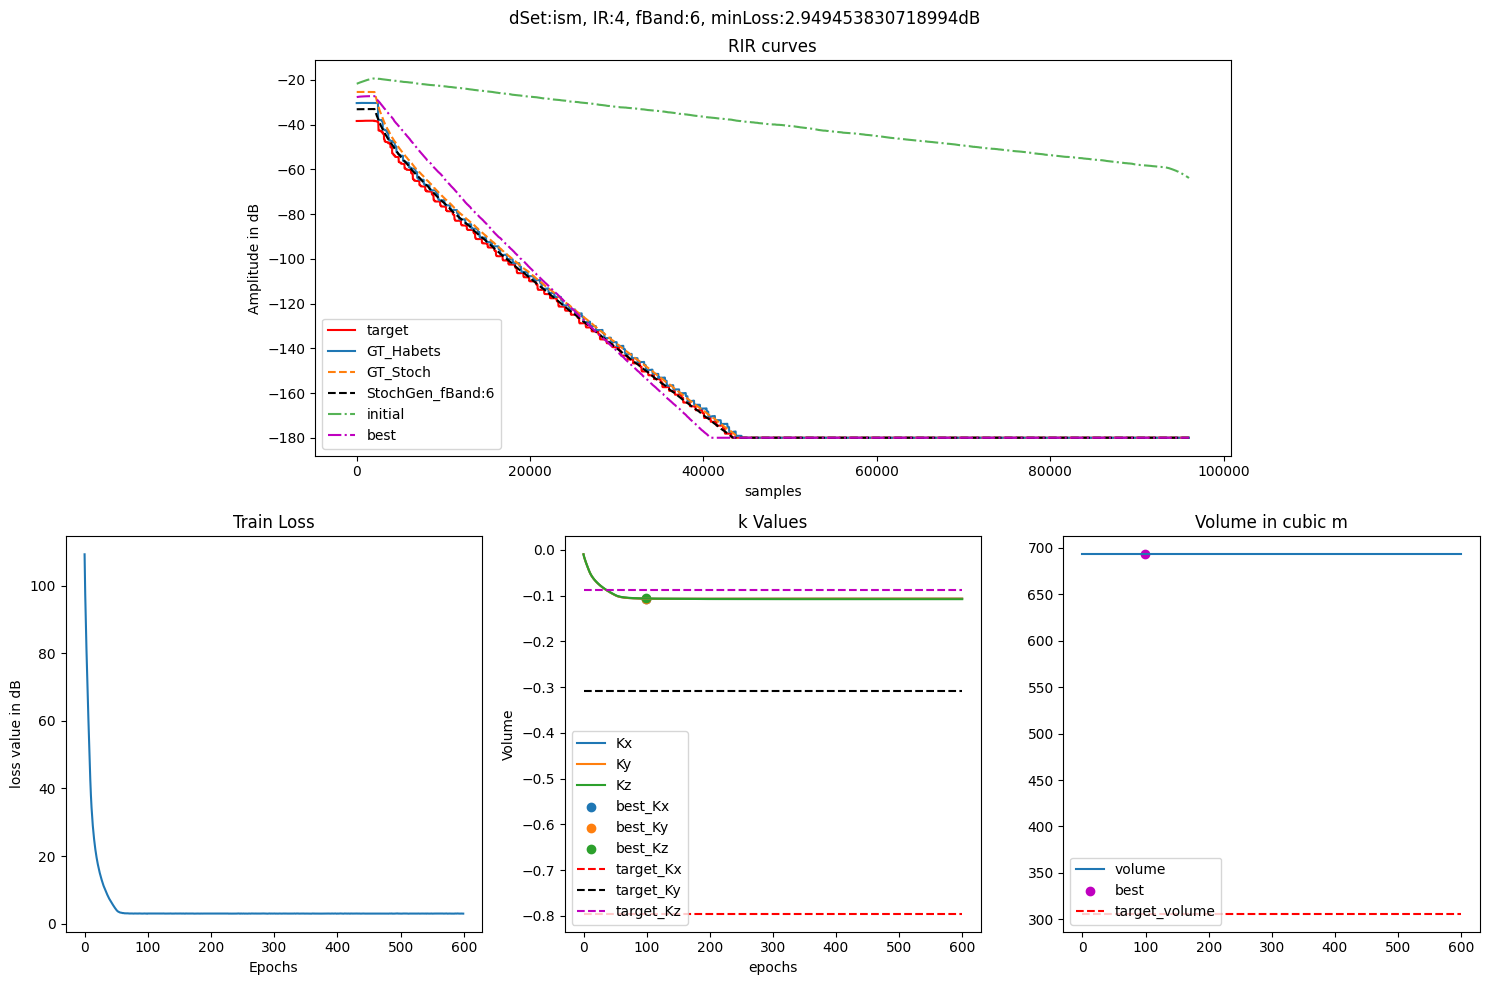

################################### 
 K values for all Bands: 
 ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss'] 
tensor([[-1.1244e-01, -1.1244e-01, -1.1232e-01,  5.4600e+02,  1.0000e+00,
          2.7448e+00],
        [-1.1057e-01, -1.1057e-01, -1.1034e-01,  2.4800e+02,  1.0000e+00,
          2.9168e+00],
        [-1.0979e-01, -1.0979e-01, -1.0941e-01,  6.9200e+02,  1.0000e+00,
          2.5042e+00],
        [-1.0945e-01, -1.0945e-01, -1.0907e-01,  6.4900e+02,  1.0000e+00,
          2.4373e+00],
        [-1.1231e-01, -1.1231e-01, -1.1196e-01,  5.5100e+02,  1.0000e+00,
          2.5998e+00],
        [-1.0681e-01, -1.0681e-01, -1.0800e-01,  6.9300e+02,  1.0000e+00,
          2.9495e+00]])
 Converged for 6 bands 
 ################################### 
---------------- Datapoint number: 5 out of 6 ----------------
Target Kvalues: tensor([9.2000, 5.9000, 4.3000]), tensor([-0.4106, -0.1192, -0.0175]), 233.4040069580078
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Init

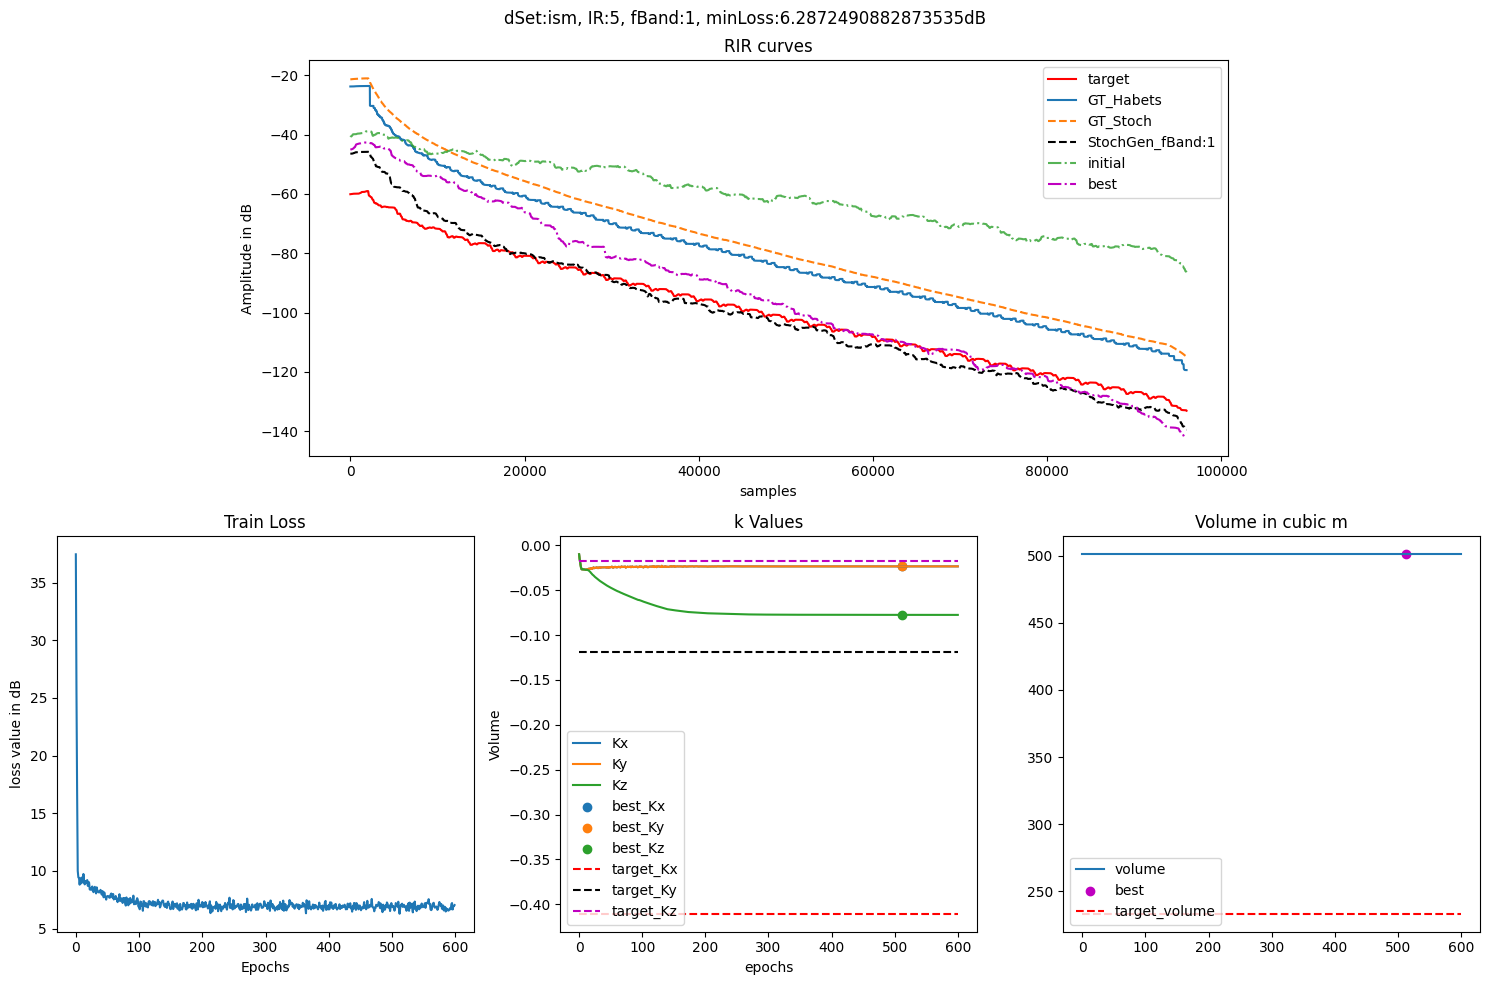

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([778.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 32.2393
Loss in epoch:100 is : 5.2234
Loss in epoch:200 is : 4.7464
Loss in epoch:300 is : 5.1519
Loss in epoch:400 is : 4.7669
Loss in epoch:500 is : 4.8409
Converged!

Updated Param after Trial:
Kx :  tensor(-0.0208, device='cuda:0')
Ky :  tensor(-0.0208, device='cuda:0')
Kz :  tensor(-0.0861, device='cuda:0')
V :  tensor([776.8000], device='cuda:0')
Final model params for band-2: {'Kx': tensor(-0.0208), 'Ky': tensor(-0.0208), 'Kz': tensor(-0.0861), 'V': tensor([776.8000])}
final param: [tensor(-0.0208), tensor(-0.0208), tensor(-0.0861), tensor([776.8000])]
Best params: {'min_loss': tensor(4.1663), 'min_loss_epoch': tensor(503), 'Kx': tensor(-0.0208, device='cuda:0'), 'Ky': tensor(-0.0208, device=

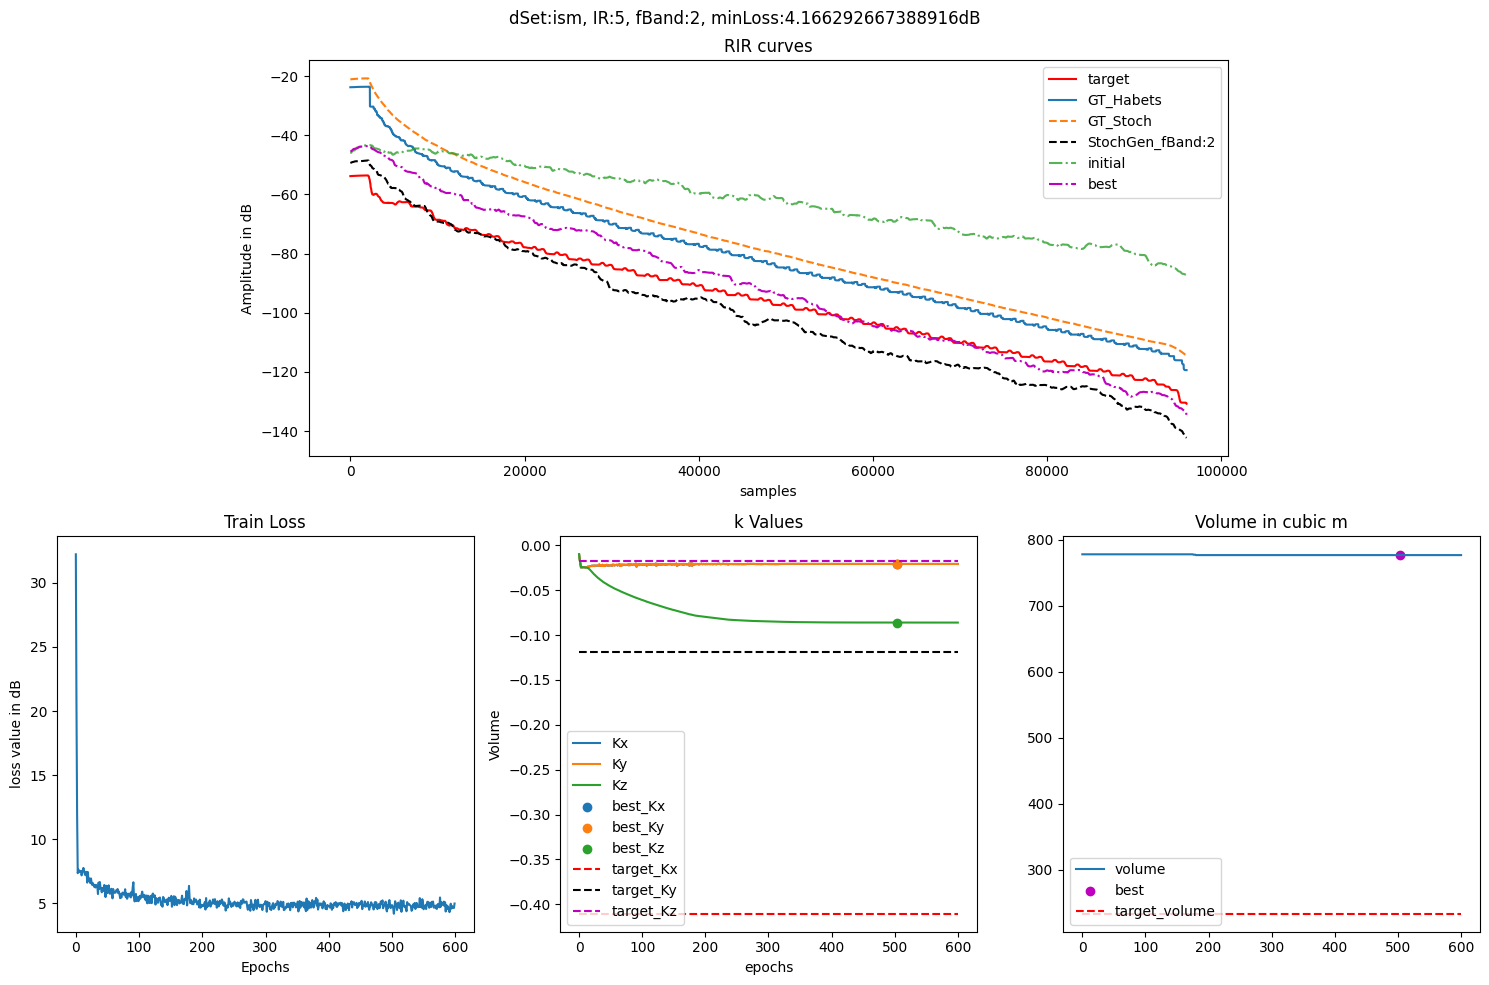

-------- Frequency Band: 3 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([358.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 39.4072
Loss in epoch:100 is : 8.1112
Loss in epoch:200 is : 7.8848
Loss in epoch:300 is : 7.6454
Loss in epoch:400 is : 7.4866
Loss in epoch:500 is : 7.4931
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0239, device='cuda:0')
Ky :  tensor(-0.0239, device='cuda:0')
Kz :  tensor(-0.0837, device='cuda:0')
V :  tensor([358.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(7.1327), 'min_loss_epoch': tensor(345), 'Kx': tensor(-0.0239, device='cuda:0'), 'Ky': tensor(-0.0239, device='cuda:0'), 'Kz': tensor(-0.0835, device='cuda:0'), 'V': tensor([358.], device='cuda:0')}
Final model params for band-3: {'Kx': tensor(-0.0239), 'Ky': tensor(-0.0239), 'Kz': tensor(-0.08

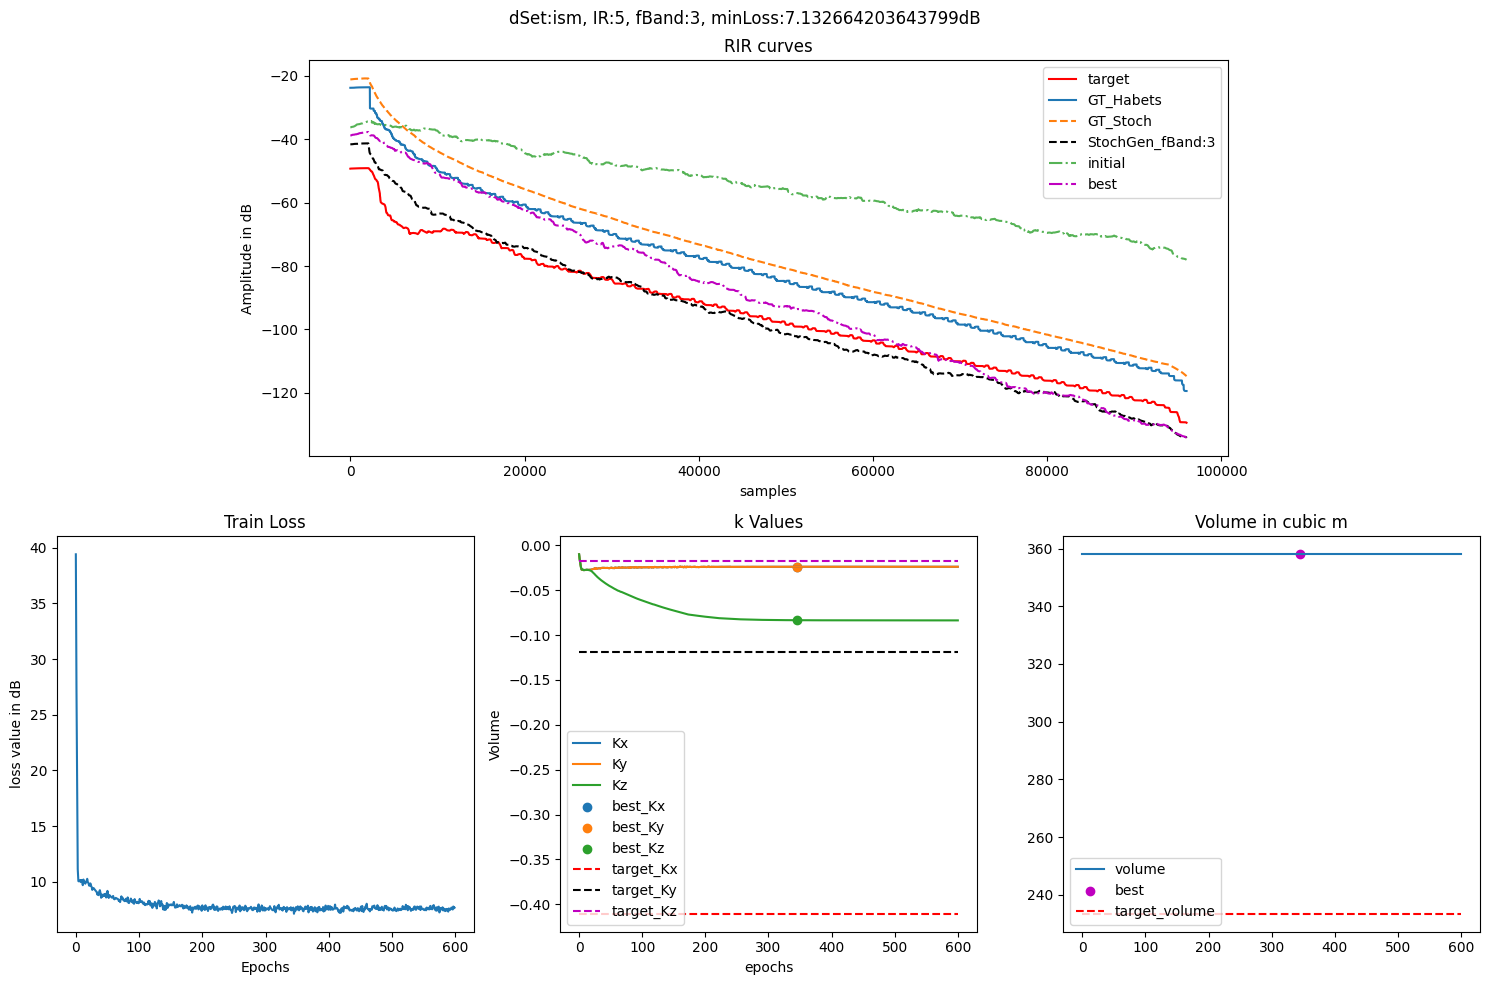

-------- Frequency Band: 4 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([556.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 40.1131
Loss in epoch:100 is : 8.0804
Loss in epoch:200 is : 7.6627
Loss in epoch:300 is : 7.4008
Loss in epoch:400 is : 7.3126
Loss in epoch:500 is : 7.1846
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0239, device='cuda:0')
Ky :  tensor(-0.0239, device='cuda:0')
Kz :  tensor(-0.0955, device='cuda:0')
V :  tensor([556.], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(7.0395), 'min_loss_epoch': tensor(394), 'Kx': tensor(-0.0239, device='cuda:0'), 'Ky': tensor(-0.0239, device='cuda:0'), 'Kz': tensor(-0.0952, device='cuda:0'), 'V': tensor([556.], device='cuda:0')}
Final model params for band-4: {'Kx': tensor(-0.0239), 'Ky': tensor(-0.0239), 'Kz': tensor(-0.09

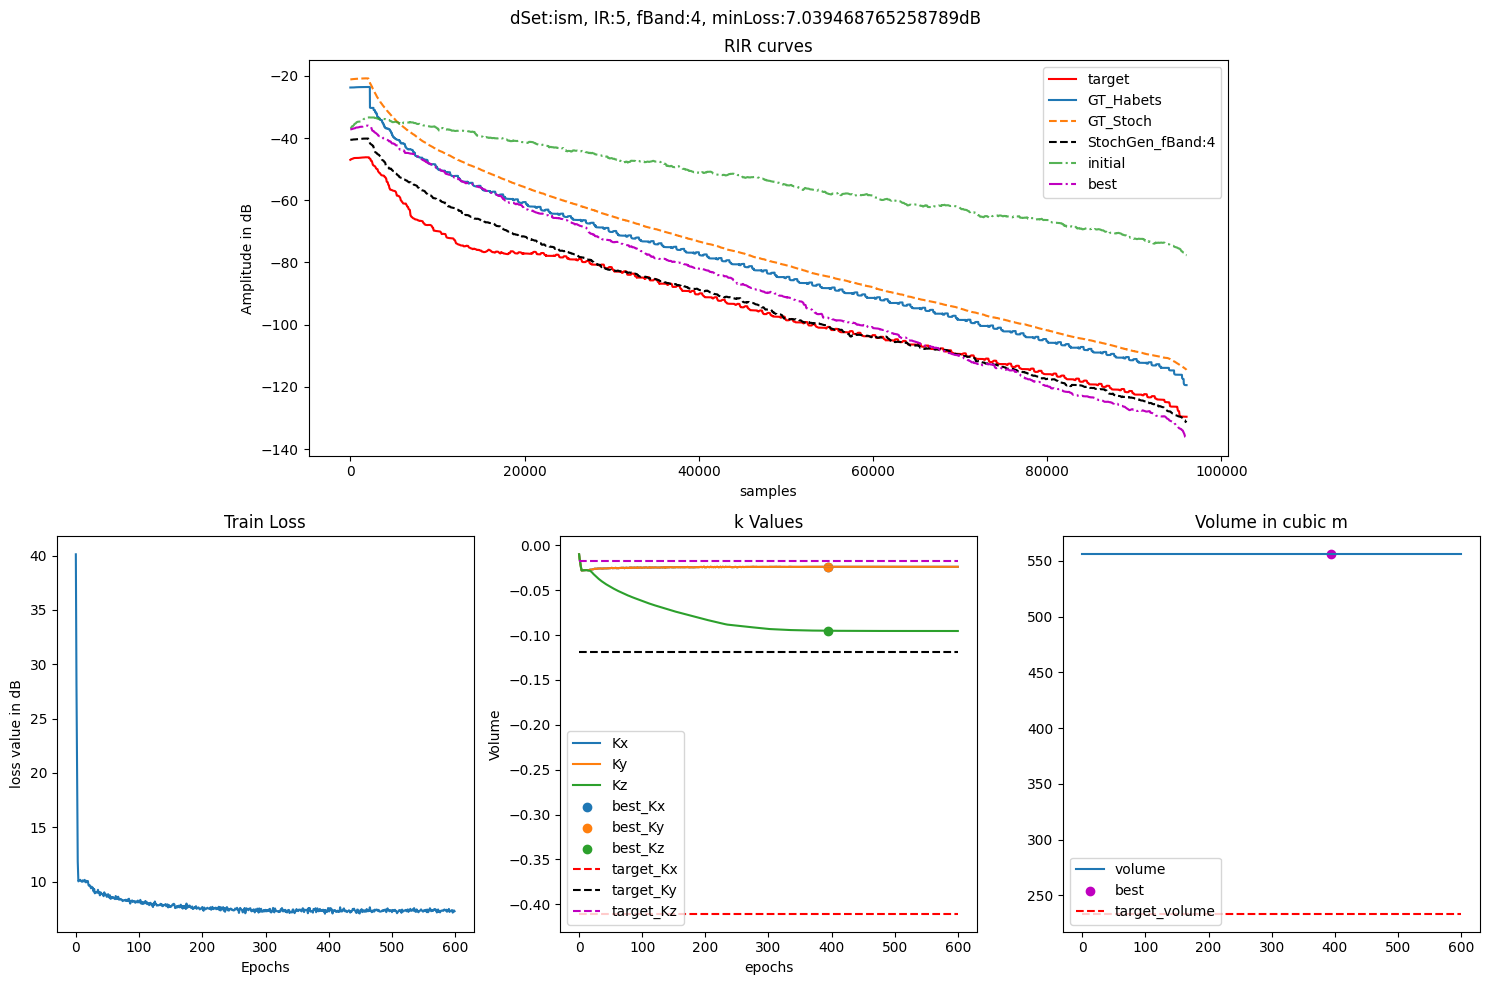

-------- Frequency Band: 5 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([304.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 44.9631
Loss in epoch:100 is : 8.2438
Loss in epoch:200 is : 6.8288
Loss in epoch:300 is : 6.7173
Loss in epoch:400 is : 6.5573
Loss in epoch:500 is : 6.3529
Give Up!

Updated Param after Trial:
Kx :  tensor(-0.0882, device='cuda:0')
Ky :  tensor(-0.0882, device='cuda:0')
Kz :  tensor(-0.0211, device='cuda:0')
V :  tensor([283.5998], device='cuda:0')

converged2: by accepted loss !
best params: {'min_loss': tensor(6.2821), 'min_loss_epoch': tensor(428), 'Kx': tensor(-0.0877, device='cuda:0'), 'Ky': tensor(-0.0877, device='cuda:0'), 'Kz': tensor(-0.0211, device='cuda:0'), 'V': tensor([283.5998], device='cuda:0')}
Final model params for band-5: {'Kx': tensor(-0.0877), 'Ky': tensor(-0.0877), 'Kz': tens

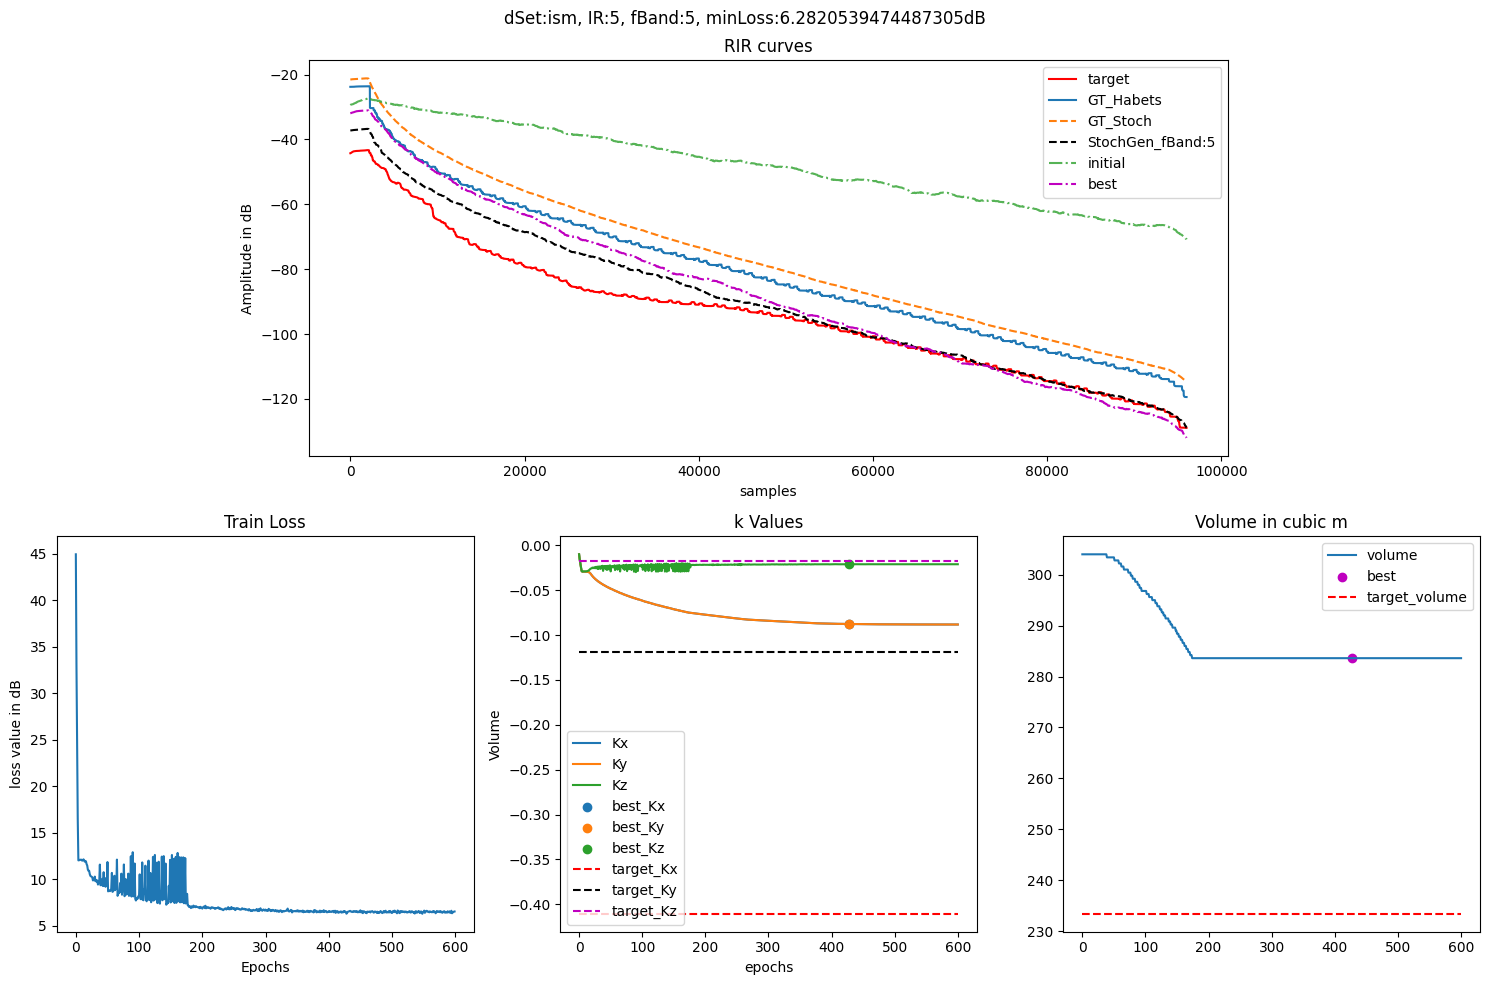

-------- Frequency Band: 6 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([385.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 45.2675
Loss in epoch:100 is : 6.5919
Loss in epoch:200 is : 10.2794
Loss in epoch:300 is : 5.9955
Loss in epoch:400 is : 4.0092
Loss in epoch:500 is : 3.8703
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1124, device='cuda:0')
Ky :  tensor(-0.1124, device='cuda:0')
Kz :  tensor(-0.0220, device='cuda:0')
V :  tensor([314.1993], device='cuda:0')
Final model params for band-6: {'Kx': tensor(-0.1124), 'Ky': tensor(-0.1124), 'Kz': tensor(-0.0220), 'V': tensor([314.1993])}
final param: [tensor(-0.1124), tensor(-0.1124), tensor(-0.0220), tensor([314.1993])]
Best params: {'min_loss': tensor(3.6398), 'min_loss_epoch': tensor(562), 'Kx': tensor(-0.1106, device='cuda:0'), 'Ky': tensor(-0.1106, device

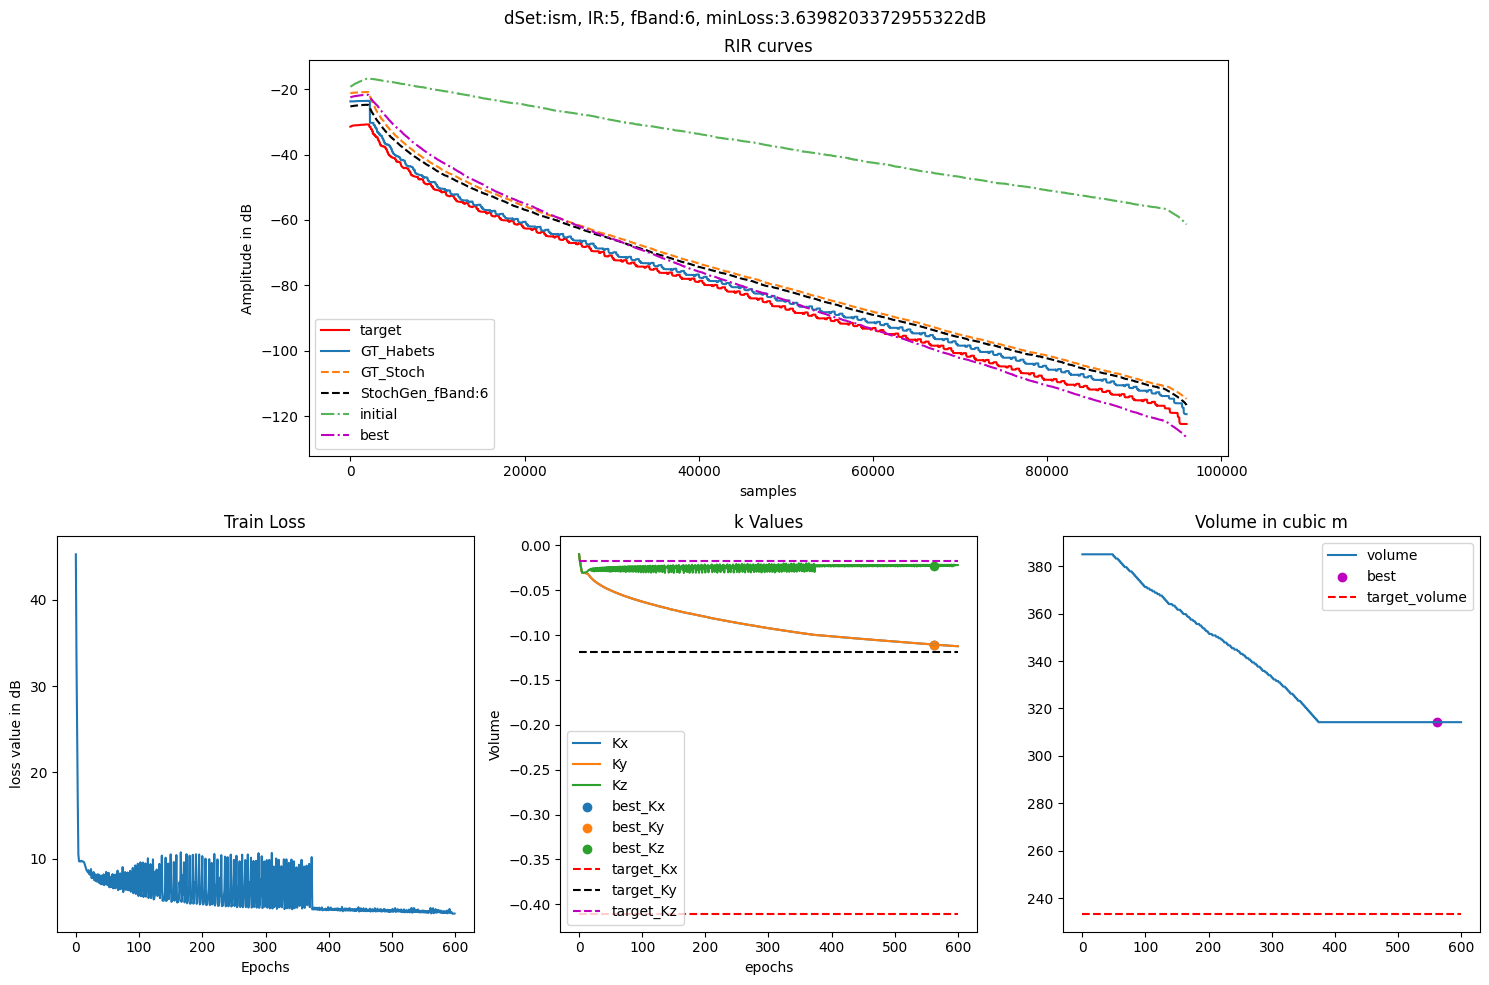

################################### 
 K values for all Bands: 
 ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss'] 
tensor([[-2.3470e-02, -2.3470e-02, -7.7494e-02,  5.0100e+02,  1.0000e+00,
          6.2872e+00],
        [-2.0767e-02, -2.0767e-02, -8.6087e-02,  7.7680e+02,  1.0000e+00,
          4.1663e+00],
        [-2.3886e-02, -2.3886e-02, -8.3458e-02,  3.5800e+02,  1.0000e+00,
          7.1327e+00],
        [-2.3917e-02, -2.3917e-02, -9.5197e-02,  5.5600e+02,  1.0000e+00,
          7.0395e+00],
        [-8.7663e-02, -8.7663e-02, -2.1093e-02,  2.8360e+02,  1.0000e+00,
          6.2821e+00],
        [-1.1239e-01, -1.1239e-01, -2.2006e-02,  3.1420e+02,  1.0000e+00,
          3.6398e+00]])
 Converged for 6 bands 
 ################################### 
---------------- Datapoint number: 6 out of 6 ----------------
Target Kvalues: tensor([8.4000, 6.4000, 4.6000]), tensor([-0.6045, -0.2626, -0.0944]), 247.29598999023438
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Ini

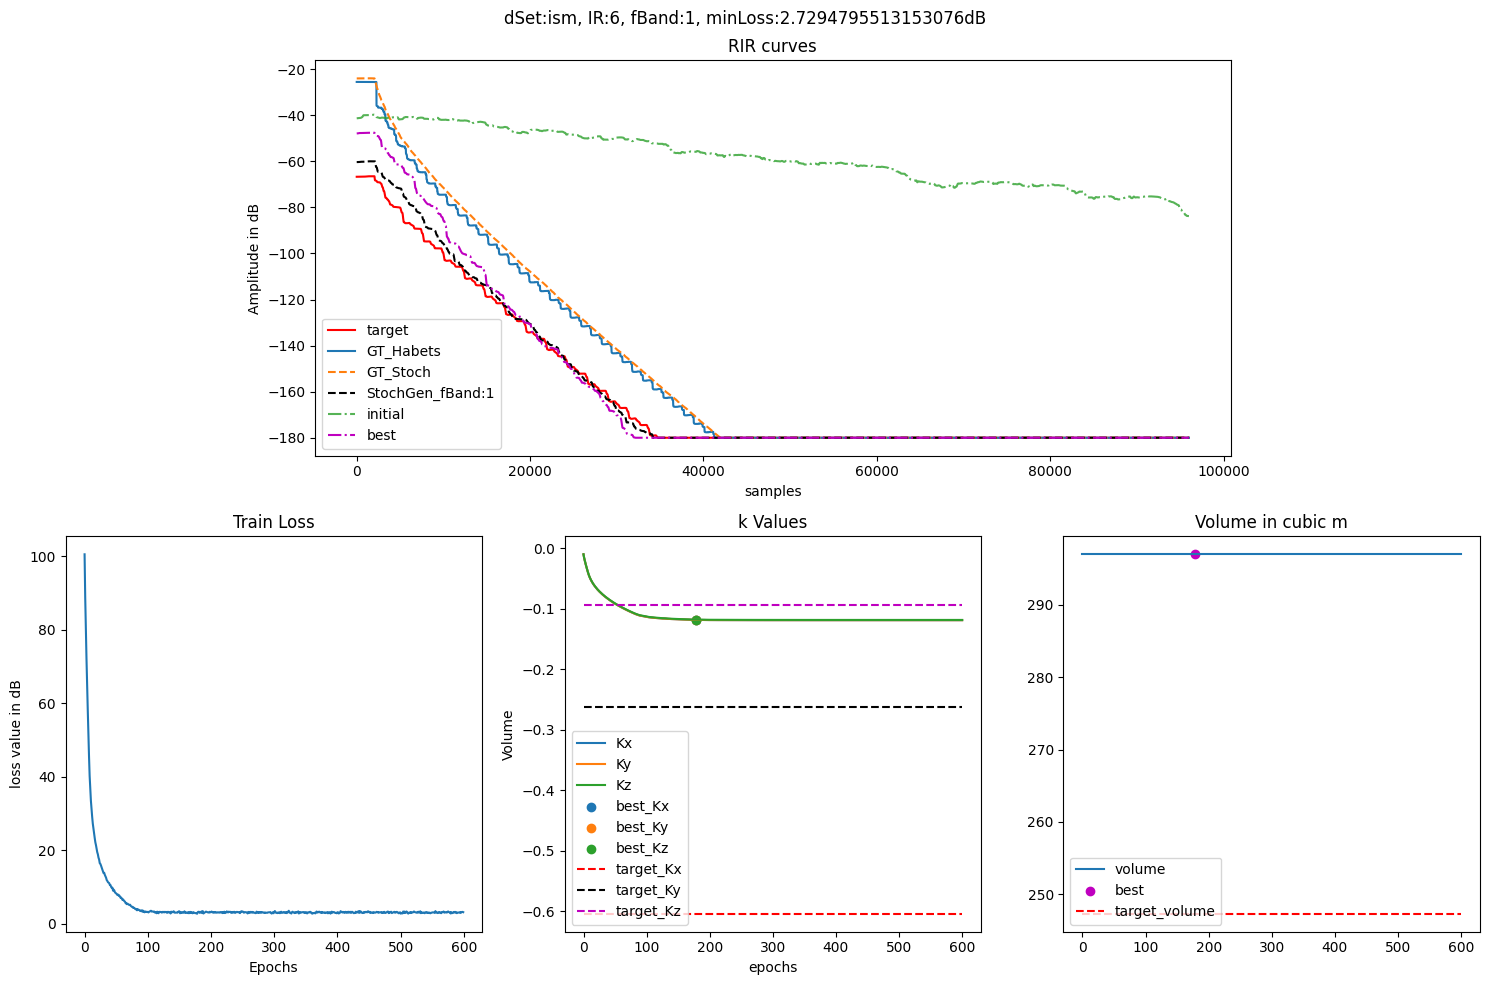

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([114.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 104.4282
Loss in epoch:100 is : 3.9582
Loss in epoch:200 is : 3.3202
Loss in epoch:300 is : 3.5288
Loss in epoch:400 is : 3.3783
Loss in epoch:500 is : 3.4641
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1204, device='cuda:0')
Ky :  tensor(-0.1204, device='cuda:0')
Kz :  tensor(-0.1200, device='cuda:0')
V :  tensor([114.], device='cuda:0')
Final model params for band-2: {'Kx': tensor(-0.1204), 'Ky': tensor(-0.1204), 'Kz': tensor(-0.1200), 'V': tensor([114.])}
final param: [tensor(-0.1204), tensor(-0.1204), tensor(-0.1200), tensor([114.])]
Best params: {'min_loss': tensor(3.2205), 'min_loss_epoch': tensor(198), 'Kx': tensor(-0.1199, device='cuda:0'), 'Ky': tensor(-0.1199, device='cuda:0'), 

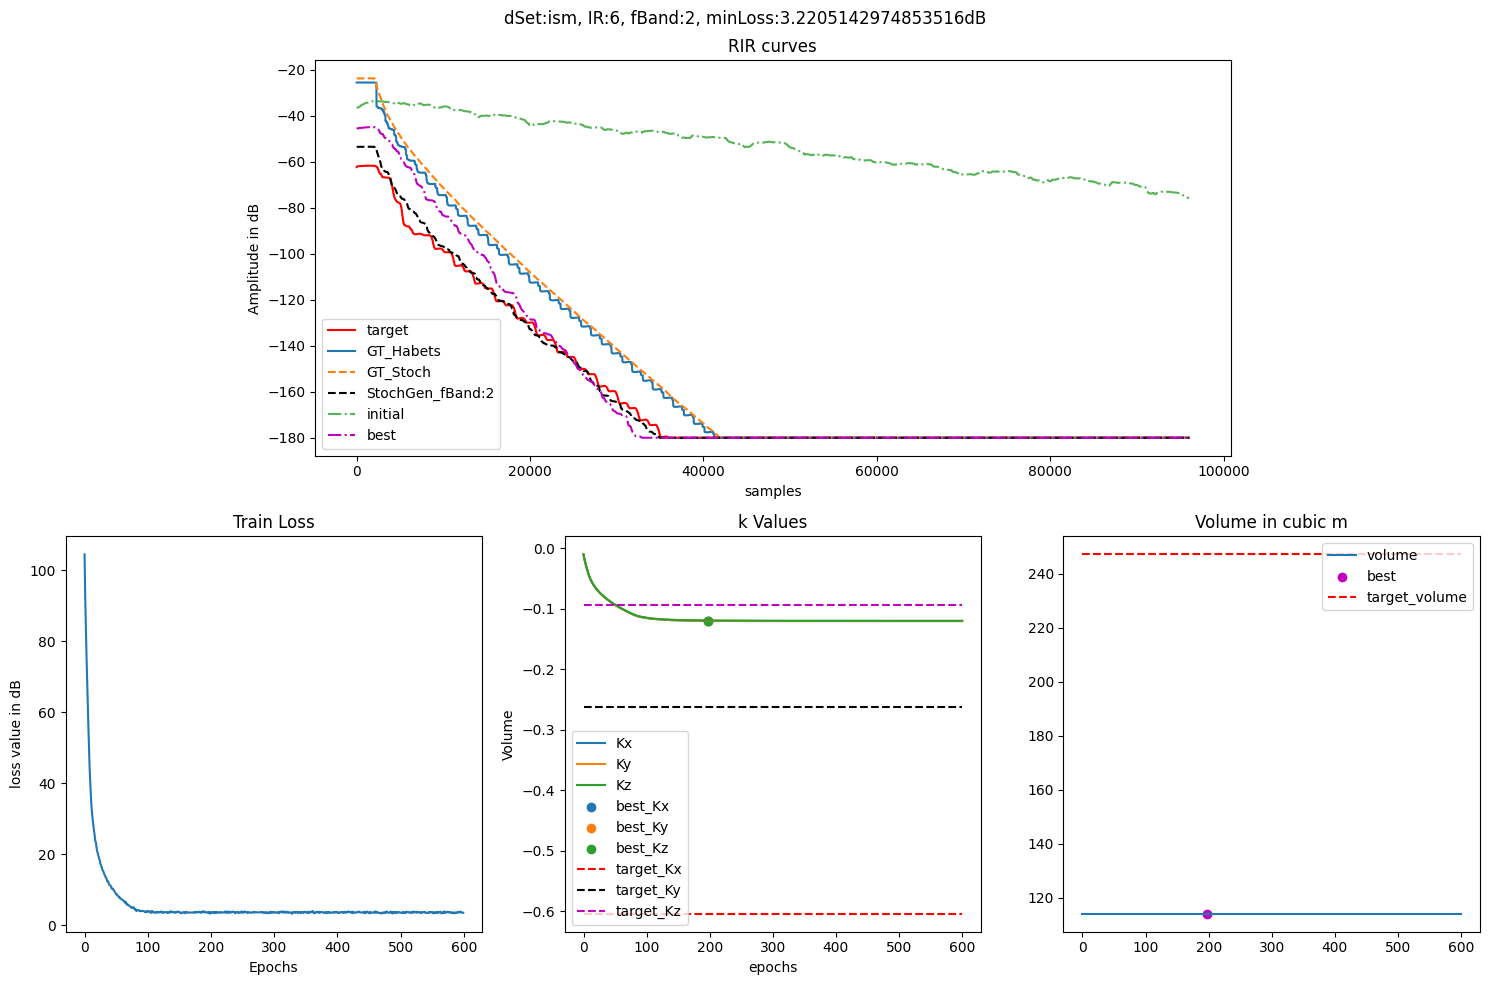

-------- Frequency Band: 3 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([374.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 101.8323
Loss in epoch:100 is : 3.2627
Loss in epoch:200 is : 3.1409
Loss in epoch:300 is : 3.0909
Loss in epoch:400 is : 3.1734
Loss in epoch:500 is : 3.1258
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1152, device='cuda:0')
Ky :  tensor(-0.1152, device='cuda:0')
Kz :  tensor(-0.1147, device='cuda:0')
V :  tensor([374.], device='cuda:0')
Final model params for band-3: {'Kx': tensor(-0.1152), 'Ky': tensor(-0.1152), 'Kz': tensor(-0.1147), 'V': tensor([374.])}
final param: [tensor(-0.1152), tensor(-0.1152), tensor(-0.1147), tensor([374.])]
Best params: {'min_loss': tensor(2.8269), 'min_loss_epoch': tensor(222), 'Kx': tensor(-0.1150, device='cuda:0'), 'Ky': tensor(-0.1150, device='cuda:0'), 

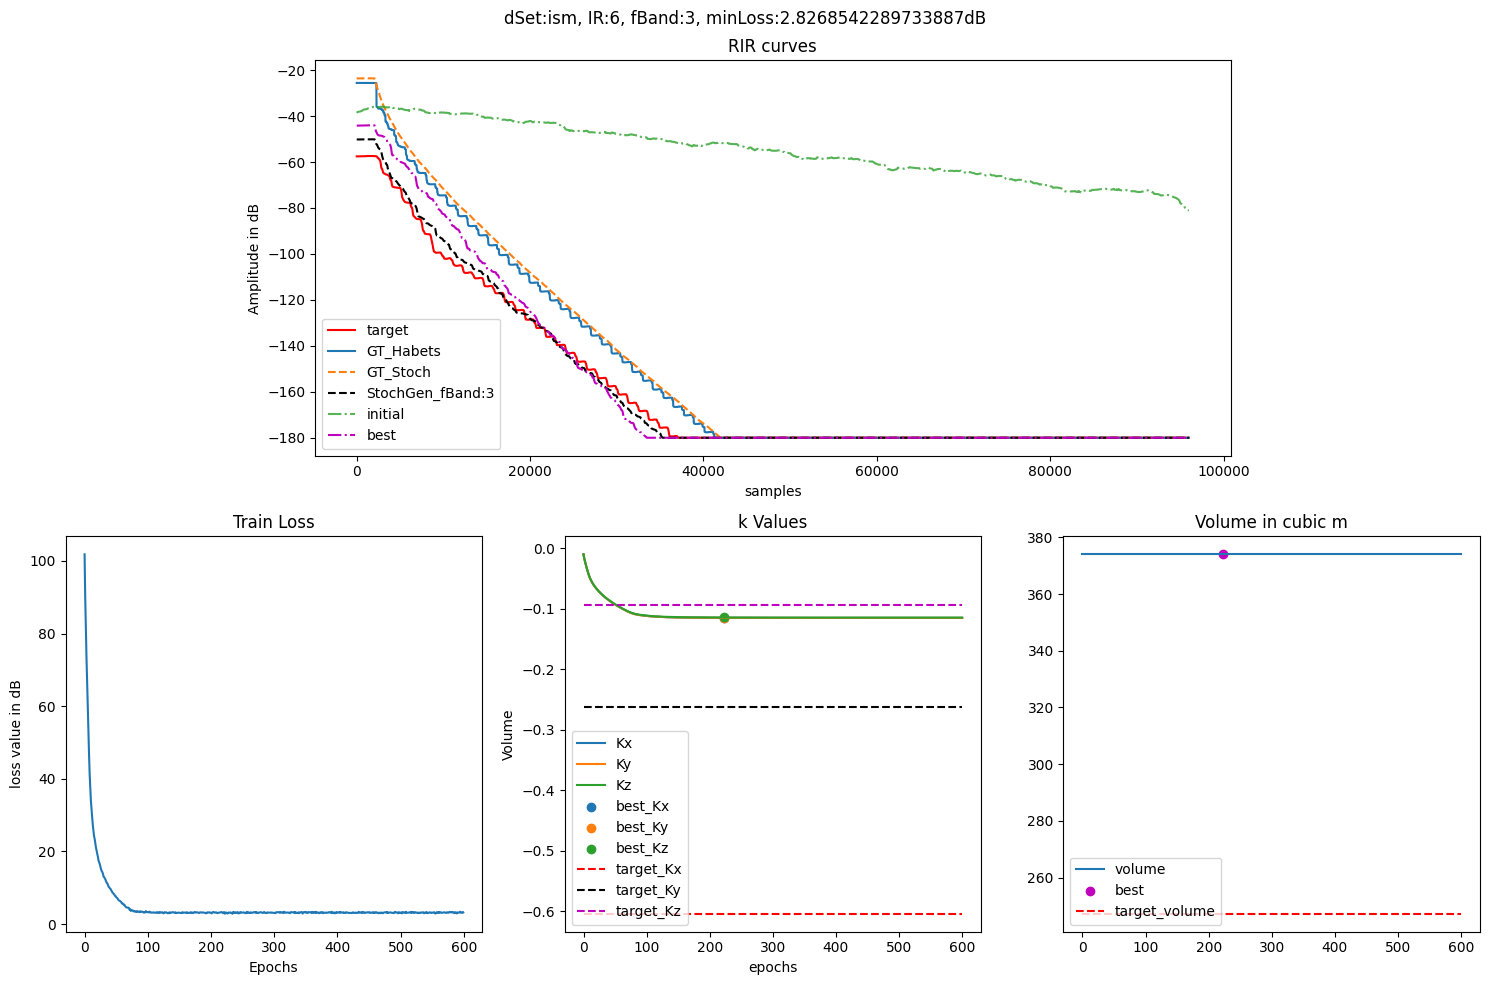

-------- Frequency Band: 4 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([124.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 109.4411
Loss in epoch:100 is : 4.0228
Loss in epoch:200 is : 3.5521
Loss in epoch:300 is : 3.5521
Loss in epoch:400 is : 3.2988
Loss in epoch:500 is : 3.4548
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1340, device='cuda:0')
Ky :  tensor(-0.1340, device='cuda:0')
Kz :  tensor(-0.1335, device='cuda:0')
V :  tensor([124.], device='cuda:0')
Final model params for band-4: {'Kx': tensor(-0.1340), 'Ky': tensor(-0.1340), 'Kz': tensor(-0.1335), 'V': tensor([124.])}
final param: [tensor(-0.1340), tensor(-0.1340), tensor(-0.1335), tensor([124.])]
Best params: {'min_loss': tensor(3.2481), 'min_loss_epoch': tensor(325), 'Kx': tensor(-0.1335, device='cuda:0'), 'Ky': tensor(-0.1335, device='cuda:0'), 

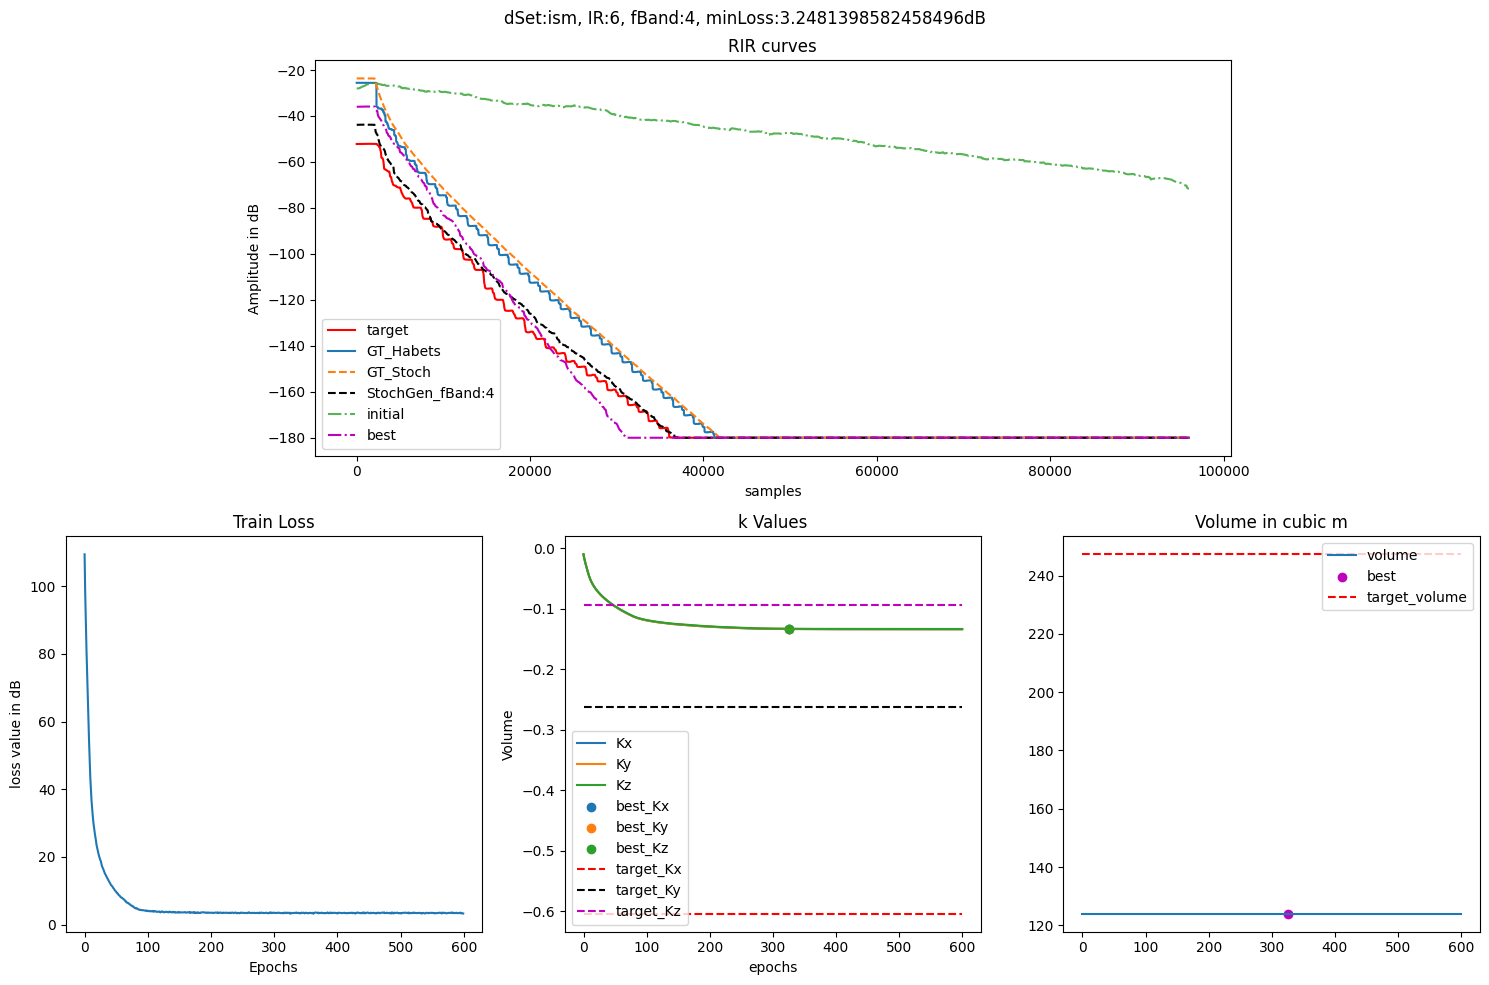

-------- Frequency Band: 5 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([775.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 103.6522
Loss in epoch:100 is : 125.343
Loss in epoch:200 is : 125.4402
Loss in epoch:300 is : 125.4485
Loss in epoch:400 is : 125.4218
Loss in epoch:500 is : 125.425
Converged!

Updated Param after Trial:
Kx :  tensor(0.5973, device='cuda:0')
Ky :  tensor(0.5973, device='cuda:0')
Kz :  tensor(0.5744, device='cuda:0')
V :  tensor([775.], device='cuda:0')
Final model params for band-5: {'Kx': tensor(0.5973), 'Ky': tensor(0.5973), 'Kz': tensor(0.5744), 'V': tensor([775.])}
final param: [tensor(0.5973), tensor(0.5973), tensor(0.5744), tensor([775.])]
Best params: {'min_loss': tensor(2.2534), 'min_loss_epoch': tensor(81), 'Kx': tensor(0.5973, device='cuda:0'), 'Ky': tensor(0.5973, device='cuda:0'), 'Kz'

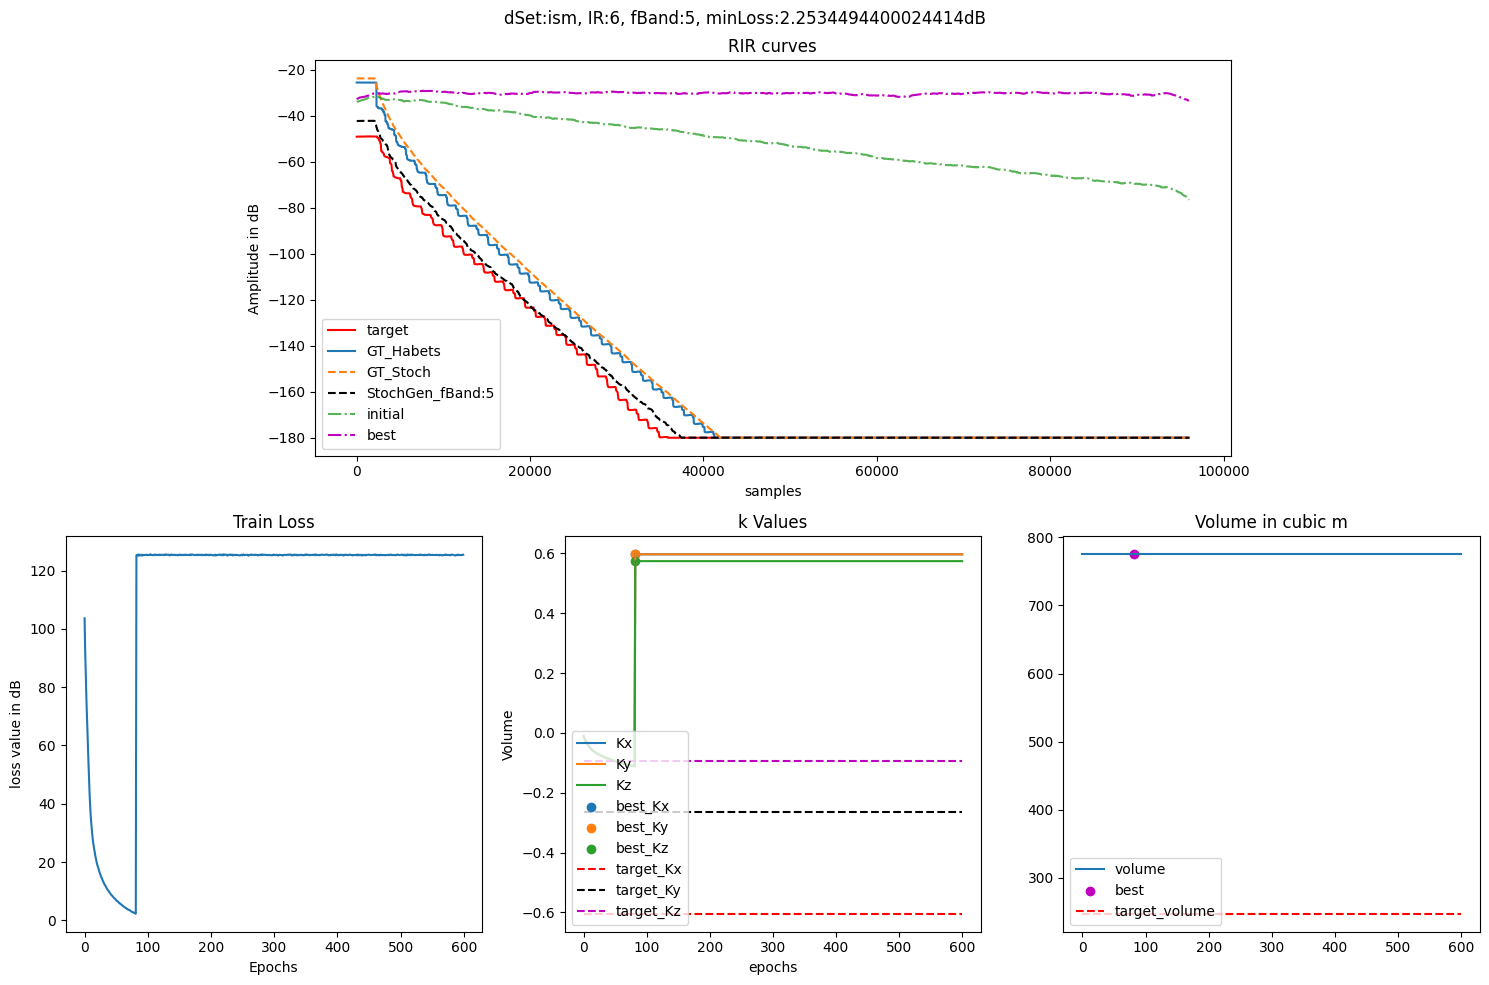

-------- Frequency Band: 6 --------

---- Trial number: 1 ---- 

Initial model Params:
Kx :  tensor(-0.0100, device='cuda:0')
Ky :  tensor(-0.0100, device='cuda:0')
Kz :  tensor(-0.0100, device='cuda:0')
V :  tensor([252.], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 115.2558
Loss in epoch:100 is : 3.2118
Loss in epoch:200 is : 3.1755
Loss in epoch:300 is : 3.1413
Loss in epoch:400 is : 3.1416
Loss in epoch:500 is : 3.1348
Converged!

Updated Param after Trial:
Kx :  tensor(-0.1173, device='cuda:0')
Ky :  tensor(-0.1173, device='cuda:0')
Kz :  tensor(-0.1220, device='cuda:0')
V :  tensor([252.], device='cuda:0')
Final model params for band-6: {'Kx': tensor(-0.1173), 'Ky': tensor(-0.1173), 'Kz': tensor(-0.1220), 'V': tensor([252.])}
final param: [tensor(-0.1173), tensor(-0.1173), tensor(-0.1220), tensor([252.])]
Best params: {'min_loss': tensor(3.1584), 'min_loss_epoch': tensor(110), 'Kx': tensor(-0.1179, device='cuda:0'), 'Ky': tensor(-0.1179, device='cuda:0'), 

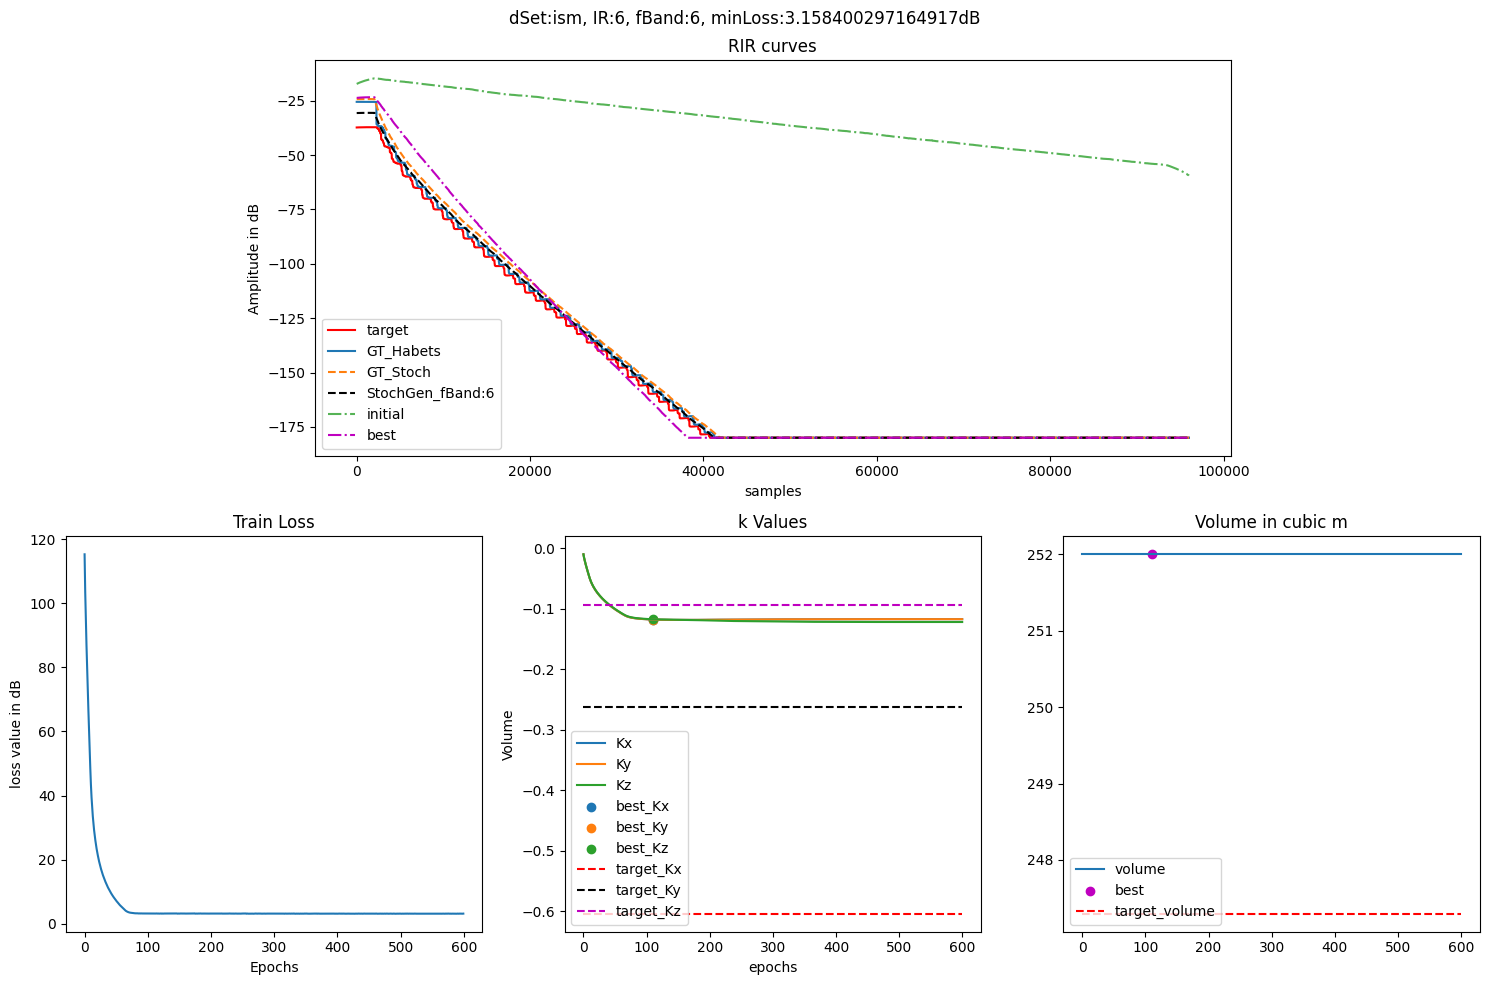

################################### 
 K values for all Bands: 
 ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss'] 
tensor([[-1.1898e-01, -1.1898e-01, -1.1855e-01,  2.9700e+02,  1.0000e+00,
          2.7295e+00],
        [-1.2037e-01, -1.2037e-01, -1.1995e-01,  1.1400e+02,  1.0000e+00,
          3.2205e+00],
        [-1.1519e-01, -1.1519e-01, -1.1468e-01,  3.7400e+02,  1.0000e+00,
          2.8269e+00],
        [-1.3398e-01, -1.3398e-01, -1.3354e-01,  1.2400e+02,  1.0000e+00,
          3.2481e+00],
        [ 5.9725e-01,  5.9725e-01,  5.7442e-01,  7.7500e+02,  1.0000e+00,
          2.2534e+00],
        [-1.1728e-01, -1.1728e-01, -1.2199e-01,  2.5200e+02,  1.0000e+00,
          3.1584e+00]])
 Converged for 6 bands 
 ################################### 
--------------
Total Rir converged: 6 out of 6 
 Rir not converged: []
--------------


In [26]:
## Real RIR training - add noise2/8-level - Del model- Frequency Dependent case
# hyper params
iter_ = 600
lr = 0.000006
env_filter_len = 4095
signal_gain = None    # dB
dB_clip = -180
normalize = False
model_used = RIR_model
# params
device = 'cuda'
logging_frequency = 100     # epochs  
stopping_criterion = 600   # epochs \ must be < 0.5* iter
accepted_loss = 5#20 #3    # good enough loss to stop searching     # dB
good_loss = 1 #10 #2    # minimum loss required - loss lower than this is arbitrary
converging_loss = 10#50    # maximum accepted loss
convergence_trials = 1
lossUpdate_thresh = 0.05
env_st = 0#48000   # 
fs = 48000
maxTime = (96000-env_st)/fs
cuton = torch.round(torch.tensor(0.10 * maxTime * fs)).int()
randW_eps = 1e-1
# For real RIR
dName = 'ism'
rir_data = torch.tensor(rir_np[:6, :], dtype=torch.float)#.to(device=device)
known_data = True
# rir_data = torch.tensor(rir_real[15:18, :], dtype=torch.float).to(device=device)
# rir_data = new_data.to(device=device)
label_names = ['Kx', 'Ky', 'Kz', 'Vol', 'Convergence', 'Min_loss']
#
rir_convergence_Counter = 0
rir_notConverged_memory = []
for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")
    if known_data:
        # for generated data
        lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:][env_st: ]
        labels = rir_bands(rir_.to(device=device), device=device)
        target_K_values, t_vol = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))), torch.prod(lengths)
        print(f"Target Kvalues: {lengths}, {target_K_values}, {t_vol}")
    else:
        # for real world data 
        labels = rir_bands(rir_data[i, :].to(device=device), device=device)
        #labels = rir_data.T
    # define counters and storage arrays
    #print(labels.size())
    #print("labels", rir_data.size())
    nBands = labels.size(1)
    k_array = torch.zeros((nBands, len(label_names)))#.to(device=device)    # store K values for all bands
    band_convergence_counter = 0
    band_convergence_counter2 = 0
    band_giveUp_counter = 0
    #
    for j in range(nBands):
        # for each frequency band
        print(f"-------- Frequency Band: {j+1} --------")
        # create label envelope
        l_env = rir_smoothing(labels[:, j], clip_ = dB_clip, filter_len=env_filter_len, useDefaults=False, device=device, )
        #l_env = edc_matlab(labels[:, j], cuton, clip_ = dB_clip)
        #l_env = env_makerF(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device, display_plots=False)
        #l_env = edc_matlab(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device), cuton)
        #
        l_smoothee = rir_smoothing(rir_.to(device=device),clip_ = dB_clip, filter_len=env_filter_len, useDefaults=False, device=device)
        #
        not_converged  = True
        convergence_flag = False
        giveUp_flag = False
        converge_counter = 0
        best_param_dict = {}
        global_loss = torch.inf
        param_plot_dict = { }
        while not_converged:
            bbest_param_dict = {}
            converge_counter += 1
            param_plot_dict = { }
            print(f"\n---- Trial number: {converge_counter} ---- ")
            # Initialization
            #volume = targetVol, 
            mod = model_used(max_time=maxTime, device=device).to(device=device)
            crit = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0).to(device=device)
            # crit = torch.nn.HuberLoss(reduction='mean', delta=3.0).to(device=device)
            #crit = torch.nn.L1Loss(reduction='mean').to(device=device)
            optim = torch.optim.SGD(mod.parameters(),lr=lr)#, momentum=0.9)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=30)
            init_param_dict = {}
            print("\nInitial model Params:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
                    init_param_dict.update({name:param.data.clone()})
                    param_plot_dict.update({ name : [param.data.clone().cpu().numpy()]})
            # plt.figure(989+i*j, figsize=(5,4))
            # plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict['del_Kx'], del_Ky=init_param_dict['del_Ky'], del_Kz=init_param_dict['del_Kz'], noise_level=init_param_dict['noise_level'],  device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            # plt.title('Initial')
            # plt.show()
            # Gradient descent
            t_l = []
            early_stopping = 0
            min_loss = torch.inf
            print("\nOptimization process starts:")
            for it in range(iter_):
                optim.zero_grad()
                y_hat = mod.forward()
                y_hat_ = rir_bands(y_hat, device=device)[:,j]
                #x_env = mag2db(y_hat + eps)
                x_env = rir_smoothing(y_hat_, filter_len=env_filter_len, useDefaults=True, device=device, clip_=dB_clip)
                #x_env = env_makerF(y_hat, filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
                #x_env = env_makerF(y_hat, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
                #x_env = edc_matlab(y_hat, cuton, clip_ = dB_clip)
                #if x_env.requires_grad : x_env.register_hook(lambda x : print("x_env: ", x,x_env.grad_fn,x_env.data, torch.any(torch.isnan(x))))
                # random weighting
                random_W = torch.FloatTensor(96000 - env_st).uniform_(1-randW_eps, 1+randW_eps).to(device=device)
                #l = crit(x_env*random_W, l_env*random_W)
                l = crit(x_env, l_env)
                #l = torch.mean(torch.abs(x_env - l_env)*random_W)
                #l = torch.sqrt(torch.clamp(torch.mean(torch.square(x_env - l_env)*torch.square(random_W)), min=0.0000001))
                #if torch.isnan(l): break
                l.backward()
                optim.step()
                scheduler.step(l)
                log_l = l.clone().detach().cpu()
                t_l.append(log_l)
                # plot k values
                for name, param in mod.named_parameters():
                    if param.requires_grad:
                        param_plot_dict[name].append(param.data.clone().cpu().numpy())
                # early stopping
                # early stopping for convergent cases
                #if log_l < min_loss:
                if min_loss - log_l > lossUpdate_thresh:
                    early_stopping = 0
                    min_loss = log_l
                    # save params
                    bbest_param_dict.update({'min_loss': min_loss})
                    bbest_param_dict.update({'min_loss_epoch': torch.tensor(it)})
                    for name, param in mod.named_parameters():
                        if param.requires_grad:
                            bbest_param_dict.update({name: param.data.clone()})
                else:
                    early_stopping += 1    
                
                
                if it%logging_frequency == 0 : 
                    print(f'Loss in epoch:{it} is : {np.round(np.float64(l.detach()), decimals=4)}')
                    #print(x_env.size(), l_env.size())
                    if False:
                        plt.figure((it+1)*547, figsize=(10,4))
                        plt.subplot(1,2,1)
                        plt.plot(y_hat[:25000].clone().detach().cpu(), label='model')
                        plt.plot(labels[:25000, j].cpu() * 100, label="target", alpha=0.8)
                        #plt.yscale("log")
                        plt.legend()
                        plt.subplot(1,2,2)
                        plt.plot(x_env.clone().detach().cpu(), label='model')
                        plt.plot(l_env.clone().detach().cpu(), label='target')
                        plt.legend()
                        plt.show()
                
                if early_stopping > stopping_criterion: 
                    print('Break: Early Stopping')
                    break
                if min_loss < good_loss:
                    print('Break: Good enough loss')
                    break
            # converge case
            if min_loss < accepted_loss: 
                print("Converged!")
                not_converged=False   
                band_convergence_counter += 1
                convergence_flag = True  
            elif converge_counter >= convergence_trials: 
                # tried but not converged
                print("Give Up!")
                not_converged=False
                band_giveUp_counter += 1
                giveUp_flag = True
            
            # check global convergence among trials
            if min_loss < global_loss:
                global_loss = min_loss
                best_param_dict = bbest_param_dict
            
            print("\nUpdated Param after Trial:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
            

        #print(f"\nFinal Updated model Params:")
        final_param_collector = {} #torch.zeros((1)).to(device=device)
        #print("best", best_param_dict)
        
        if giveUp_flag:
            if global_loss < converging_loss:
                print("\nconverged2: by accepted loss !")
                band_convergence_counter += 1
                band_convergence_counter2 += 1
                convergence_flag = True
            # take the best 
            print("best params:", best_param_dict)
            for key in best_param_dict:
                    if key == 'min_loss' or key=='min_loss_epoch':
                        continue
                    else:
                        final_param_collector.update({key: best_param_dict[key].detach().cpu()})
            #final_param_collector = torch.concat((final_param_collector, best_param_dict['del_Kx'].view(-1), best_param_dict['del_Ky'].view(-1), best_param_dict['del_Kz'].view(-1)))
        else:
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    #print( name,': ', param.data)
                    #final_param_collector = torch.concat((final_param_collector, param.data.view(-1)))
                    final_param_collector.update({name: param.data.detach().cpu()})
        
        
        ####################-----PLOTTING-----###################### 
        print(f"Final model params for band-{j+1}: {final_param_collector}")
        final_param_tensor = list(final_param_collector.values())
        print("final param:", final_param_tensor)
        print('Best params:', best_param_dict)
        # final_param_tensor.append(convergence_flag)
        # final_param_tensor.append(best_param_dict['min_loss'])
        # k_array[j, :] = torch.tensor(final_param_tensor)
        # final_K_values = calculate_K_from_del(final_param_tensor[0], final_param_tensor[1], final_param_tensor[1])
        # print(f"Final K values: Kx: {final_K_values[0]}, Ky: {final_K_values[1]}, Kz: {final_K_values[2]}")
        ###
        if model_used == RIR_model_del:
            final_K_values = calculate_K_from_del(final_param_tensor[0], final_param_tensor[1], final_param_tensor[2])
            print(f"\nFinal K values: Kx: {np.round(np.float64(final_K_values[0]), 4)}, Ky: {np.round(np.float64(final_K_values[1]), 4)}, Kz: {np.round(np.float64(final_K_values[2]), 4)}")
            final_K_values.append(final_param_tensor[3])
            # plot K value part
            kValue_plot_dict = {'Kx':[],'Ky':[], 'Kz':[], 'V':[]}
            dKeys = list(param_plot_dict.keys())
            print("dkeyss", dKeys)
            for ik in range(len(param_plot_dict[dKeys[0]])):
                Kx, Ky, Kz = calculate_K_from_del(param_plot_dict[dKeys[0]][ik], param_plot_dict[dKeys[1]][ik], param_plot_dict[dKeys[2]][ik])
                kValue_plot_dict['Kx'].append(Kx)
                kValue_plot_dict['Ky'].append(Ky)
                kValue_plot_dict['Kz'].append(Kz)
            kValue_plot_dict['V'] = param_plot_dict['V']
        else:
            final_K_values = final_param_tensor
            kValue_plot_dict = param_plot_dict
        final_K_values.append(convergence_flag)
        final_K_values.append(best_param_dict['min_loss'])
        print('Final__K:', final_K_values, final_param_tensor)
        k_array[j, :] = torch.tensor(final_K_values)
        ###
        # print(param_dict)
        #print("best: ", best_param_dict)
        param_keys = list(kValue_plot_dict.keys())
        model_param_keys = list(init_param_dict.keys())
        print('keys', model_param_keys, param_keys, len(kValue_plot_dict[param_keys[0]]))
        ### Temp
        if known_data:
            kkk = target_K_values.to(device=device)#torch.tensor([-0.3275, -0.1038, -0.0313])
            vv = t_vol.to(device=device)# torch.tensor(213.56)
            env_mod, stoch_RIR = generate_stochastic_rir(Kx=kkk[0], Ky=kkk[1], Kz=kkk[2], V=vv, max_time=maxTime, device=device, dual_output=True)
            stoch_bands = rir_bands(stoch_RIR, device=device)
        fig = plt.figure(i+j+1, figsize=(15,10))
        ax1 = plt.subplot2grid(shape=(2,6), loc=(1,0), colspan=2)
        ax2 = plt.subplot2grid((2,6), (0,1), colspan=4)
        ax3 = plt.subplot2grid((2,6), (1,2), colspan=2)
        ax4 = plt.subplot2grid((2,6), (1,4), colspan=2)
        #ax5 = plt.subplot2grid((2,6), (1,4), colspan=2)
        fig.suptitle(f"dSet:{dName}, IR:{i+1}, fBand:{j+1}, minLoss:{best_param_dict['min_loss']}dB")
        #plt.subplot(2,3,1)
        ax1.plot(t_l,)# linestyle='', marker='.')
        ax1.set_ylabel('loss value in dB')
        ax1.set_xlabel('Epochs')
        ax1.set_title("Train Loss")
        #plt.subplot(2,3,2)
        ax2.plot(l_env.detach().cpu(), color='r',linestyle='-',label='target') #,label=f'HabetsTarget_fBand:{j+1}')
        if known_data:
            #temp###
            ax2.plot(l_smoothee.cpu(),linestyle='-', label ='GT_Habets')
            #####
            ax2.plot(rir_smoothing(stoch_RIR.cpu(), filter_len=env_filter_len, useDefaults=True, clip_=dB_clip), label='GT_Stoch',linestyle='--' )
            ax2.plot(rir_smoothing(stoch_bands[:,j].cpu(), filter_len=env_filter_len, useDefaults=True, clip_=dB_clip), label=f'StochGen_fBand:{j+1}',linestyle='--',color='k' )
            #plt.plot(mag2db(env_mod).cpu(),linestyle='--', label='Model generated envelope')
        if model_used == RIR_model_del:
            plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict[model_param_keys[0]], del_Ky=init_param_dict[model_param_keys[1]], del_Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=best_param_dict[model_param_keys[0]], del_Ky=best_param_dict[model_param_keys[1]], del_Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='best')
            # plt.plot(edc_matlab(, cuton))
            # plt.plot(edc_matlab(, cuton))
        else:
            # plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            # plt.plot(env_makerF(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='best')
            # plt.plot(edc_matlab(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), cuton, clip_ = dB_clip).cpu(), label='initial')
            # plt.plot(edc_matlab(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), cuton, clip_ = dB_clip).cpu(), label='best')
            # plt.plot(mag2db(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device) + eps).cpu(), label='initial', alpha = 0.8) # linestyle='dotted', alpha = 0.8)
            # plt.plot(mag2db(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device) + eps).cpu(), label='best',linestyle='--',color='m' )
            # plt.plot(rir_smoothing(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='initial', alpha = 0.8) # linestyle='dotted', alpha = 0.8)
            # plt.plot(rir_smoothing(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='best',linestyle='--',color='m' )
            ax2.plot(rir_smoothing(rir_bands(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), device=device)[:,j], filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='initial',linestyle='-.', alpha = 0.8) # linestyle='dotted', alpha = 0.8)
            ax2.plot(rir_smoothing(rir_bands(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), device=device)[:,j], filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='best',linestyle='-.',color='m' )
        #plt.plot(env_makerF(mod.forward().detach(), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='final')
        #plt.plot(edc_matlab(mod.forward().detach(), cuton, clip_ = dB_clip).cpu(), label='final')
        #plt.plot(mag2db(mod.forward().detach() + eps).cpu(), label='final', color='g', alpha=0.8)#,linestyle='-.')
        #plt.plot(rir_smoothing(mod.forward().detach() , filter_len=env_filter_len,useDefaults=True, device=device, clip_=dB_clip).cpu(), label='final', color='g', alpha=0.8)#,linestyle='-.')
        ax2.set_ylabel('Amplitude in dB')
        ax2.set_xlabel('samples')
        ax2.set_title("RIR curves")
        ax2.legend()
        #plt.subplot(2,3,4)
        ax3.plot(kValue_plot_dict[param_keys[0]], label=param_keys[0])
        ax3.plot(kValue_plot_dict[param_keys[1]], label=param_keys[1])
        ax3.plot(kValue_plot_dict[param_keys[2]], label=param_keys[2])
        ax3.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[0]].cpu(), label=f'best_{param_keys[0]}')
        ax3.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[1]].cpu(), label=f'best_{param_keys[1]}')
        ax3.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[2]].cpu(), label=f'best_{param_keys[2]}')
        if known_data:
            ax3.hlines(target_K_values[0], xmin=0, xmax=len(t_l), label='target_Kx', color='r', linestyle='--')
            ax3.hlines(target_K_values[1], xmin=0, xmax=len(t_l), label='target_Ky', color='k', linestyle='--')
            ax3.hlines(target_K_values[2], xmin=0, xmax=len(t_l), label='target_Kz', color='m', linestyle='--')
        #plt.plot(param_plot_dict[param_keys[3]], label=param_keys[3])    # Noise Level
        ax3.set_ylabel('value')
        ax3.set_xlabel('epochs')
        ax3.set_title("k Values")
        ax3.legend(loc='lower left')
        #plt.subplot(2,3,5)
        ax4.plot(kValue_plot_dict[param_keys[3]], label='volume')
        ax4.scatter(best_param_dict['min_loss_epoch'], best_param_dict[param_keys[3]].cpu(), color='m',label='best')
        ax4.set_title('Volume in cubic m')
        ax3.set_ylabel('Volume')
        ax3.set_xlabel('epochs')
        if known_data:
            ax4.hlines(t_vol, xmin=0, xmax=len(t_l), label='target_volume', color='r', linestyle='--' )
        ax4.legend()
        # plt.subplot(2,3,5)
        # plt.plot(param_plot_dict['noise_level'])
        rootDir = f"./imgs/{dName}_{str(crit)[:-2]}"
        os.makedirs(rootDir, exist_ok=True)
        fig_fName = f"rir_{i+1}_band_{j+1}.jpg"
        # plt.savefig(os.path.join(rootDir, fig_fName), )
        print('fname:',os.path.join(rootDir, fig_fName))
        fig.tight_layout()
        plt.show()
    print(f"################################### \n K values for all Bands: \n {label_names} \n{k_array}\n Converged for {band_convergence_counter} bands \n ################################### ")
    if band_convergence_counter == 6 : rir_convergence_Counter += 1 
    else : rir_notConverged_memory.append((i, band_convergence_counter, band_convergence_counter2))    # save rir not converged index
print(f"--------------\nTotal Rir converged: {rir_convergence_Counter} out of {rir_data.size(0)} \n Rir not converged: {rir_notConverged_memory}\n--------------")